<a href="https://colab.research.google.com/github/SahibBayezian/Dataiku-Assessment/blob/main/Copy_of_Dataiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataiku Data Science Tehnical Assessment 
### **Census Income Dataset**

**Problem Statement:** Identify characteristics that are associated with a person making more or less than $50000 per year

The GoogleColab document is divided into three main sections:

*   EDA / Data Preperation 
*   Data Modelling / Model Assesment 
*   Results

*Please use the Table of contents to navigate in the document*

# **Setup**

In [108]:
install.packages("caret")
install.packages("outliers")
install.packages("missForest")
install.packages("ROCR")
install.packages("ROCR")
install.packages("caretEnsemble")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)
library(tidyverse)
library(caret)
library(outliers)
library(missForest)
library(ROCR)
library(caretEnsemble)
library(glmnet)

# **EDA** / **Data Preparation**

In this section I provide a numerical/graphical representation of the data and conduct any data cleaning, preprocessing and feature engineering according to my needs. 

## **Training Data**

Before uploading the data, I had a quick understanding of the dataset using the metadata and census additional document. I also added the column names for ease of understanding. 

In [4]:
Train_data<-read.csv("census_income_learn.csv",header = T)
#str(Train_data)

# Removing "instance.weight" 
Train_data<-Train_data[-25]

# Seperating numerical and categorical columns based on metadata file and data inspection
Num_var <- colnames(Train_data[,c(1,6,17,18,19,30,39)])
Cat_var <- colnames(Train_data[,c(-1,-6,-17,-18,-19,-30,-39)])

# Converting featrues to numerical/categorical 
Train_data[Num_var]<-lapply(Train_data[Num_var], as.numeric)
Train_data[Cat_var]<-lapply(Train_data[Cat_var], as.factor)

str(Train_data)
#The data contains 199523 obs. of  41 variables

'data.frame':	199523 obs. of  41 variables:
 $ age                                       : num  73 58 18 9 10 48 42 28 47 34 ...
 $ class.of.worker                           : Factor w/ 9 levels " Federal government",..: 4 7 4 4 4 5 5 5 2 5 ...
 $ industry.code                             : Factor w/ 52 levels "0","1","2","3",..: 1 5 1 1 1 41 35 5 44 5 ...
 $ occupation.code                           : Factor w/ 47 levels "0","1","2","3",..: 1 35 1 1 1 11 4 41 27 38 ...
 $ education                                 : Factor w/ 17 levels " 10th grade",..: 13 17 1 11 11 17 10 13 17 17 ...
 $ wage.per.hour                             : num  0 0 0 0 0 1200 0 0 876 0 ...
 $ enrolled.in.edu.inst.last.wk              : Factor w/ 3 levels " College or university",..: 3 3 2 3 3 3 3 3 3 3 ...
 $ marital.status                            : Factor w/ 7 levels " Divorced"," Married-A F spouse present",..: 7 1 5 5 5 3 3 5 3 3 ...
 $ major.industry.code                       : Factor w/ 24 levels " Ag

In [5]:
#summary(Train_data)

# The dataset is mainly factors and numberical variables. 
# The presense of "Not in universe" imbalances the categorical attributes alot. Will have to check the attributes specifically and pre-process accordingly  

## **Missing Values Inspection**

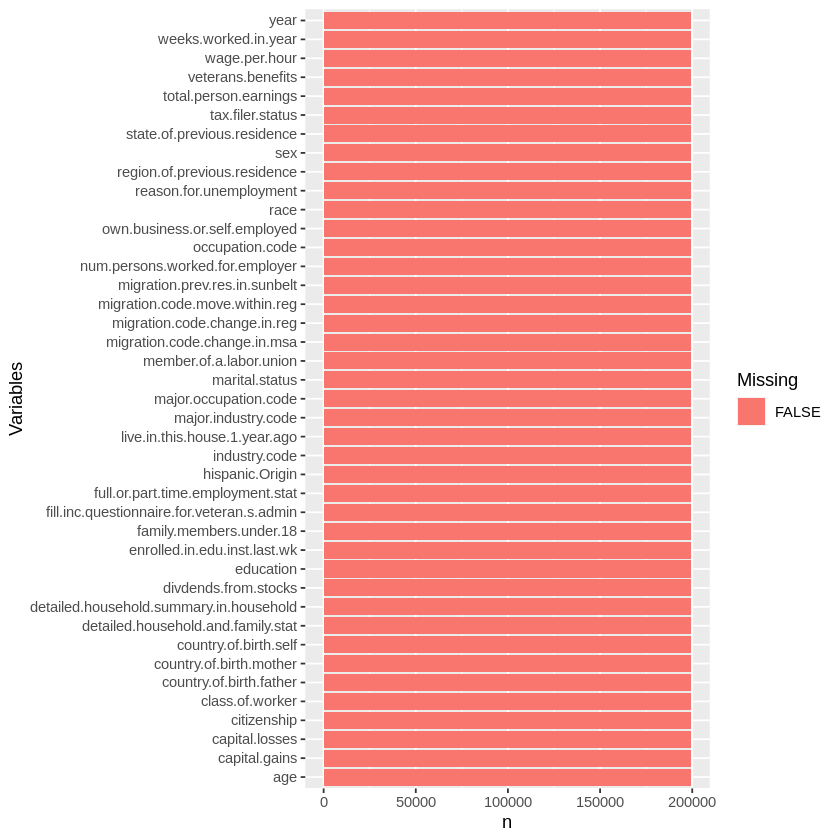

In [6]:
# Missing Values Inspection 

Train_data  %>%
  summarise_all(list(~is.na(.)))%>%
  pivot_longer(everything(),
               names_to = "Variables", values_to="Missing") %>%
  count(Variables, Missing) %>%
  ggplot(aes(y=Variables,x=n,fill=Missing))+
  geom_col()

# There is no missing values present in any of the features, however on closer inspection of the data structure above it is visible that there are some " ?" categories. 

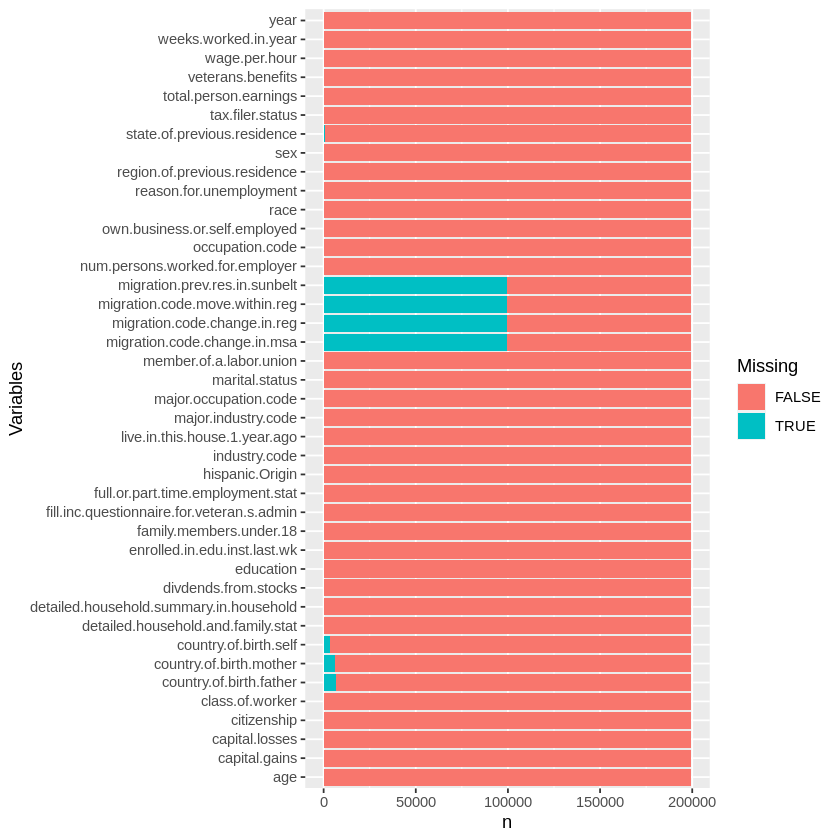

In [7]:
# " ?" Value Inspection 

# On checking the metadata file the " ?" category is not an option, therefore it will be regarded as NA
Train_data[Cat_var]<-lapply(Train_data[Cat_var], as.character)
Train_data[Train_data == " ?"] <- NA

Train_data  %>%
  summarise_all(list(~is.na(.)))%>%
  pivot_longer(everything(),
               names_to = "Variables", values_to="Missing") %>%
  count(Variables, Missing) %>%
  ggplot(aes(y=Variables,x=n,fill=Missing))+
  geom_col()

# Returning to factors
Train_data[Cat_var]<-lapply(Train_data[Cat_var], as.factor)

# The graph below shows that there are 7 columns that contained the " ?" category input.
# Therefore, there are NA present in the dataset now and will need to be dealt with. 

There is around 50% data missing in the migration features. In order for this data pipeline and to reduce dimmensionaliy I will be removing these features.
For the birth country feature outliers and state of previous residence, given the small amount I will look at the distribution of the factors within the respective features and plan to fill the NA accordingly.  

In [8]:
# Removing migration features
Train_data<- Train_data[,-c(25,26,27,29)]

Num_var<-names(which(unlist(lapply(Train_data, is.numeric))))
Cat_var<-names(which(unlist(lapply(Train_data, is.factor))))


## Target Variable Distribution

To get an understanding of the target variable, I did a quick barplot to see the distribution. 


 50000+.   -50000 
   12382   187141 

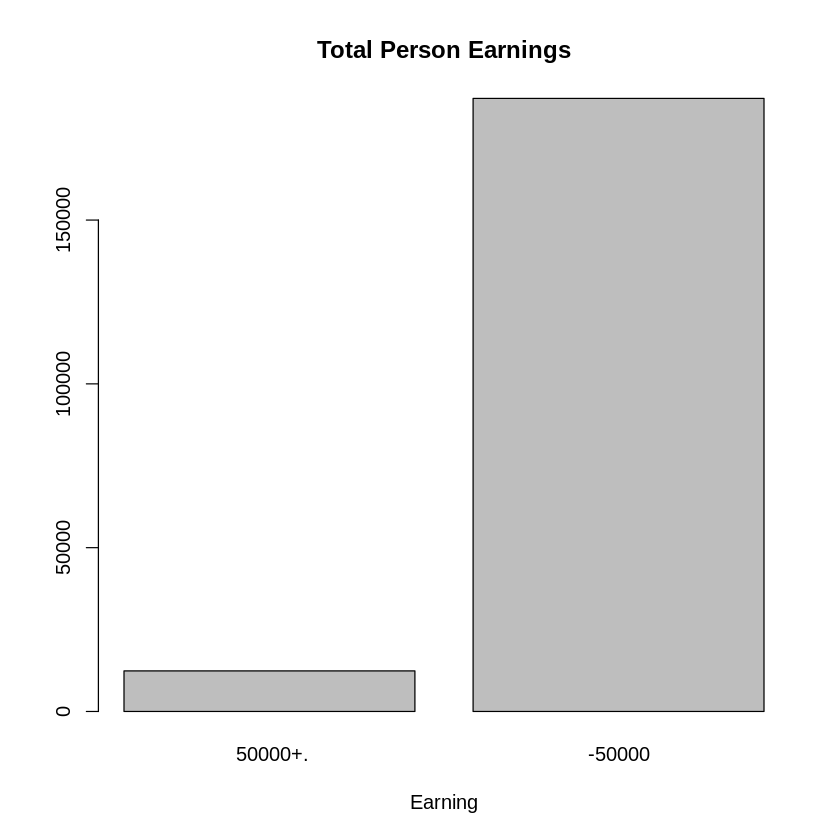

In [9]:
counts <- table(Train_data$total.person.earnings)
counts
barplot(counts, main="Total Person Earnings",
   xlab="Earning")

# The target variable has 2 values, +$50000 & -$50000. There are 199523 obs., however the target variable is highly imbalanced, with around 15x more "-$50000" category obs present.
# Will need to consider class rebalancing/resampling when predicting. 

## Numerical Features Distributions

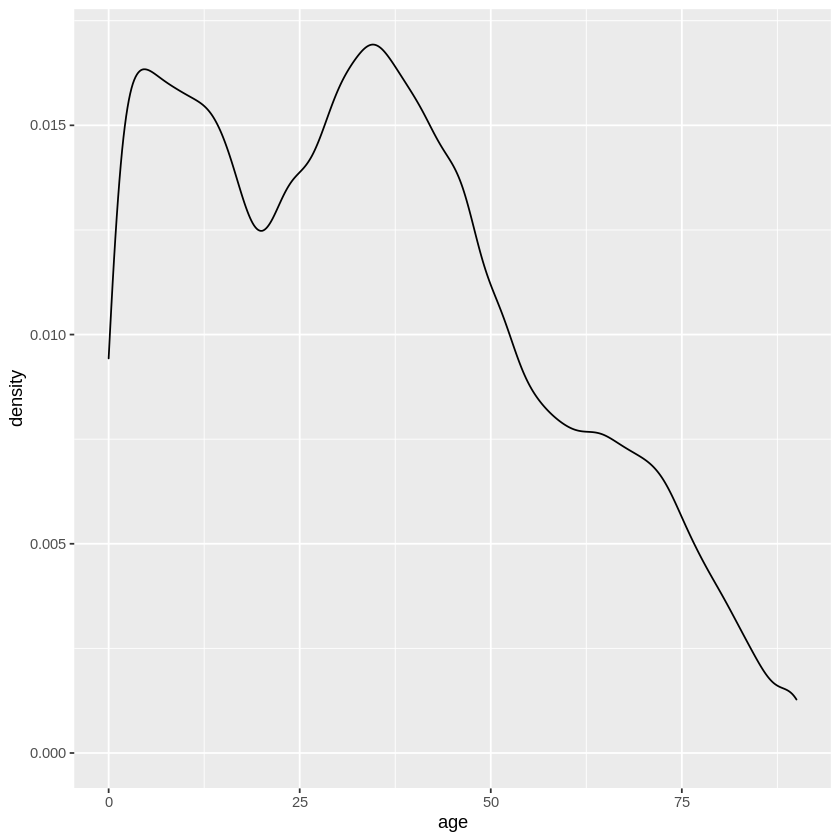

In [10]:
#Age
ggplot(Train_data, aes(x=age)) +  geom_density()

#Slighlty positively skewed. Applied log transformation but resulted in a negative skew curve, therefore doesn't show a benefit for transformation at the moment.
#Majority of the age in the dataset spans from 0-48 years old and the count decreases as the age increases. There is a slight dip on teenagers/early adults.    
#ggplot(Train_data, aes(x=log(age+0.1))) +  geom_density()

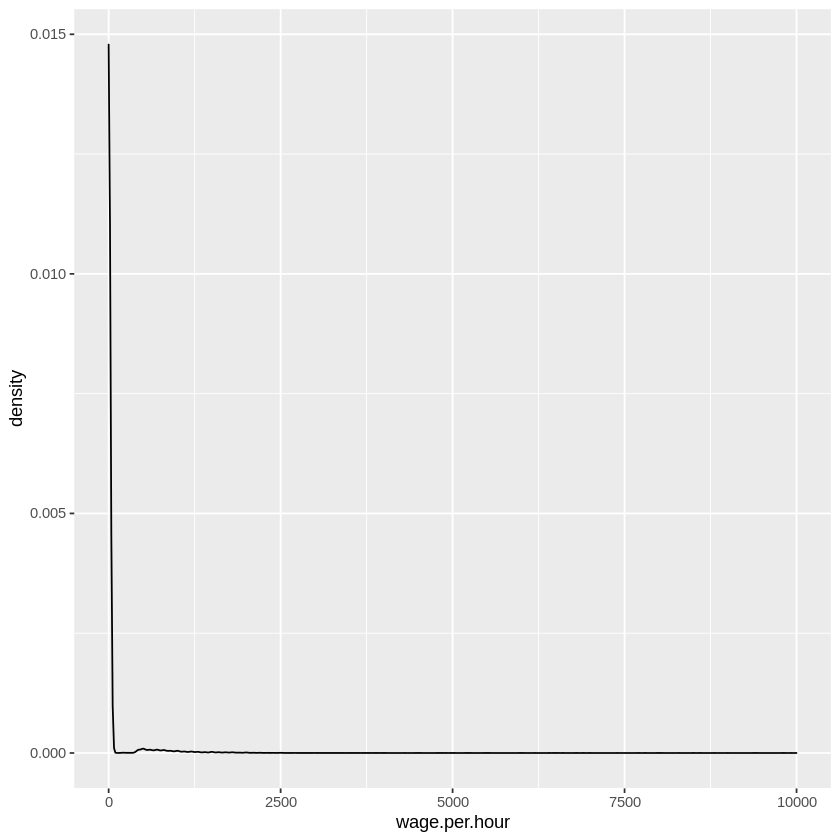

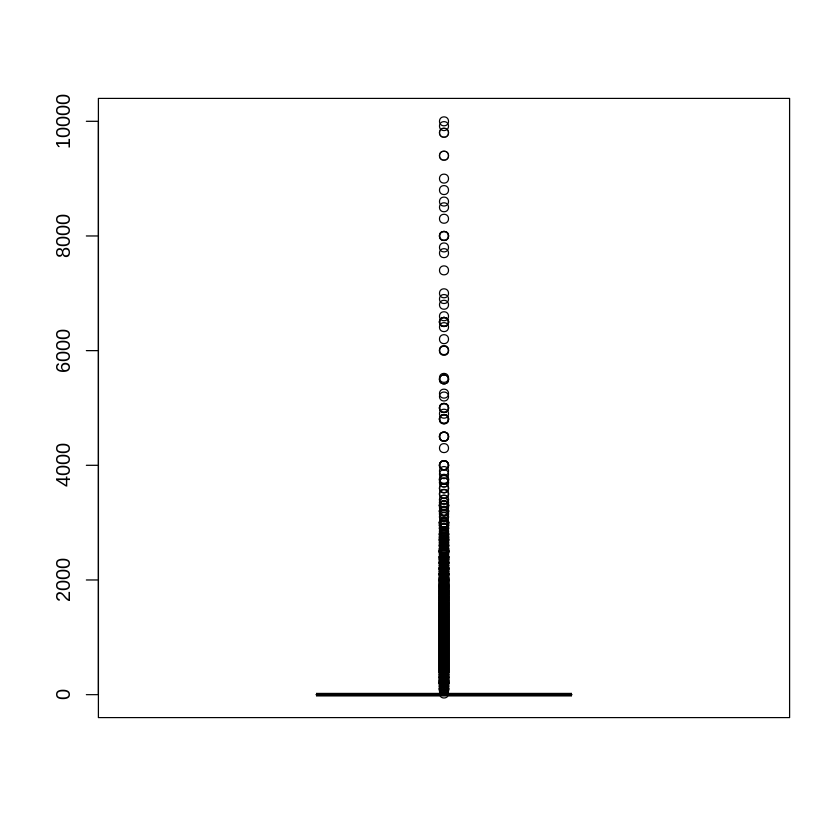

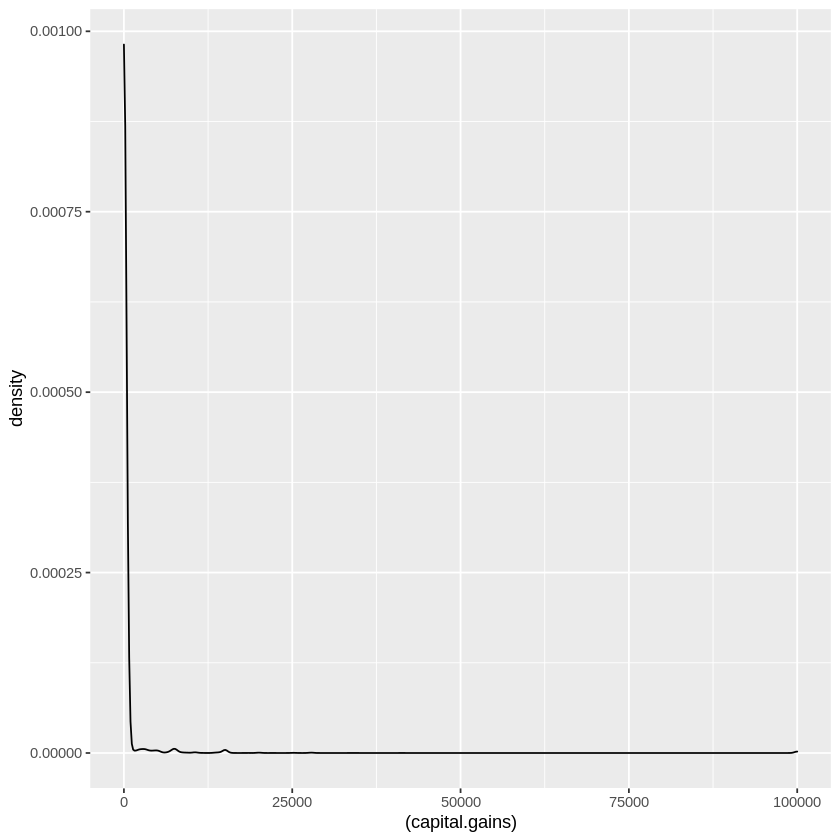

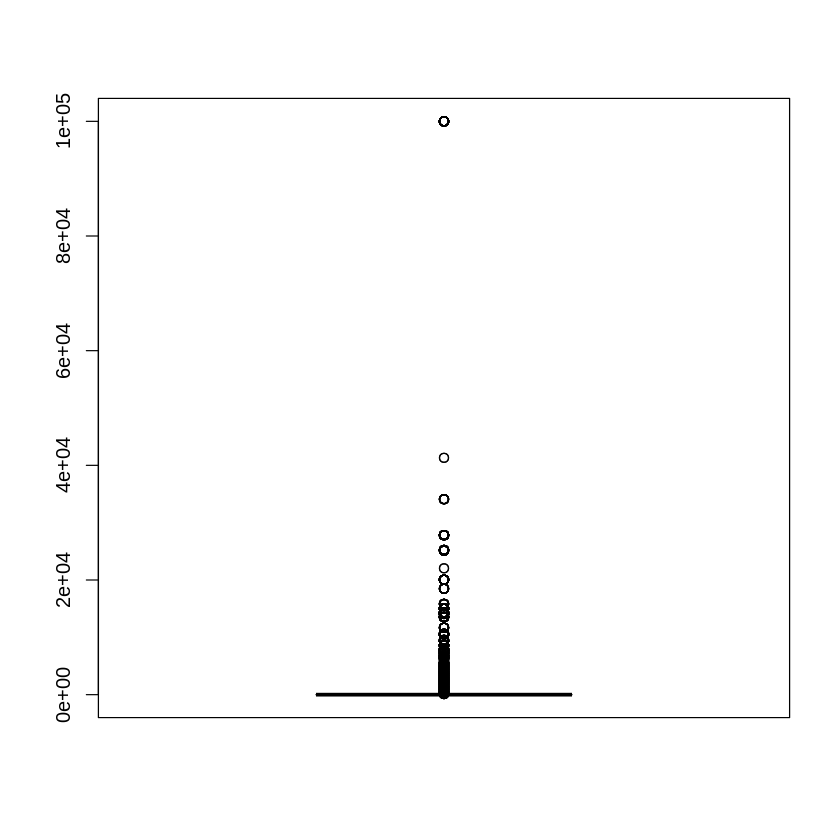

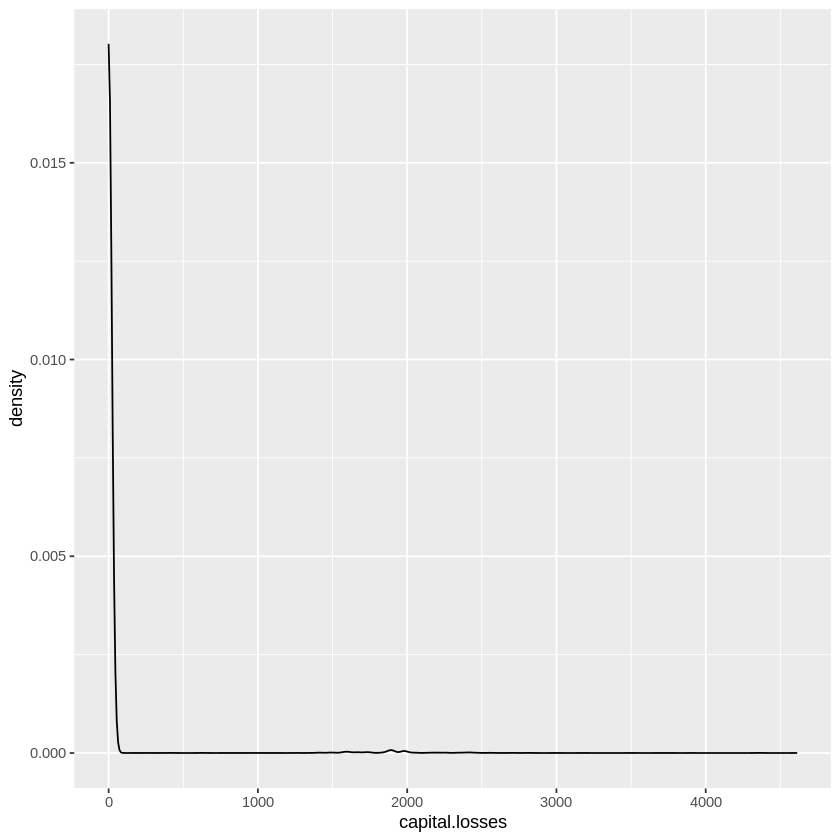

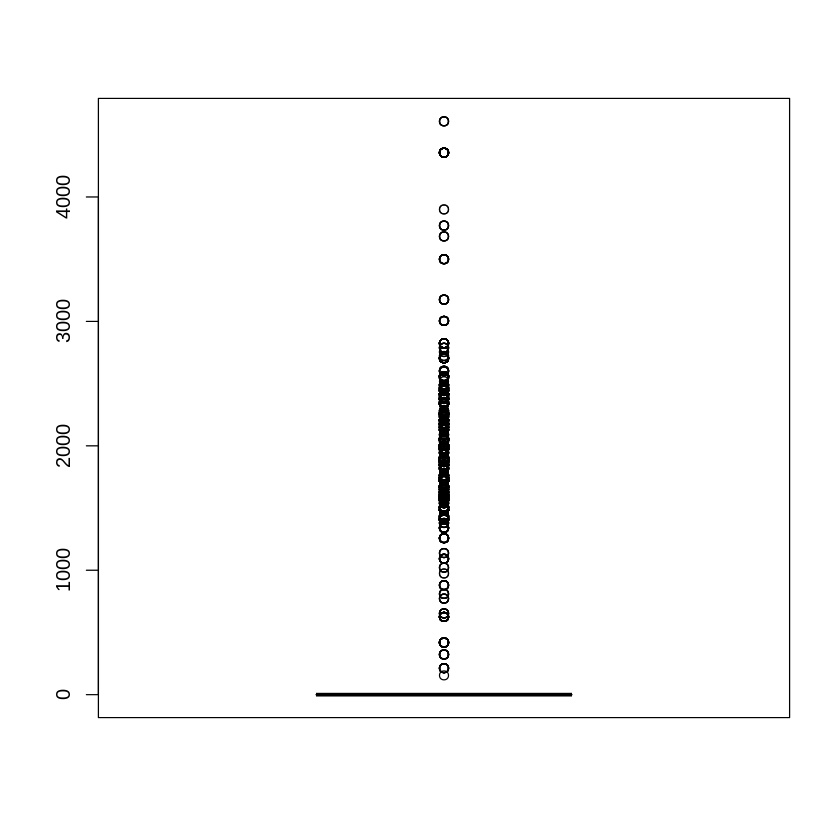

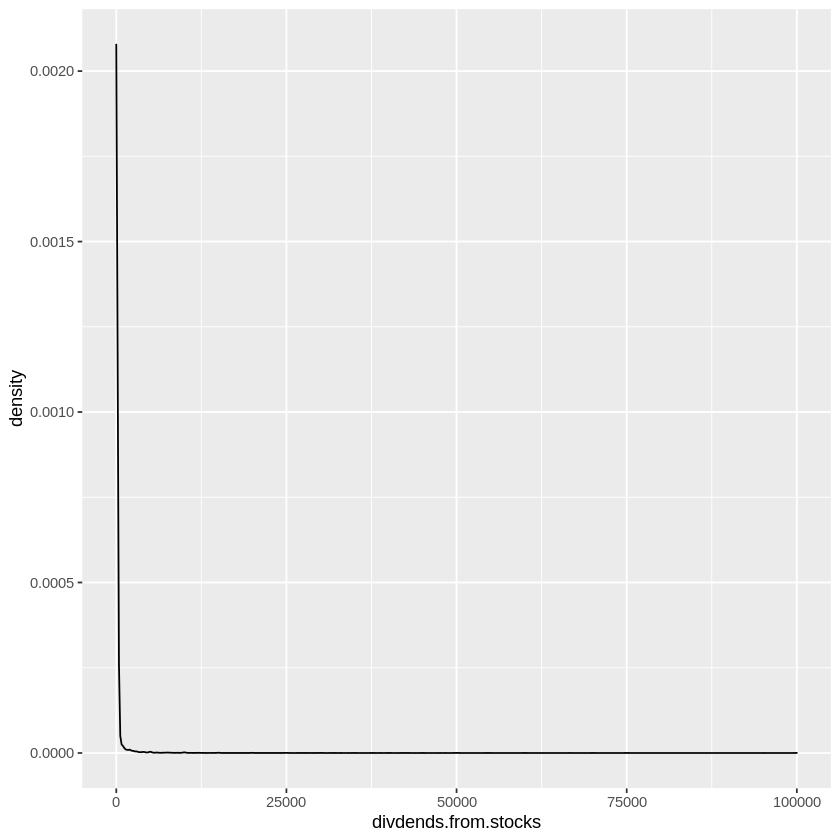

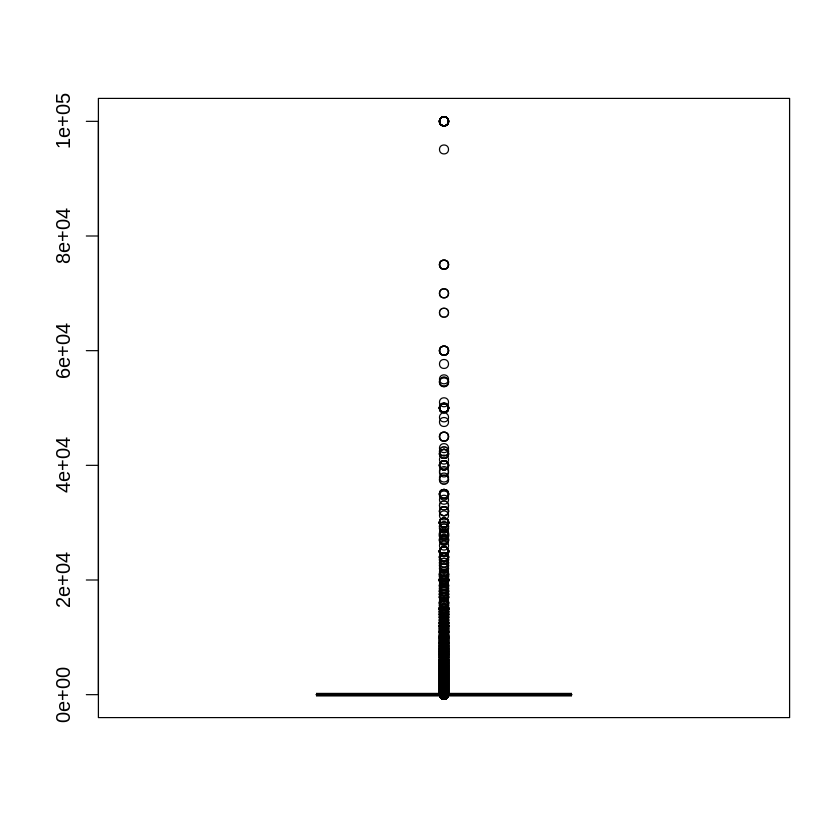

In [11]:
#wage.per.hour
ggplot(Train_data, aes(x=wage.per.hour)) +  geom_density()
boxplot(Train_data$wage.per.hour)

#'capital.gains'
ggplot(Train_data, aes(x=(capital.gains))) + geom_density()
boxplot(Train_data$capital.gains)

#'capital.losses'
ggplot(Train_data, aes(x=capital.losses)) + geom_density()
boxplot(Train_data$capital.losses)

#'divdends.from.stocks'
ggplot(Train_data, aes(x=divdends.from.stocks)) +   geom_density()
boxplot(Train_data$divdends.from.stocks)

# All the distributions from these features were highly positve skewed, as the features are more monetary gained focused there are some outliers that can be expected such 
# as some people earning way more than the norm resulting in a long tail.
# On inspecting the bar plots the distribution can clearly be seen to surpass the maximum. 
# Will consider for outliers or transformation in the data preperation step 


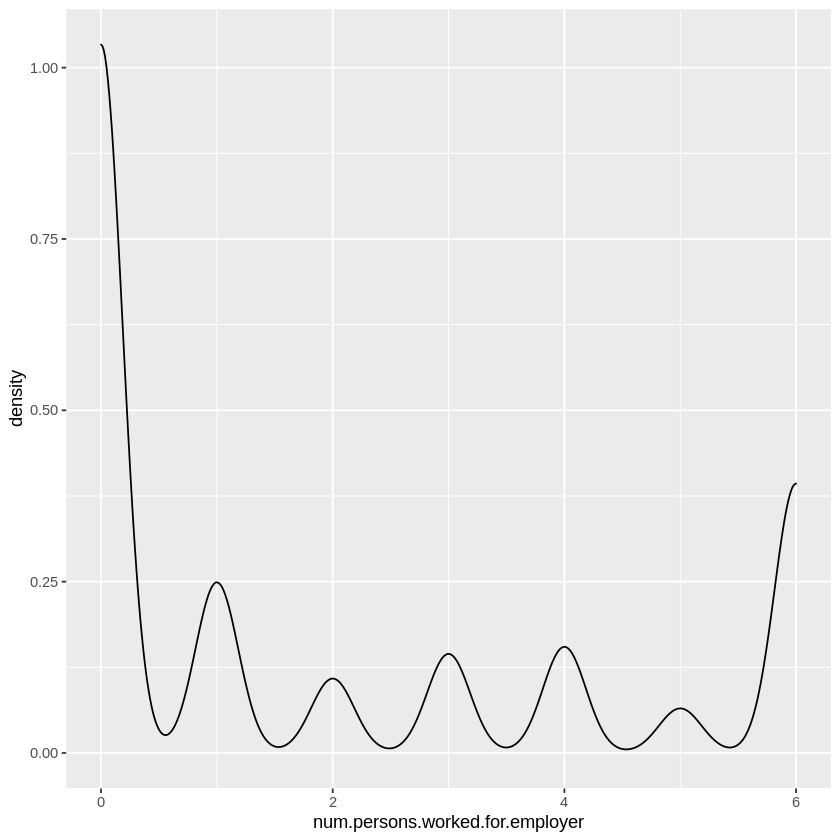

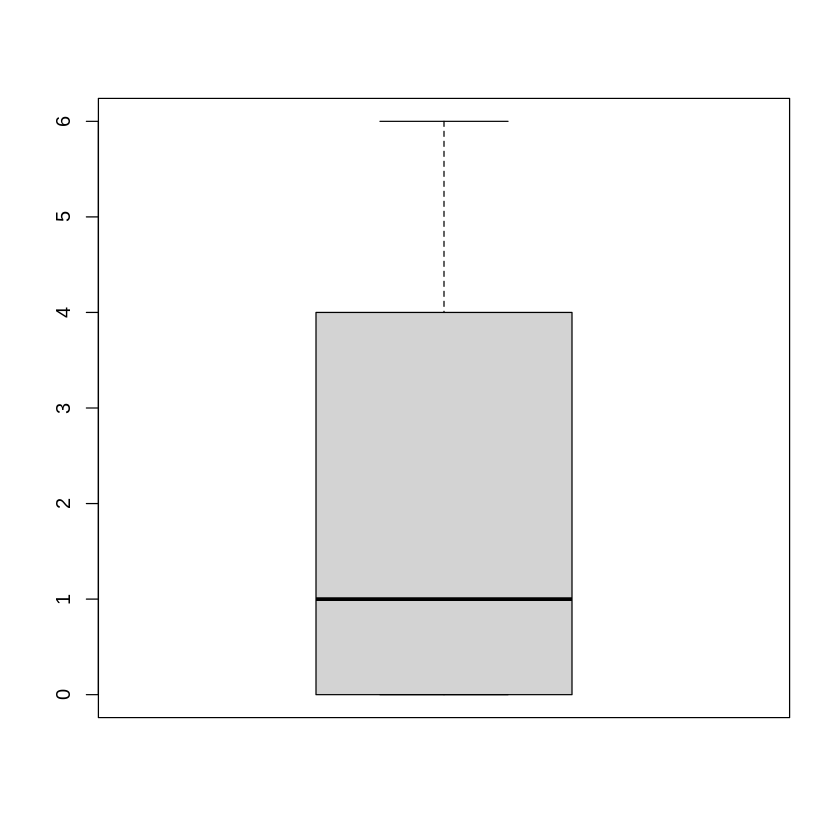

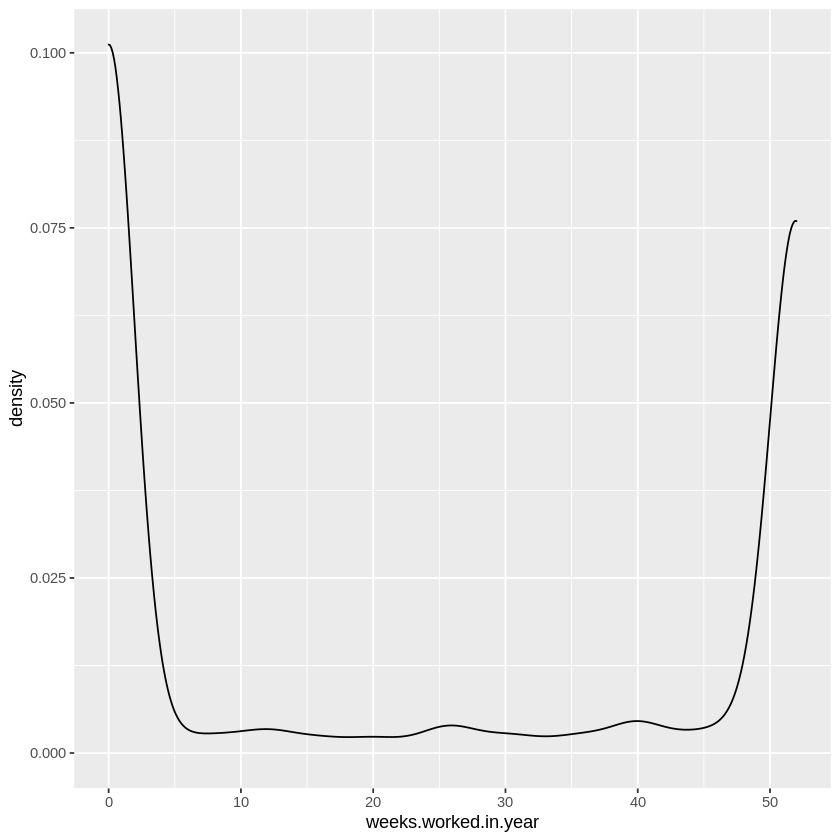

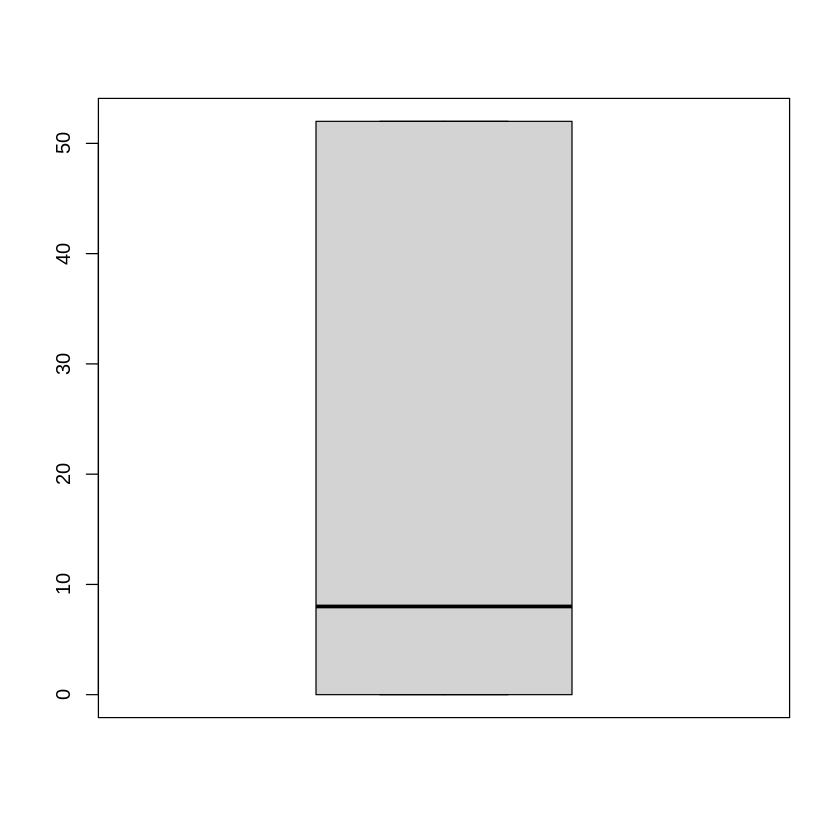

In [12]:
#'num.persons.worked.for.employer'
ggplot(Train_data, aes(x=num.persons.worked.for.employer)) + geom_density()
boxplot(Train_data$num.persons.worked.for.employer)

#'weeks.worked.in.year'
ggplot(Train_data, aes(x=weeks.worked.in.year)) + geom_density()
boxplot(Train_data$weeks.worked.in.year)

# The num of people who work for employer is binned in 7 categories (0-6). Therefore a clear jump can be seen in each level and highest was the "not in universe", as a high amount of the data contains children/teenagers who don't usually work as shown in the age attribute. 
# Usually people work in big companies (6 = 10000+) which can be seen in the data as 6 is the second highest. 
# There are around 52 working weeks in a year. This can be clearly demonstrated by the data as well as in the "weeks.worked" feature the highest amount is close to 52.
# The rest of the data is in the "not in universe" category  

### **Removal of outliers using Z-score**


In [13]:
# Z-score (also called a standard score) gives an idea of how far from the mean a data point is. 
# But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is.’

z.scores <- Train_data[,c("wage.per.hour", "capital.gains","capital.losses","divdends.from.stocks")] %>% scores(type = "z")
#wage_z.scores %>% summary()
#which(abs(z.scores) >3 )

#table(Train_data$total.person.earnings)

paste0("Outliers in total person earnings")
table(Train_data$total.person.earnings[(which(abs(z.scores) >3 ))])

Train_data<-Train_data[-(which(abs(z.scores) >3 )),]

# Considering the imbalance in the target varaible. The outlier rows for the minority factor (+50000), were only 3% of the data.
# Given not a big effect on the dataset the outliers were removed. 
# However, the distrbution of the above continous features were still heavily positive skewwed. Therefore, models that are robust to distribution will need to be considered. 

[1] "Outliers in total person earnings"


 50000+.   -50000 
     458     4509 

## Categorical Features Distribution 

### Quick overview

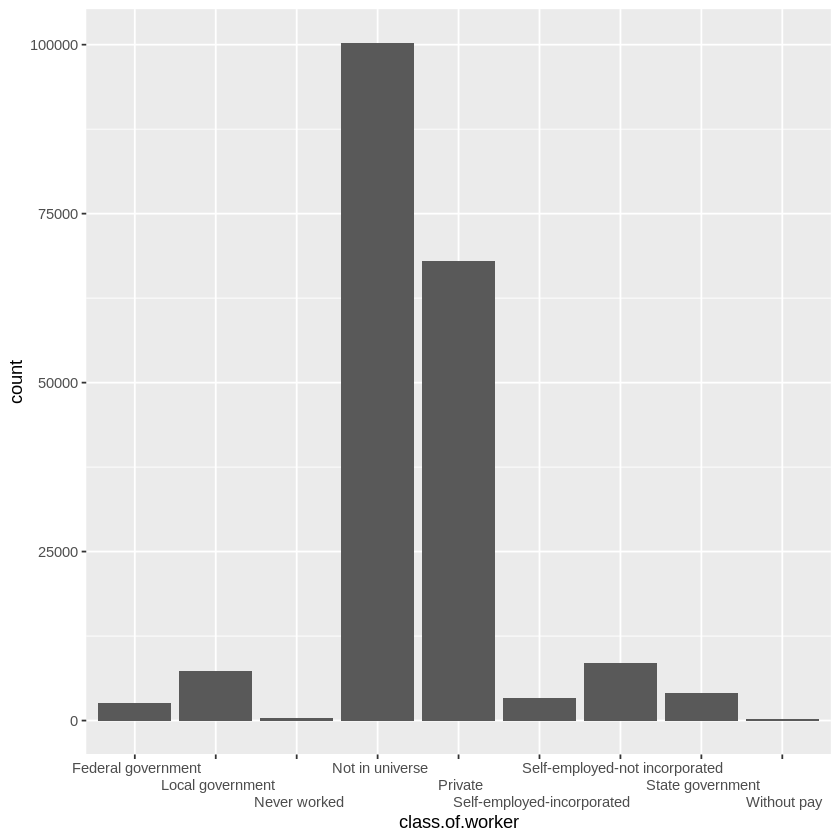

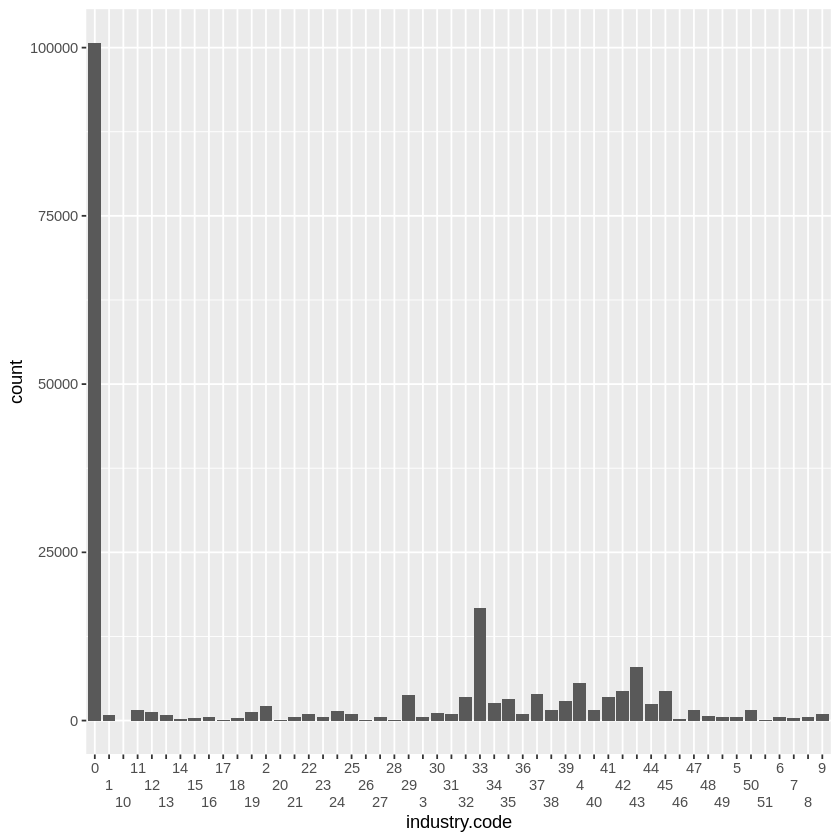

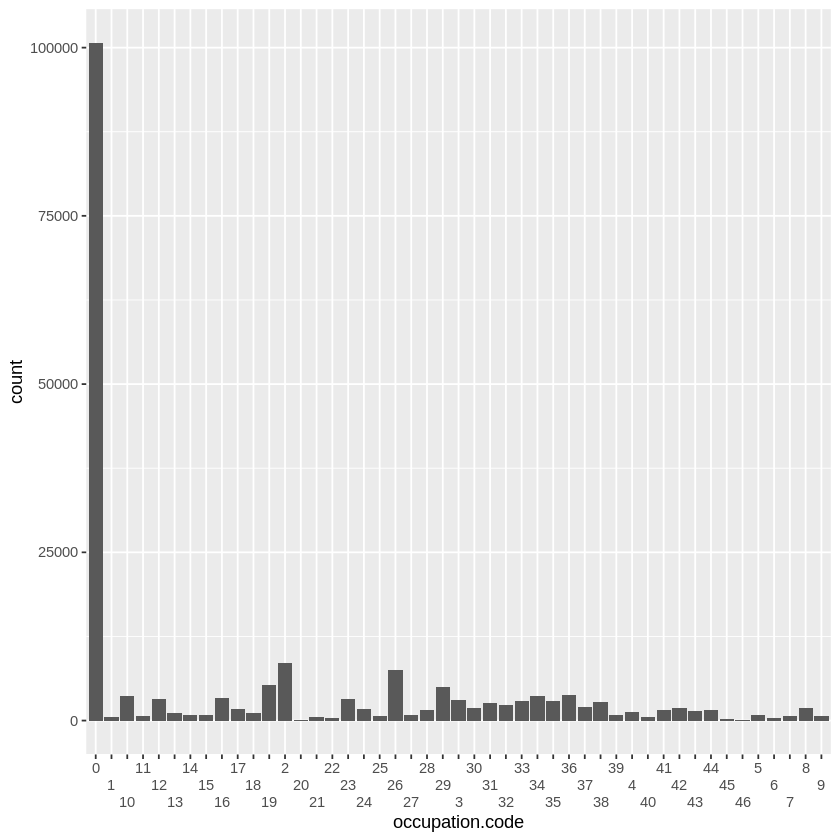

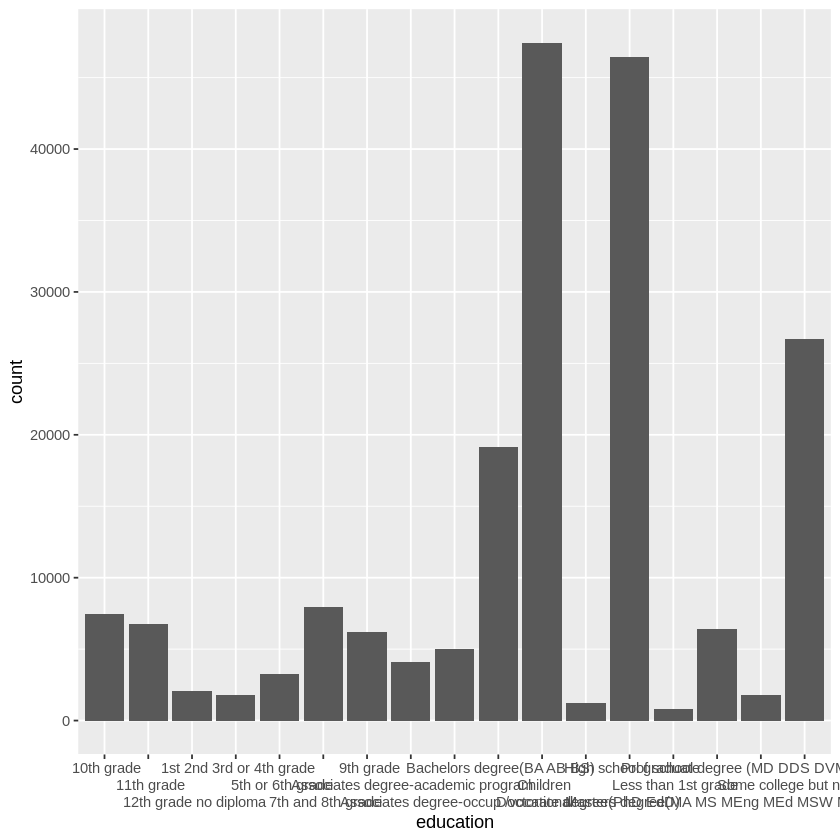

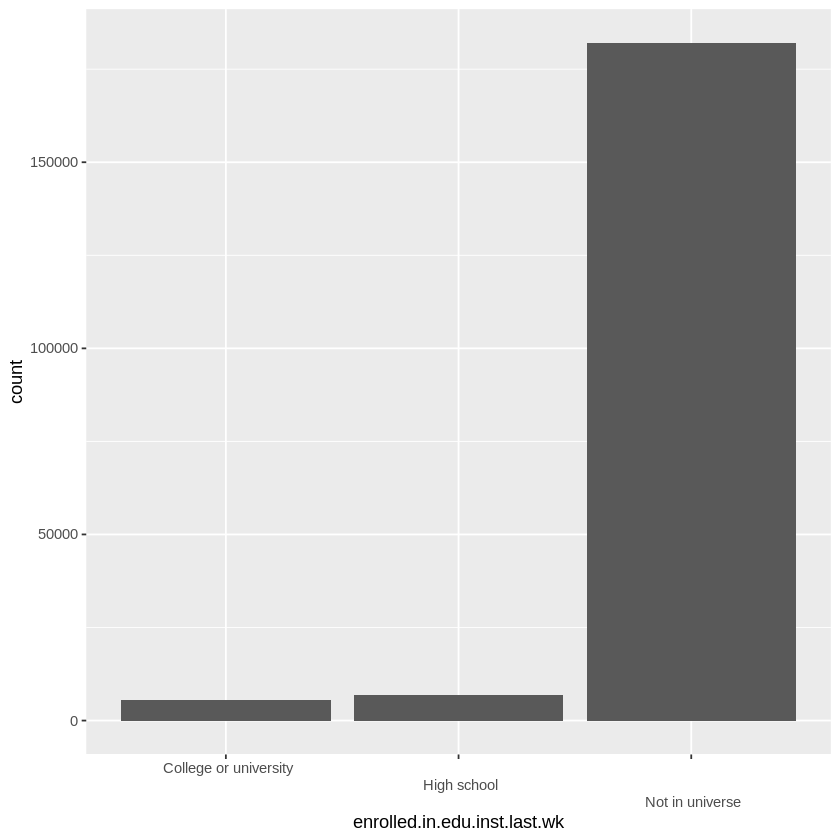

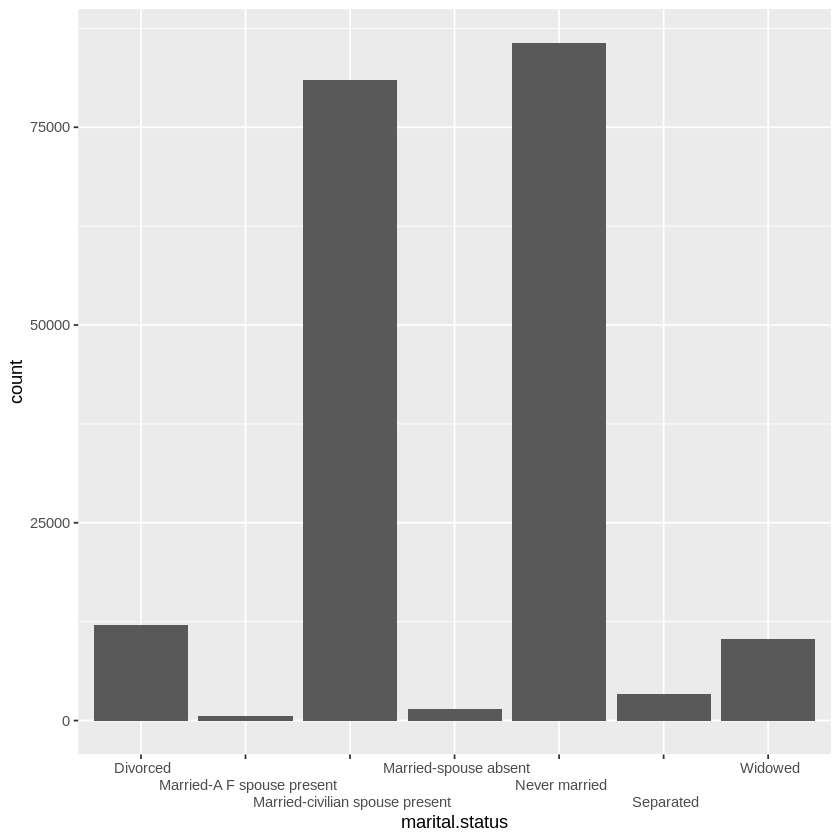

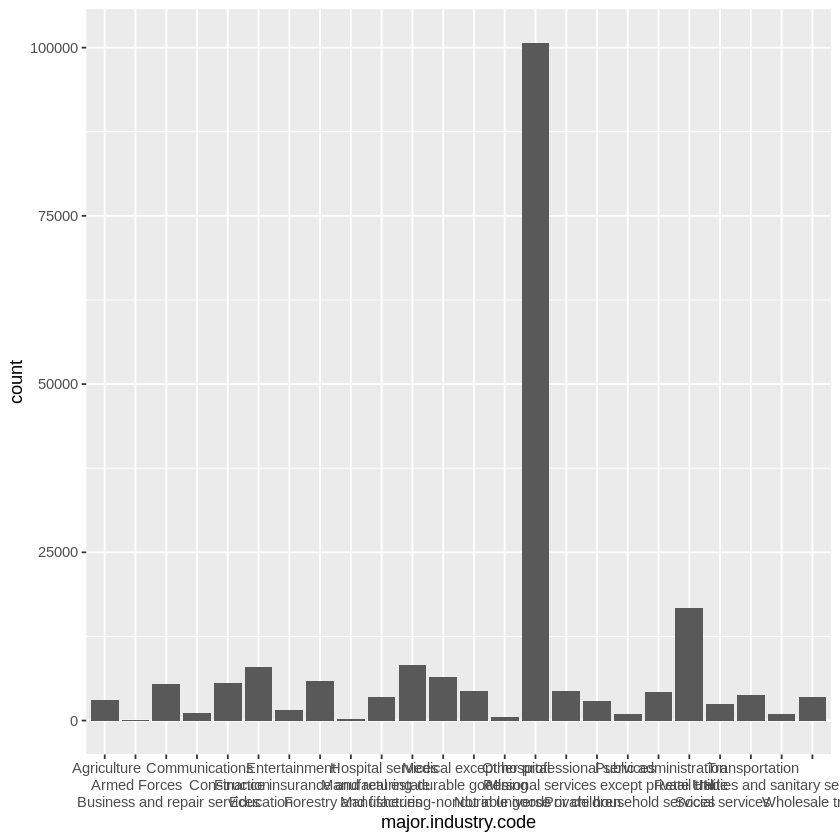

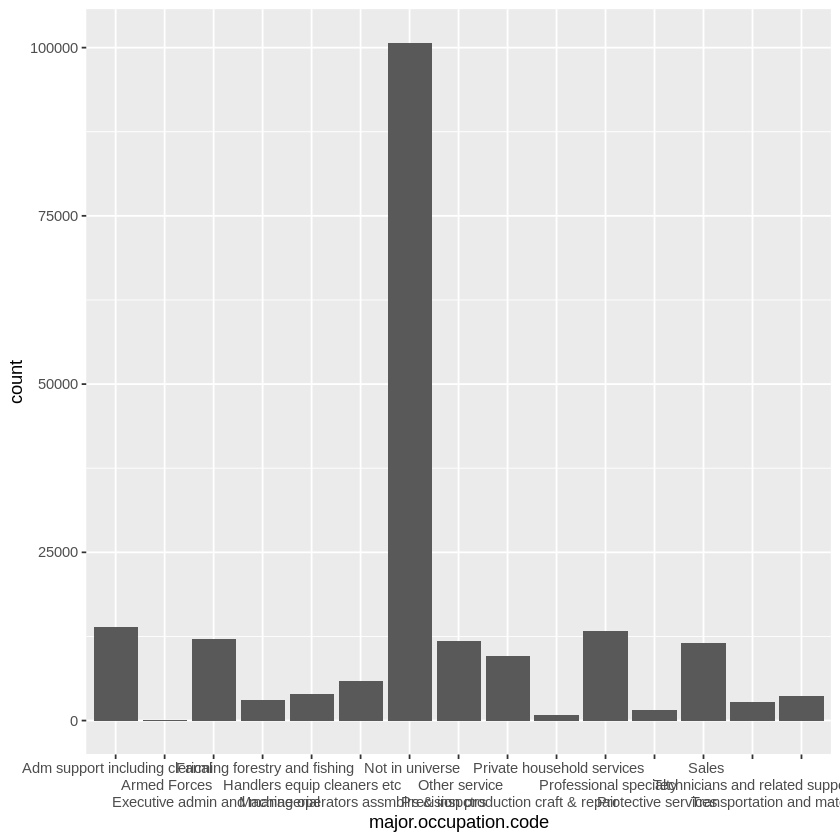

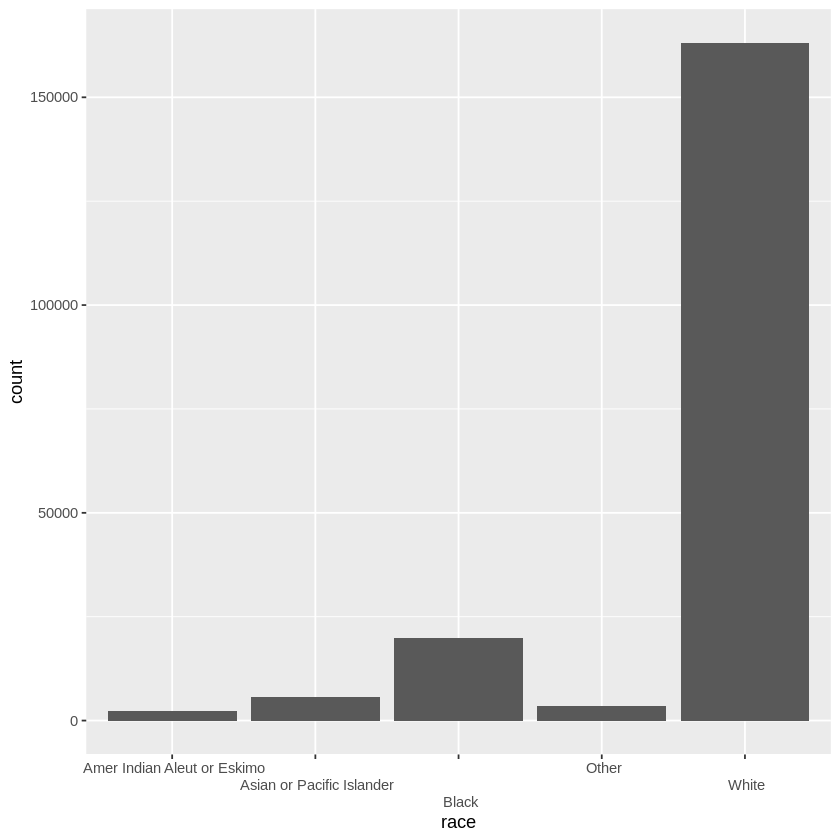

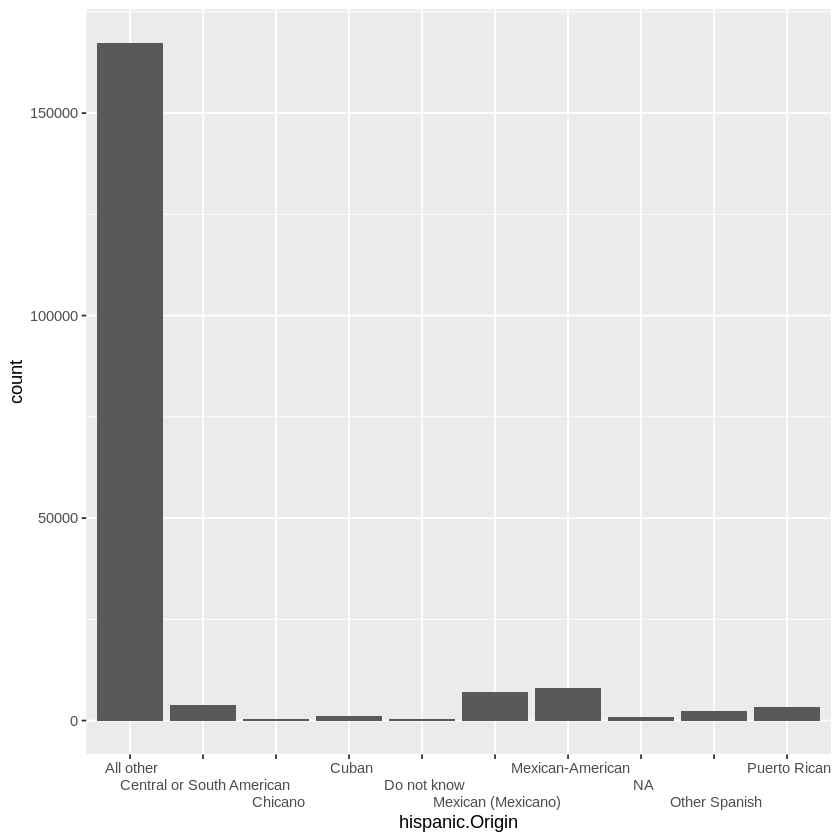

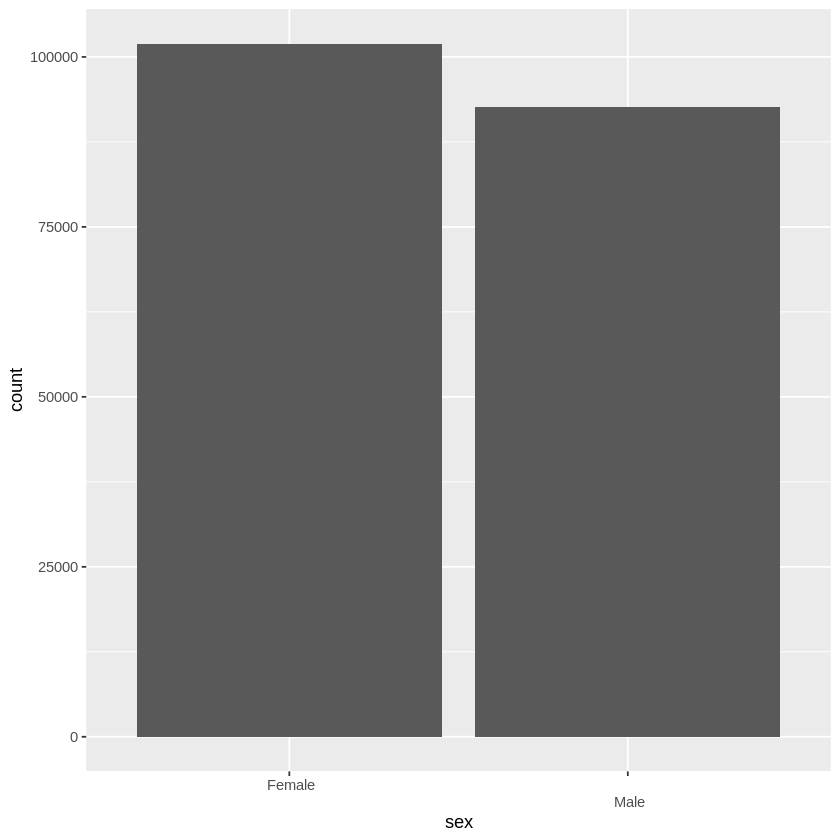

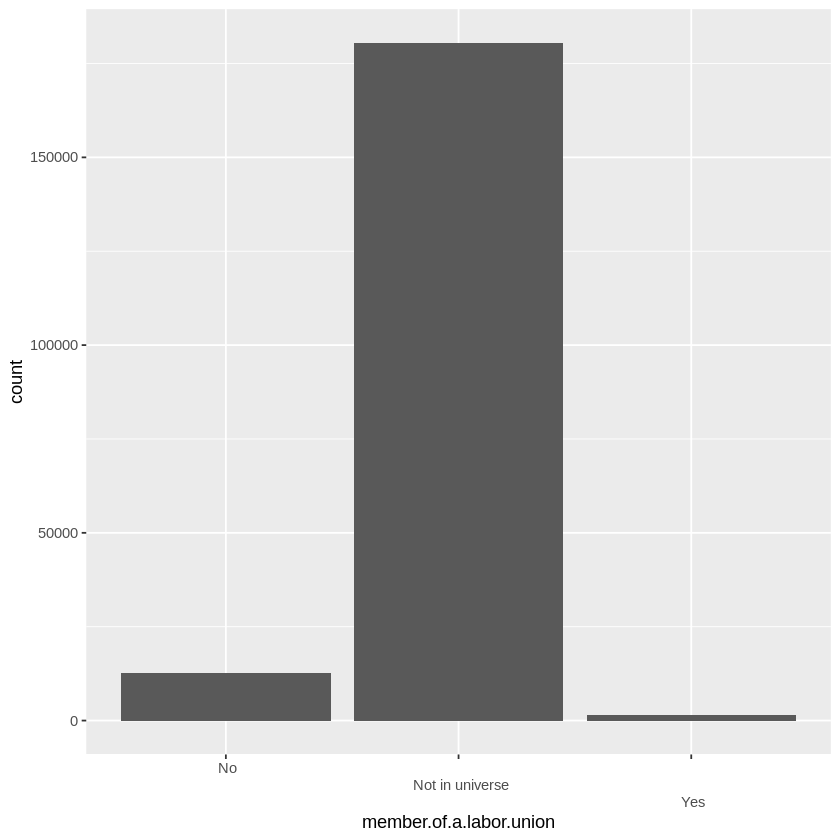

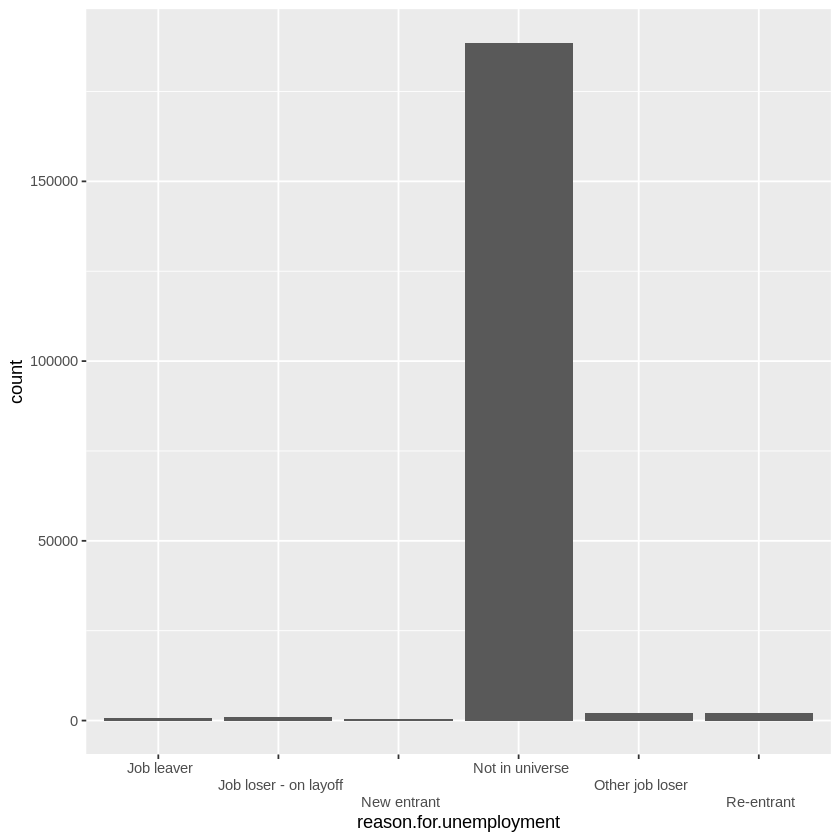

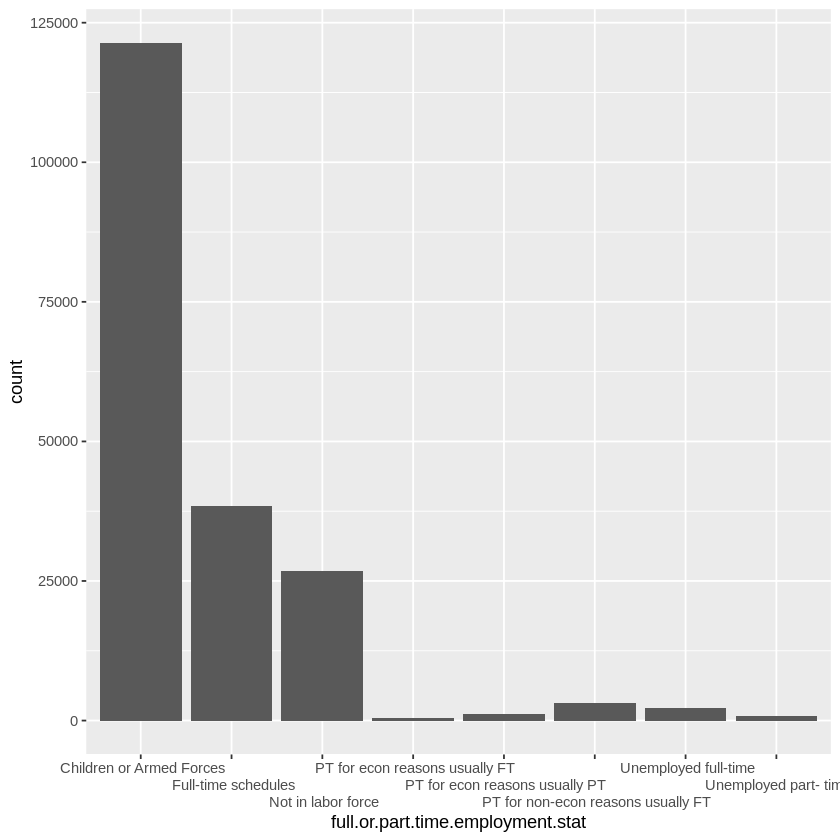

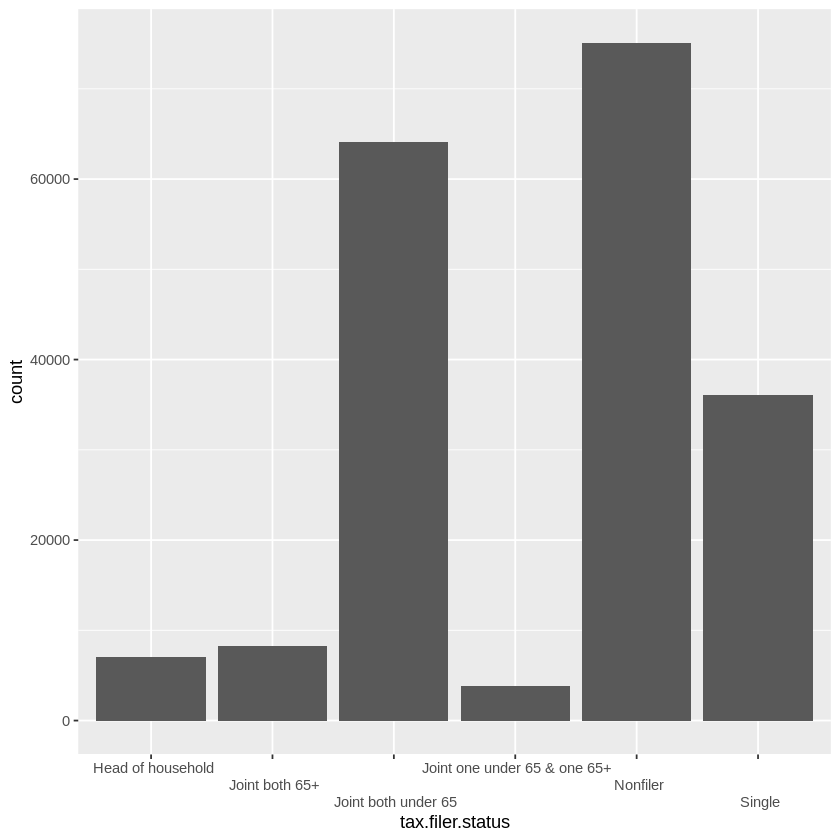

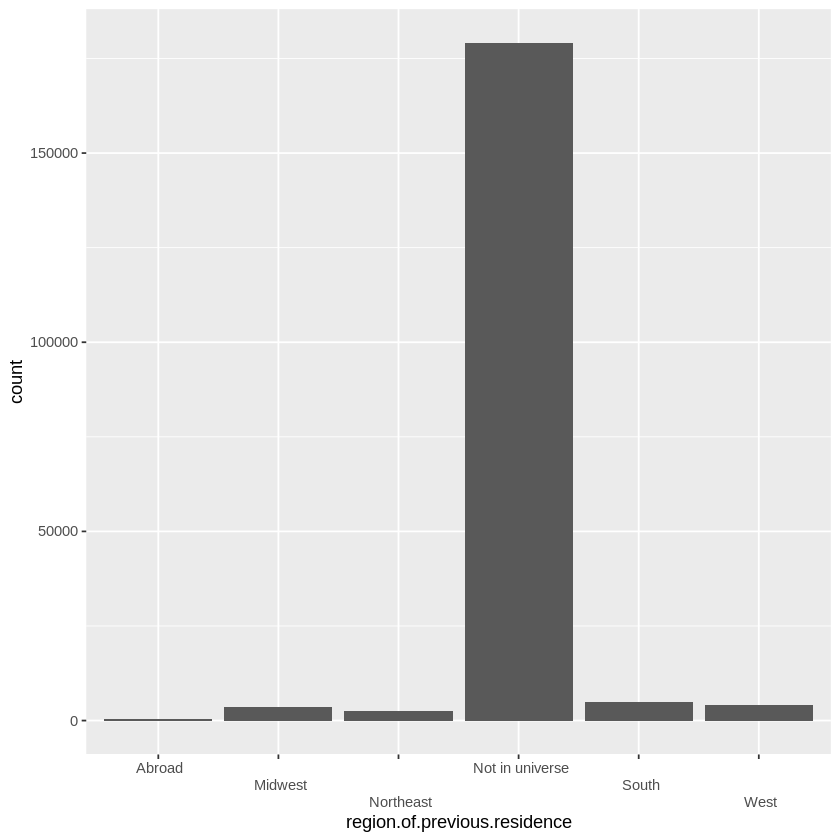

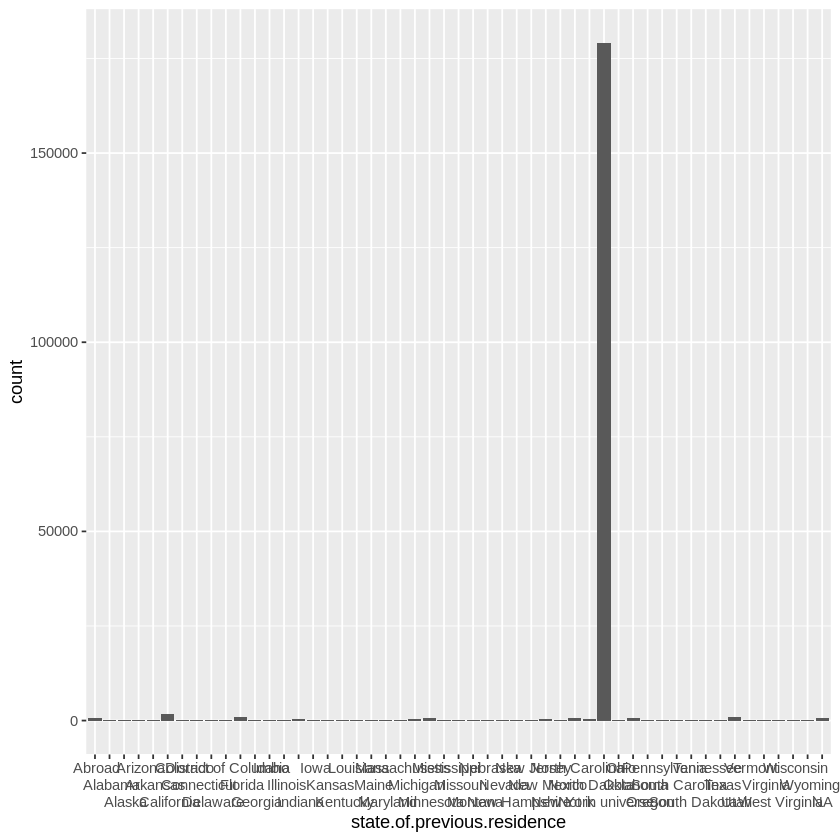

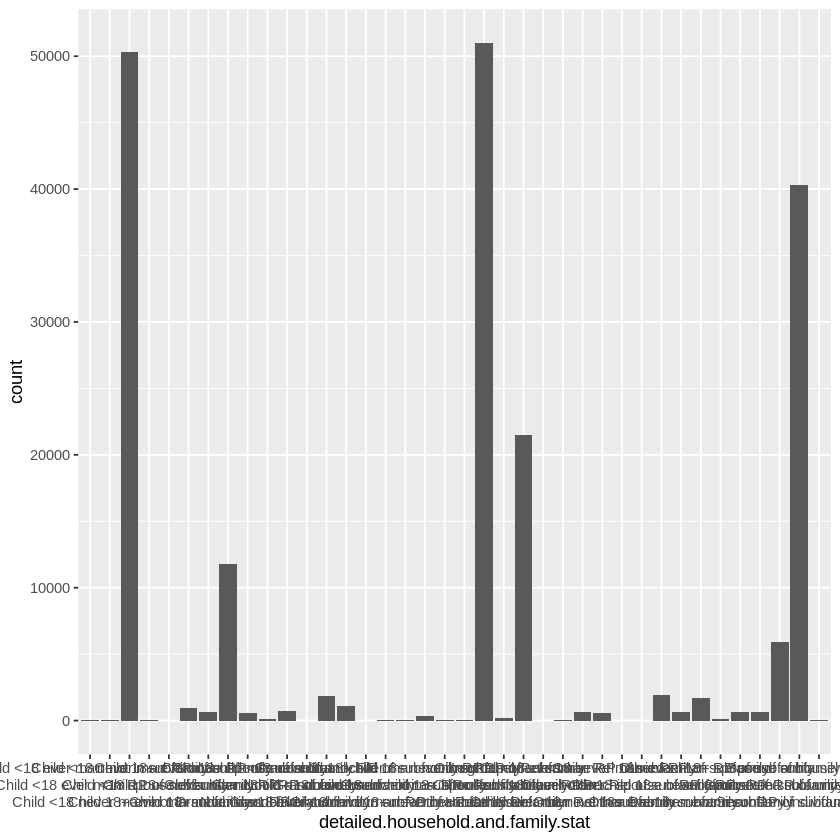

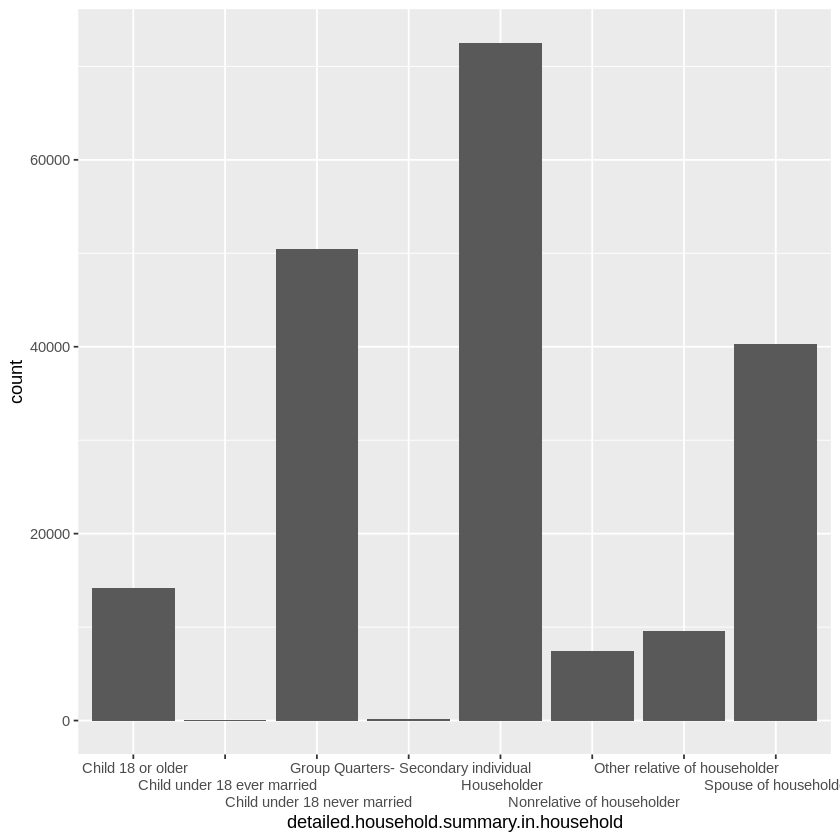

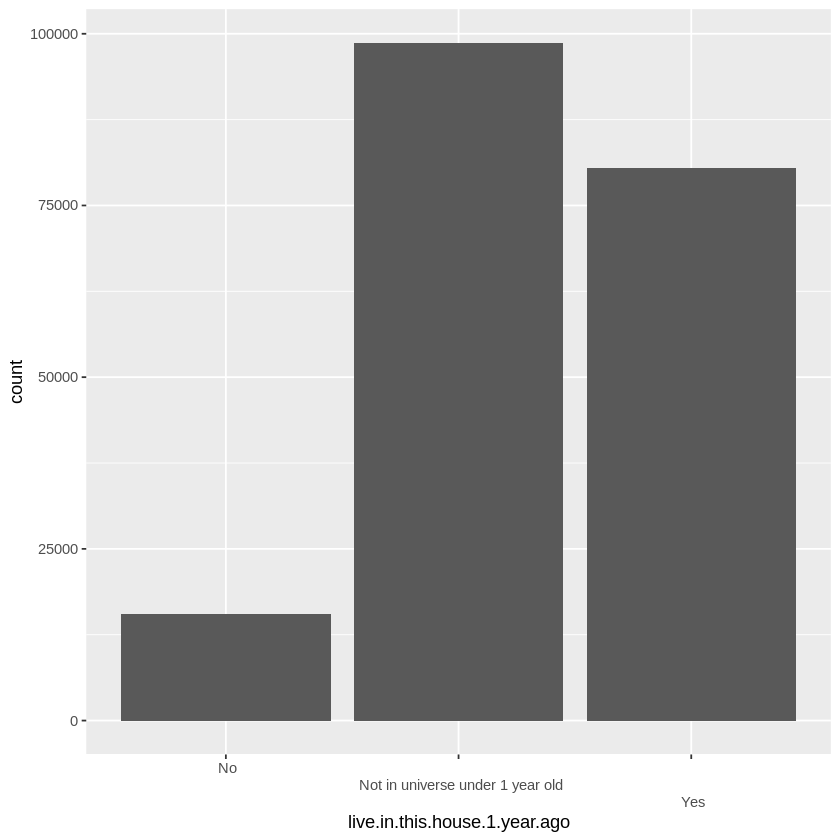

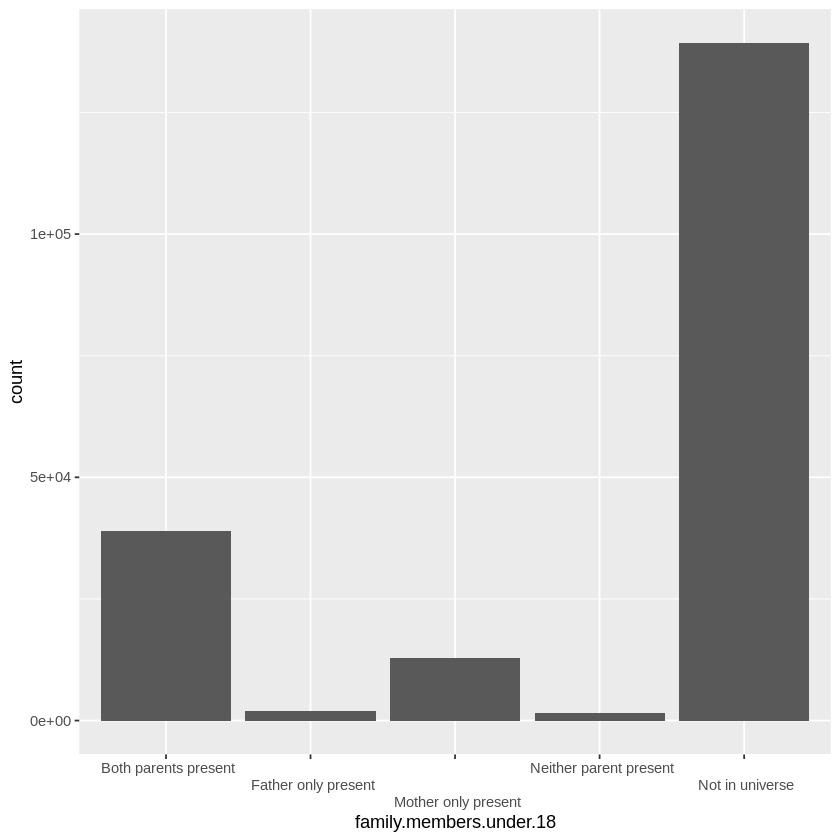

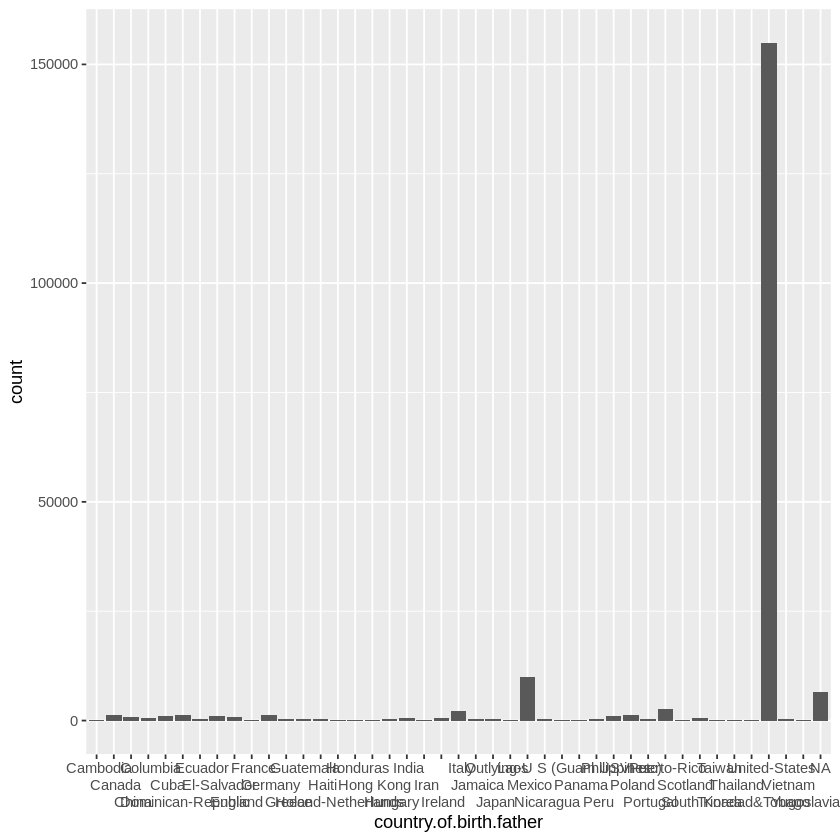

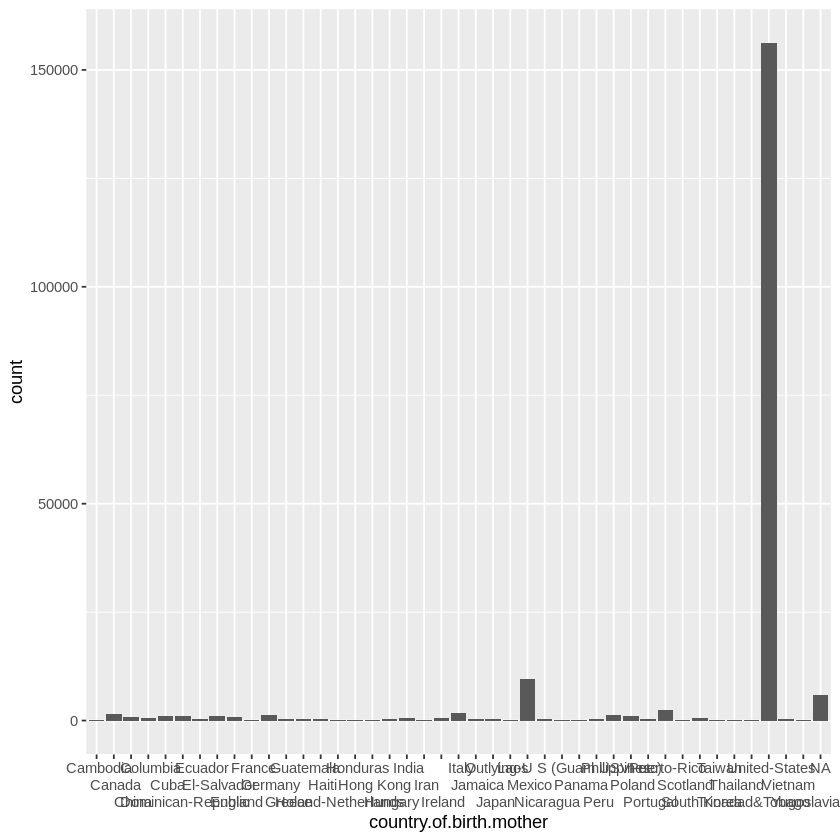

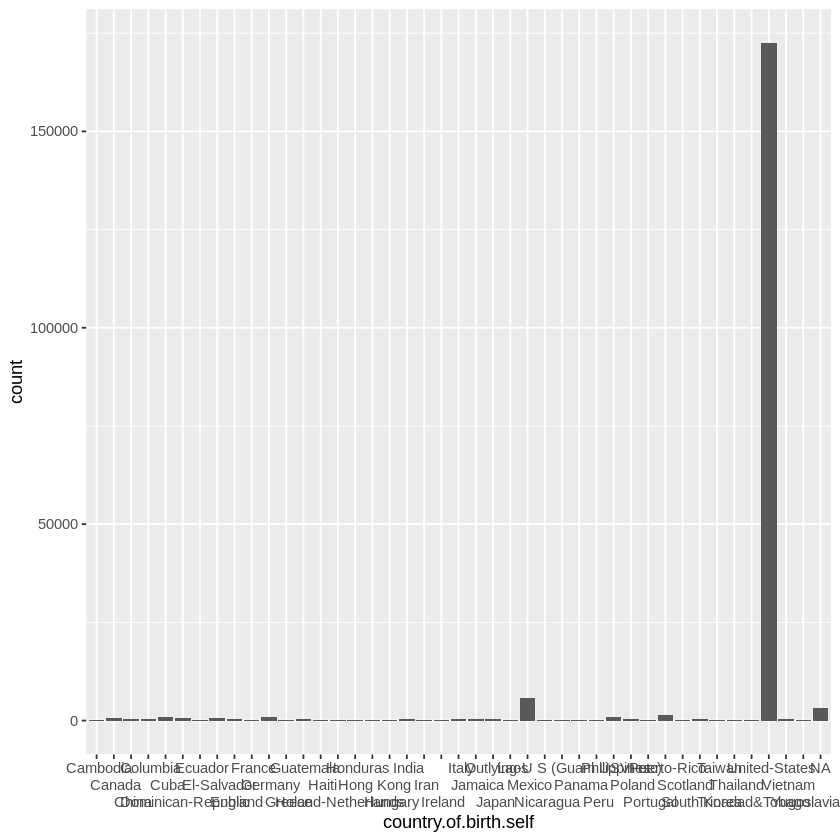

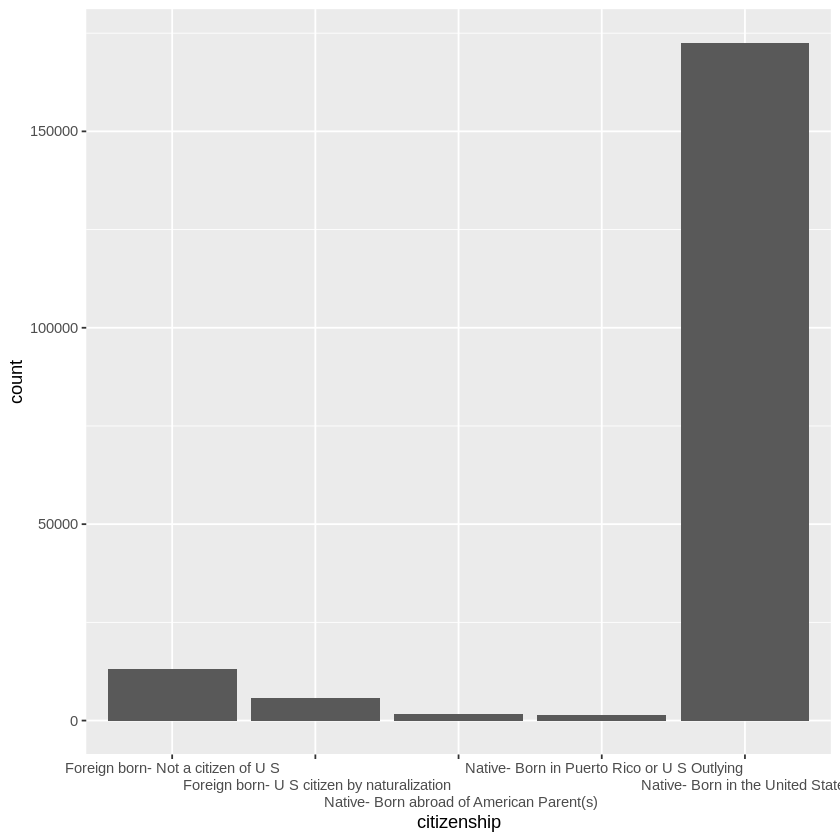

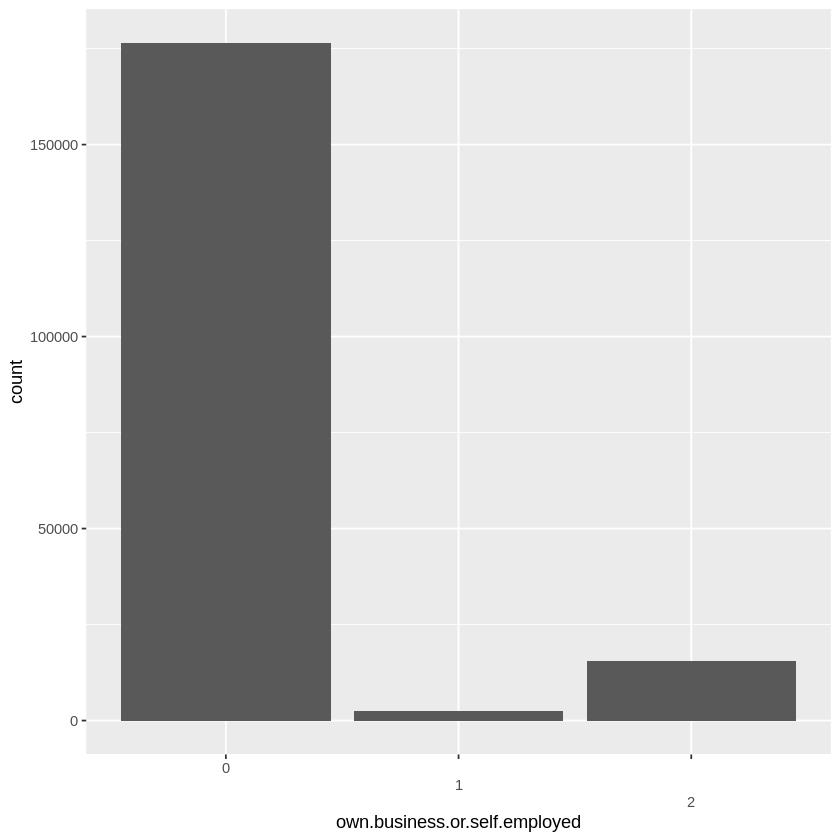

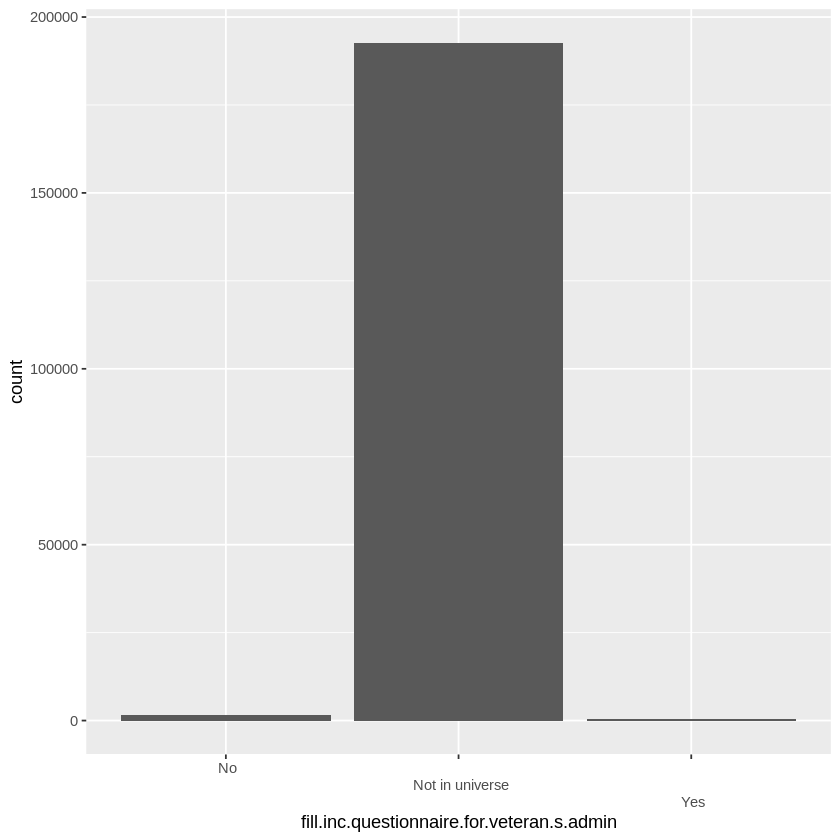

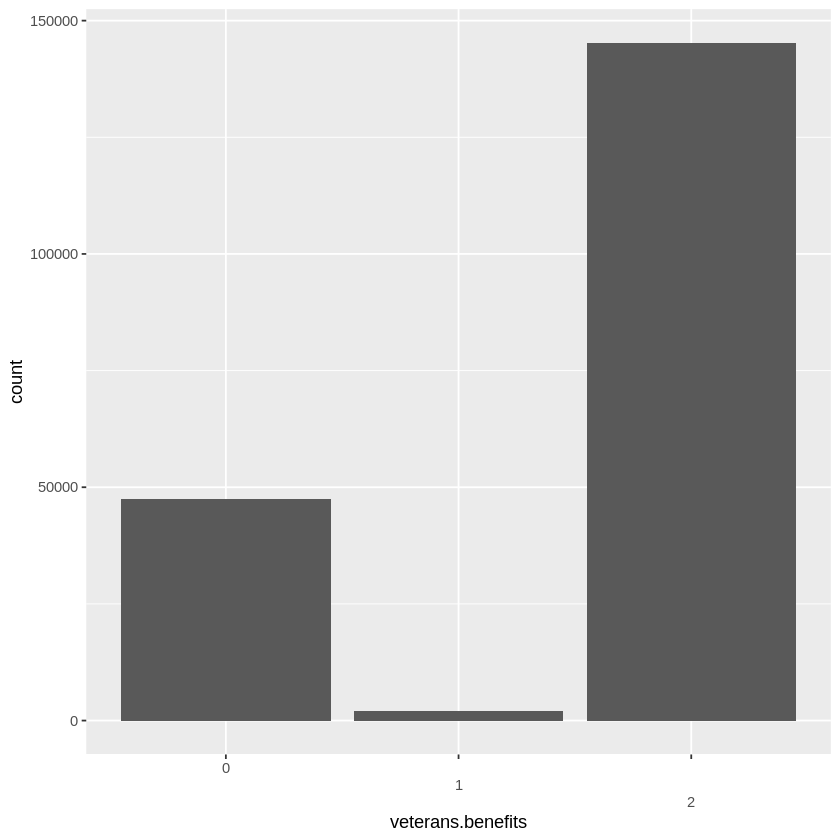

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]

[[26]]

[[27]]

[[28]]

[[29]]

[[30]]


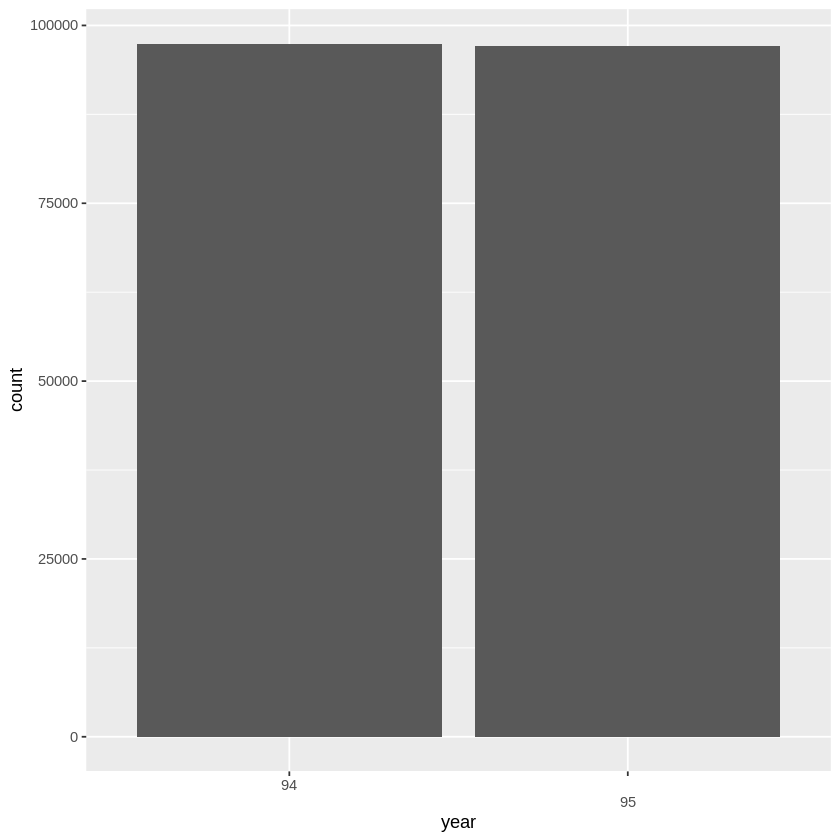

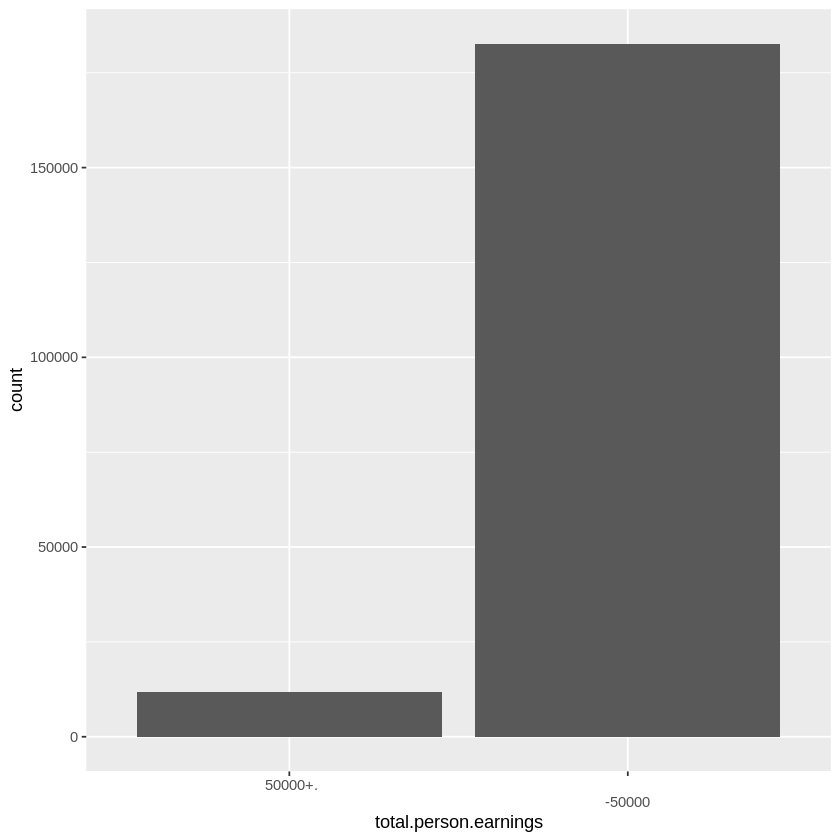

In [14]:
# Due to the high amount of variables present. A quick lapply() is done to obtain results for all the categorical variables. 

my_plots <- lapply(names(Train_data[Cat_var]), function(var_x){
  p <- 
    ggplot(Train_data[Cat_var]) +
    aes_string(var_x)+ geom_bar()+
  scale_x_discrete(guide = guide_axis(n.dodge=3))
  } )

  my_plots

  # By looking over the graphs it is clear that there is alot of imbalance present within some of the categorical independent variables. 
  # Therefore a more granular approach is requrired to look at each categorical feature and to prepare the variables accordingly.   

**Checking for near zero variance**

In [15]:
# Understanding that there is a huge imbalance in some of the the categorical varaibles. I used nearZeroVar to identify any near zero variance predictors. 
# The is to see if there are very few unique values reltive to the number of samples and the ratio of frquency between the most and the second most common category. 
# Accordingly then more focus will need to be put into their repsective data preparation or if no information then the removal of the variable.   

# This checks for a freqCut ratio of 19[frequency of the most prevalent value over the second most frequent value must be above 19] and a unique value cut of 10% [second most common cateogory is atleast 10% of the dataset]
colnames(Train_data[c(nearZeroVar(Train_data,freqCut = 19,uniqueCut = 10))])

colnames(Train_data[c(nearZeroVar(Train_data,freqCut = 4,uniqueCut = 10))])

# However as this funciton is set it is not robust for cateogries for many bins with low values as it only consideres top two. Such as from the initial data summary there is a high imbalance between education, but not present in nearZeroVar. 
#This is used with the my visual referene for each distribution graph above to get a quick idea of variables to pay attention to. 

[1] "wage.per.hour"                             
 [2] "enrolled.in.edu.inst.last.wk"              
 [3] "hispanic.Origin"                           
 [4] "reason.for.unemployment"                   
 [5] "capital.gains"                             
 [6] "capital.losses"                            
 [7] "divdends.from.stocks"                      
 [8] "region.of.previous.residence"              
 [9] "state.of.previous.residence"               
[10] "country.of.birth.self"                     
[11] "fill.inc.questionnaire.for.veteran.s.admin"

[1] "industry.code"                             
 [2] "occupation.code"                           
 [3] "wage.per.hour"                             
 [4] "enrolled.in.edu.inst.last.wk"              
 [5] "major.industry.code"                       
 [6] "major.occupation.code"                     
 [7] "race"                                      
 [8] "hispanic.Origin"                           
 [9] "member.of.a.labor.union"                   
[10] "reason.for.unemployment"                   
[11] "capital.gains"                             
[12] "capital.losses"                            
[13] "divdends.from.stocks"                      
[14] "region.of.previous.residence"              
[15] "state.of.previous.residence"               
[16] "country.of.birth.father"                   
[17] "country.of.birth.mother"                   
[18] "country.of.birth.self"                     
[19] "citizenship"                               
[20] "own.business.or.self.employed"             
[21] "fill.inc.questionnaire.for.veteran.s.admin"
[22] "total.person.earnings"

### Occupation

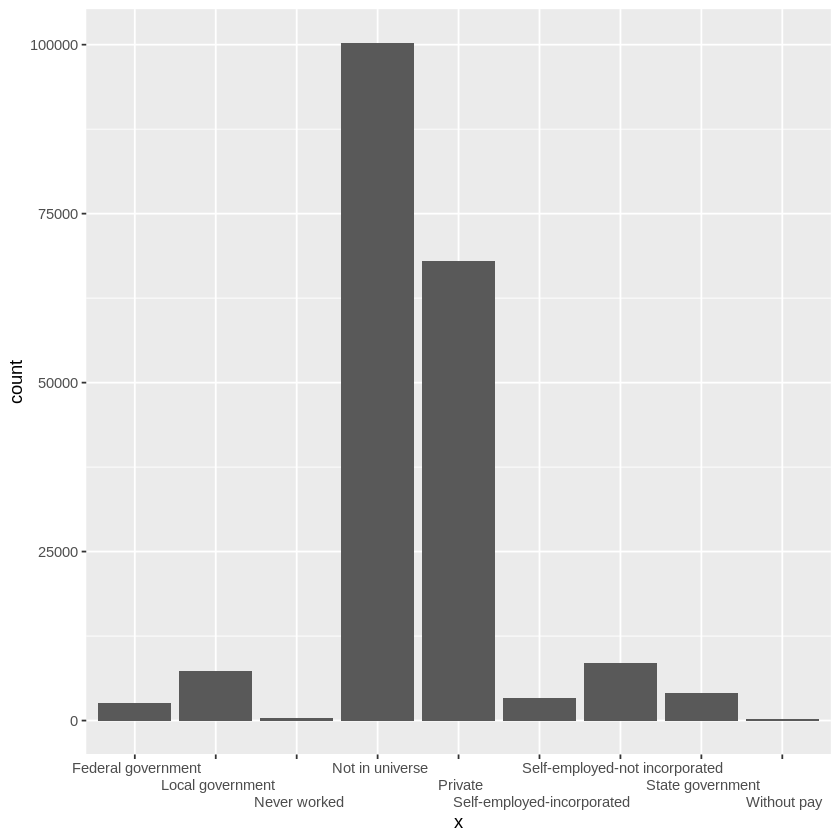

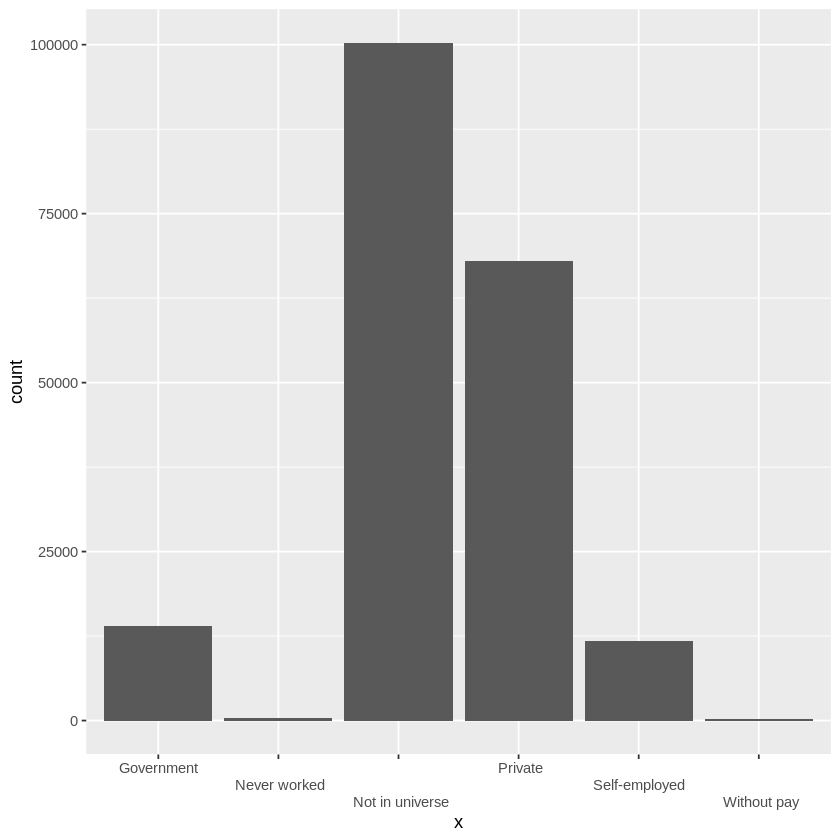

$statistic
X-squared 
 11345.32

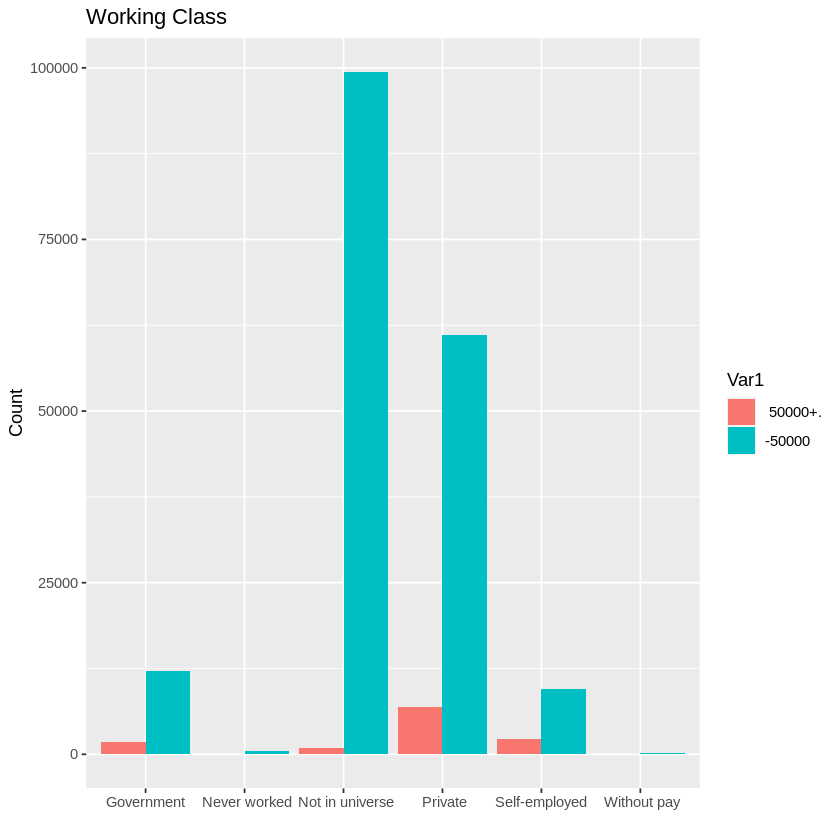

In [16]:
# Class of worker

ggplot(Train_data) +  aes_string(Train_data$class.of.worker)+ geom_bar()+ scale_x_discrete(guide = guide_axis(n.dodge=3))

# "Not in unviverse" is the dominant factor present. This is expected as there is a high propotion of data of young people who do not work. 
# The dominant class of worker is in the private sector and there are different government workers slit. These can be joined to reduce imbalance and reduce cardinality. 
# It is to be considered that the factors that are combined had low counts.

# Binning the factors
Train_data$class.of.worker <- fct_collapse(Train_data$class.of.worker,
                                           "Government" = c(' Federal government',' Local government',' State government'),
                                           "Self-employed" = c(' Self-employed-incorporated',' Self-employed-not incorporated'))

ggplot(Train_data) +  aes_string(Train_data$class.of.worker)+ geom_bar()+ scale_x_discrete(guide = guide_axis(n.dodge=3))

# Comparing imcome with class of worker
counts <- table(Train_data$total.person.earnings, Train_data$class.of.worker) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Working Class", x="", y = "Count")

# It can be clearly seen that the majority of the people who make >$50000 is for private worker, followed by self emplyed and then goverment. 
# As expected anyone who has never worked ot is without work doesn't make >$50000
# Something interesting is the "not in universe" has some people making >+50000, which shows that there might be a different class of worker present 

# Chi Square Test 
chisq.test(Train_data$class.of.worker,Train_data$total.person.earnings)[1]

# This test was done test if the factor is relevant to the target varaible and the x- squared will be used for feature selection to reduce computation stress when modeling. 
# x-squared = 11345


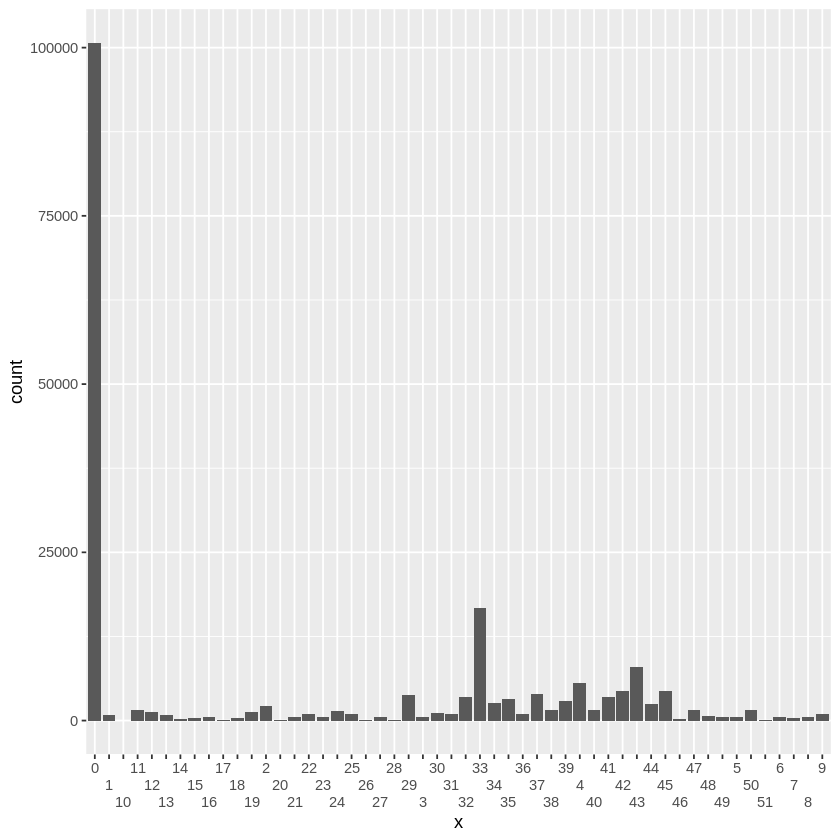

Warning message in chisq.test(Train_data$industry.code, Train_data$total.person.earnings):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$industry.code and Train_data$total.person.earnings
X-squared = 17374, df = 51, p-value < 2.2e-16


Warning message in chisq.test(Train_data$major.industry.code, Train_data$total.person.earnings):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$major.industry.code and Train_data$total.person.earnings
X-squared = 15652, df = 23, p-value < 2.2e-16


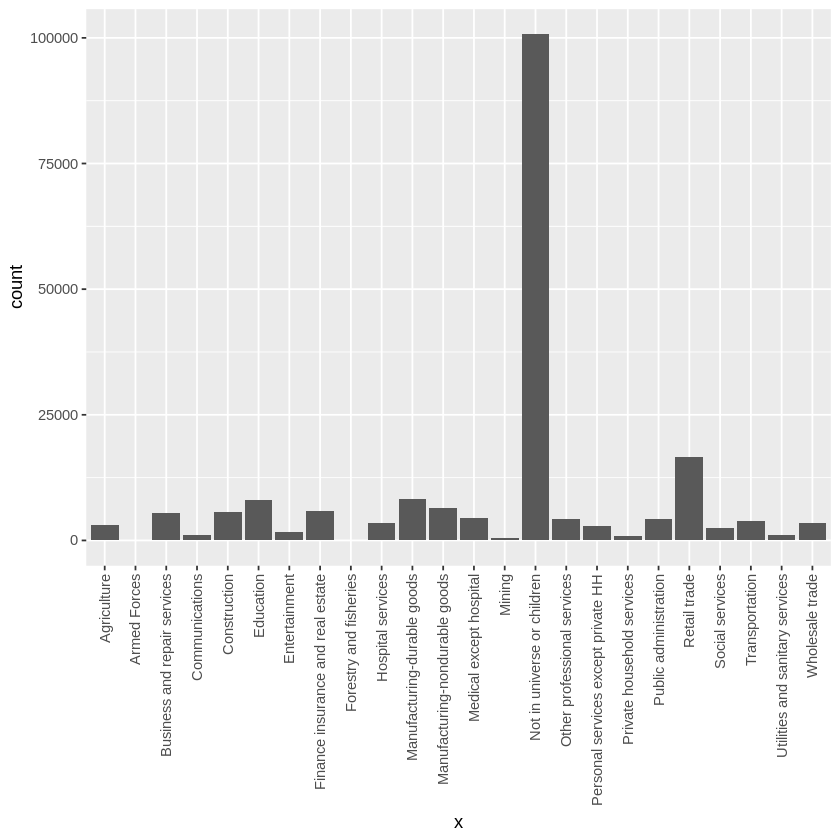

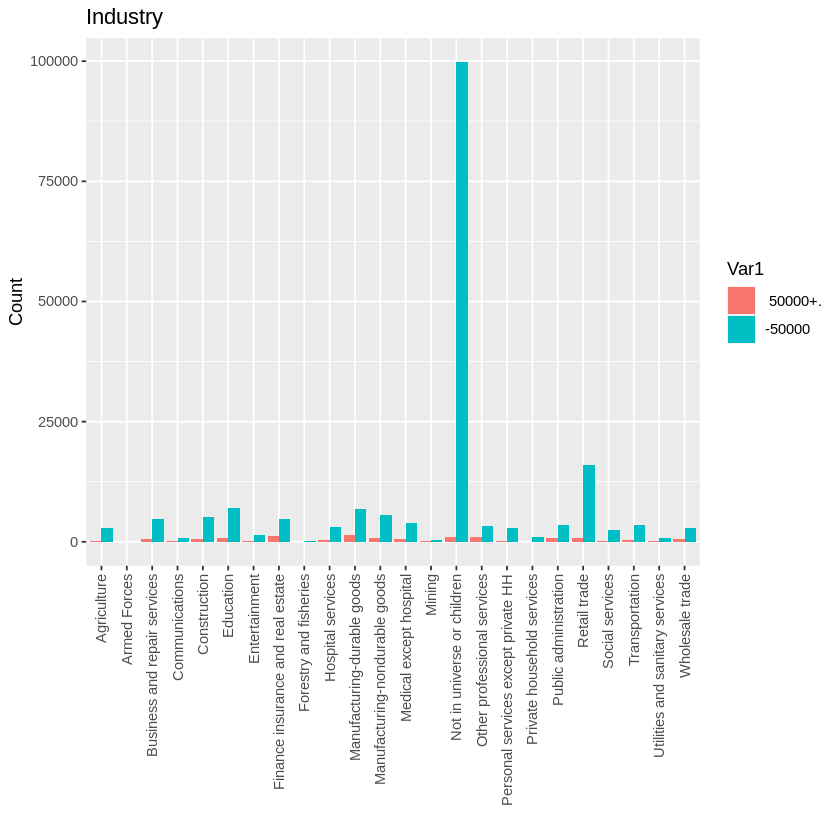

In [17]:
#Industry code and major industry code 

ggplot(Train_data) +  aes_string(Train_data$industry.code)+ geom_bar()+ scale_x_discrete(guide = guide_axis(n.dodge=3))

ggplot(Train_data) +  aes_string(Train_data$major.industry.code)+ geom_bar() +  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# The industry data is highly imbalanced due to the "Not in Universe" column. 
# Retail and Trade has the highest count in terms of major industry, with the lowest being mining, fishing and armed forces. 

# Chi Square Test 
chisq.test(Train_data$industry.code,Train_data$total.person.earnings)
chisq.test(Train_data$major.industry.code,Train_data$total.person.earnings)

# To improve it would be beneficial to to bin some of the industies together to reduce cardinality in the future and also remove the chiq.test error
# For this pipeline instead of binning I will carry out the chiq.test only. 
# As both the features reject the Null Hypothesis I will keep the "major.industry.code" as it has less factors to reduce cardinality and reduce dimesnions. 

#X-squared = 15652

# Comparing imcome with industy 
counts <- table(Train_data$total.person.earnings, Train_data$major.industry.code) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Industry", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# In the major industry factors the >$50000 income was most in manufacturing durable goods


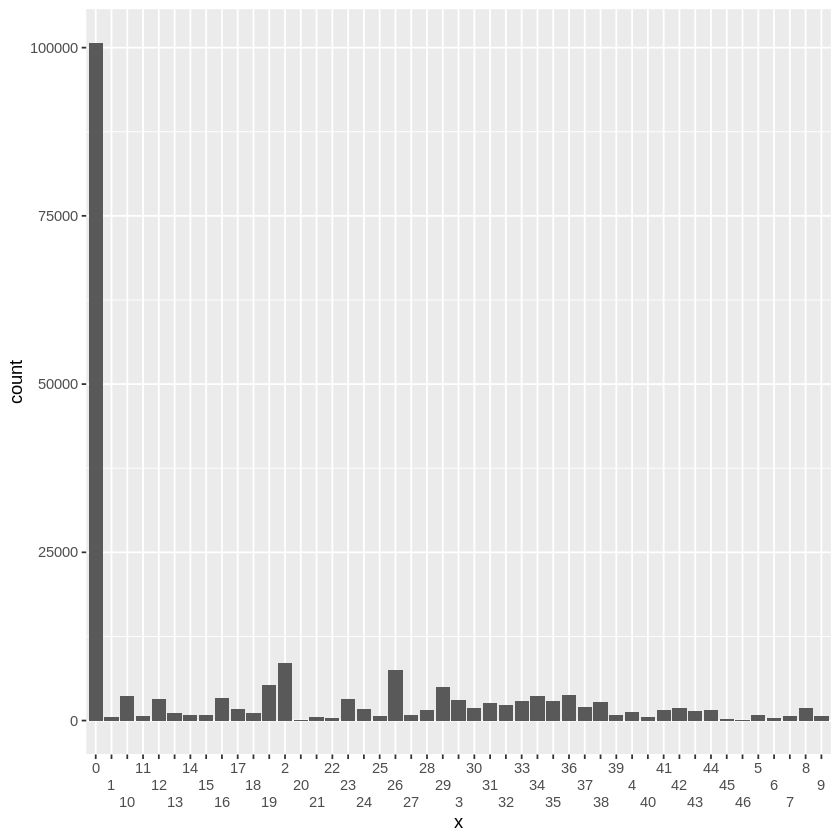

Warning message in chisq.test(Train_data$occupation.code, Train_data$total.person.earnings):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$occupation.code and Train_data$total.person.earnings
X-squared = 38557, df = 46, p-value < 2.2e-16


Warning message in chisq.test(Train_data$major.occupation.code, Train_data$total.person.earnings):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$major.occupation.code and Train_data$total.person.earnings
X-squared = 27121, df = 14, p-value < 2.2e-16


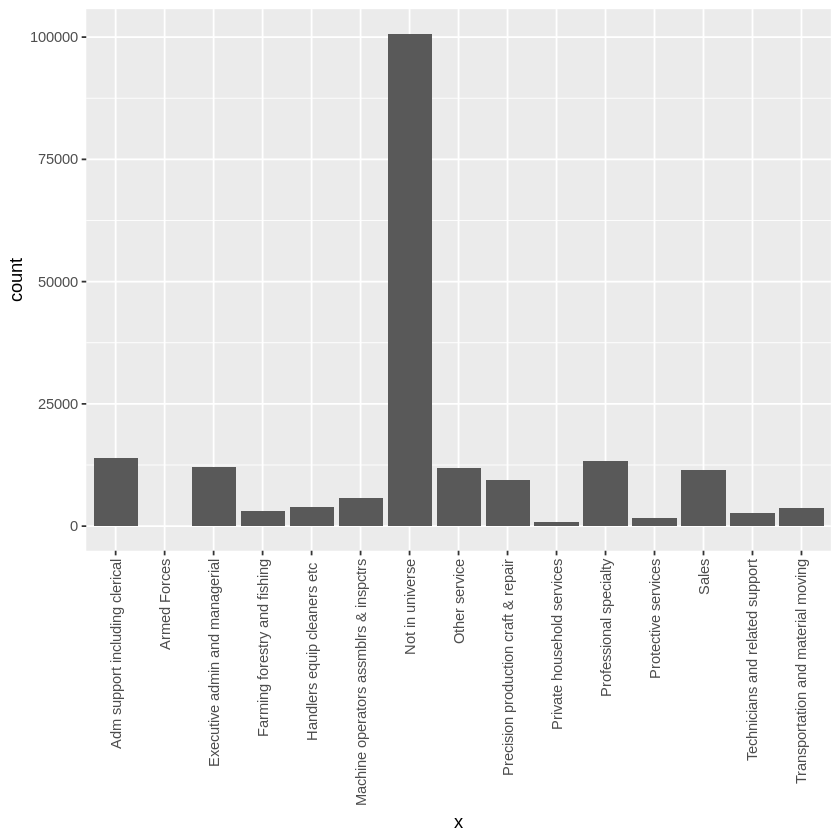

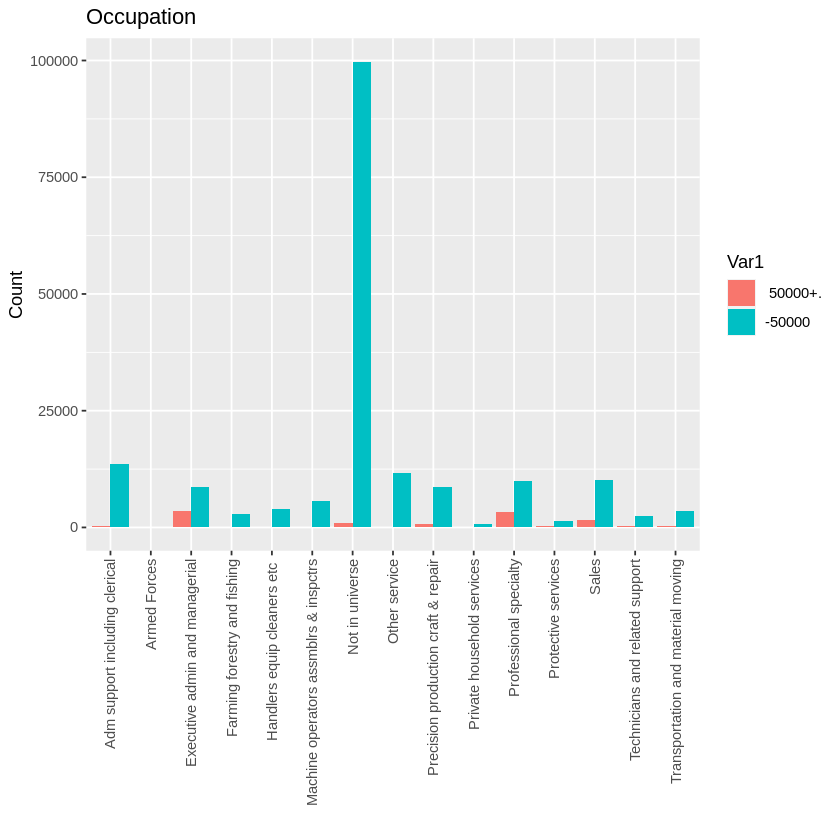

In [18]:
#"occupation.code" major occupation code

ggplot(Train_data) +  aes_string(Train_data$occupation.code)+ geom_bar()+ scale_x_discrete(guide = guide_axis(n.dodge=3))
ggplot(Train_data) +  aes_string(Train_data$major.occupation.code)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$occupation.code,Train_data$total.person.earnings)
chisq.test(Train_data$major.occupation.code,Train_data$total.person.earnings)

# Both the occupation features rejected the null hypothesis, demonstrating link. However, for the rest of the dataset I will only use major occupation code only. 
# X-squared = 27121

# Comparing imcome with major occupation code
counts <- table(Train_data$total.person.earnings, Train_data$major.occupation.code) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Most higher income was made in managerial and specialist occupations as expected




	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$member.of.a.labor.union
X-squared = 1112.9, df = 2, p-value < 2.2e-16


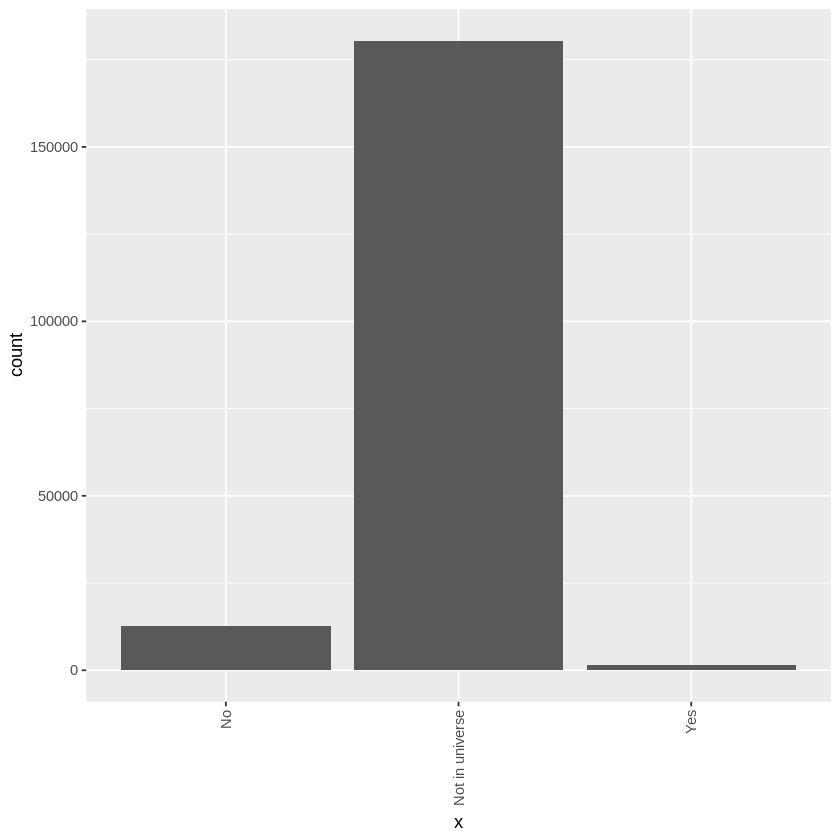

In [19]:
#member.of.a.labor.union

ggplot(Train_data) +  aes_string(Train_data$member.of.a.labor.union)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$member.of.a.labor.union)

# Precaution is needed here as there is an error of “Chi-squared approximation may be incorrect” due to some factors being really low.
#X-squared = 1112.9



	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$reason.for.unemployment
X-squared = 151.54, df = 5, p-value < 2.2e-16


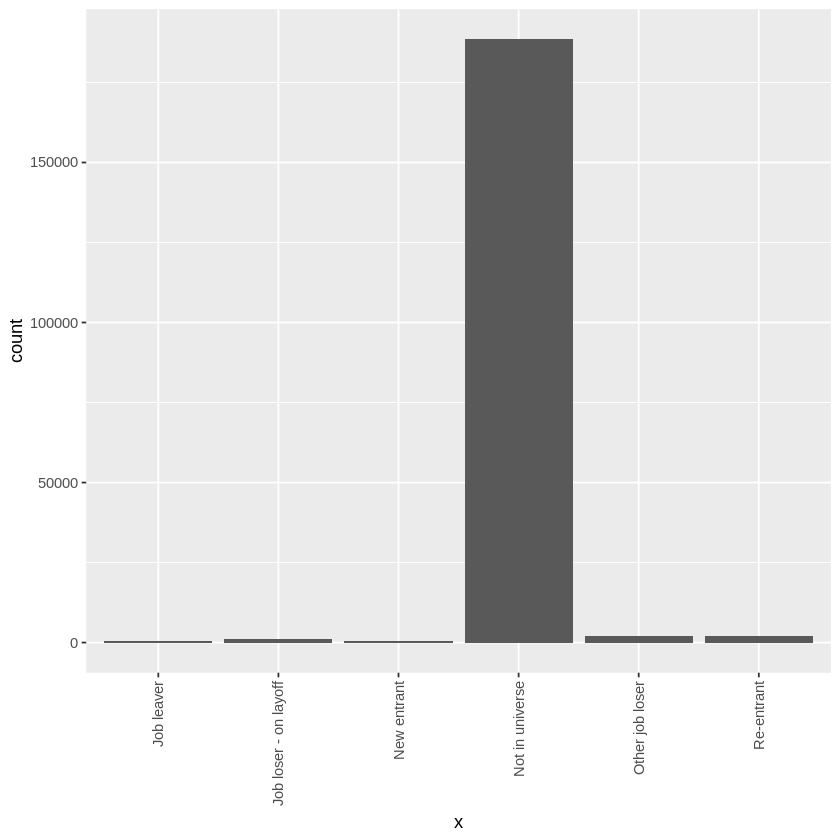

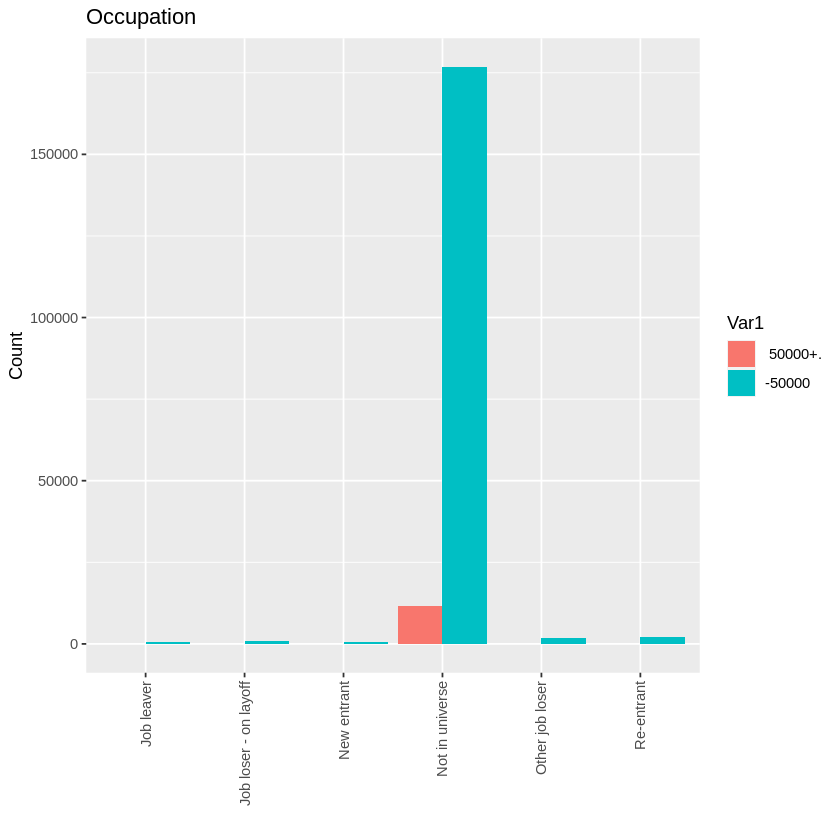

In [20]:
#reason.for.unemployment

ggplot(Train_data) +  aes_string(Train_data$reason.for.unemployment)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$reason.for.unemployment)

# Both the occupation features rejected the null hypothesis, demonstrating link. However, for the rest of the dataset I will only use major occupation code only. 
# X-squared = 151.54 

# Comparing imcome with major occupation code
counts <- table(Train_data$total.person.earnings, Train_data$reason.for.unemployment) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# there is not much variation present, not a good feature for training. Doesn't provide much information.

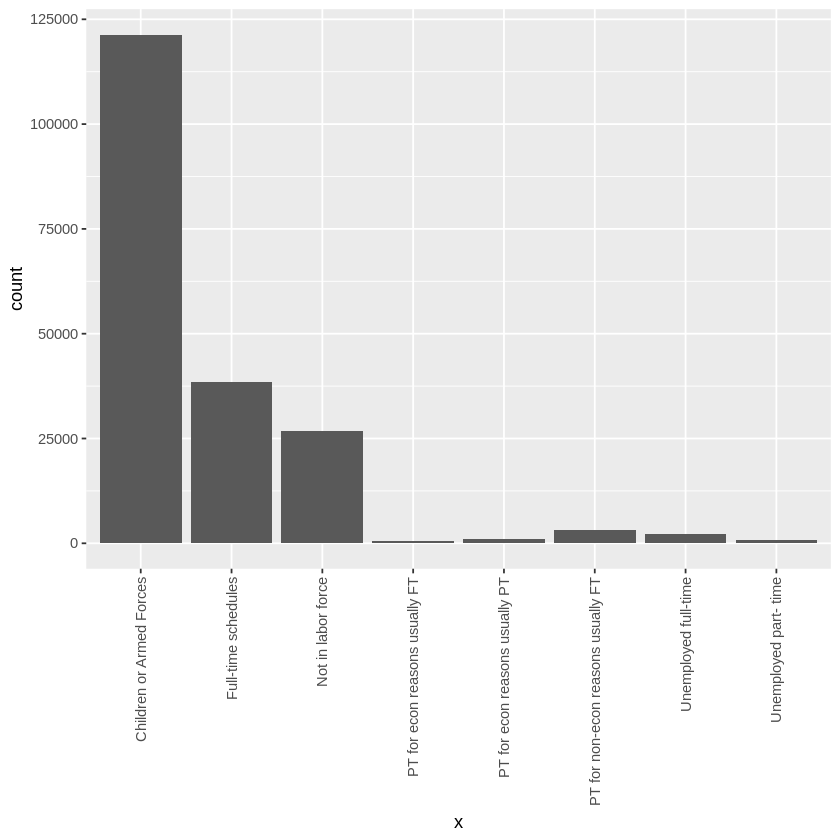


	Pearson's Chi-squared test

data:  Train_data$full.or.part.time.employment.stat and Train_data$total.person.earnings
X-squared = 5137.4, df = 5, p-value < 2.2e-16


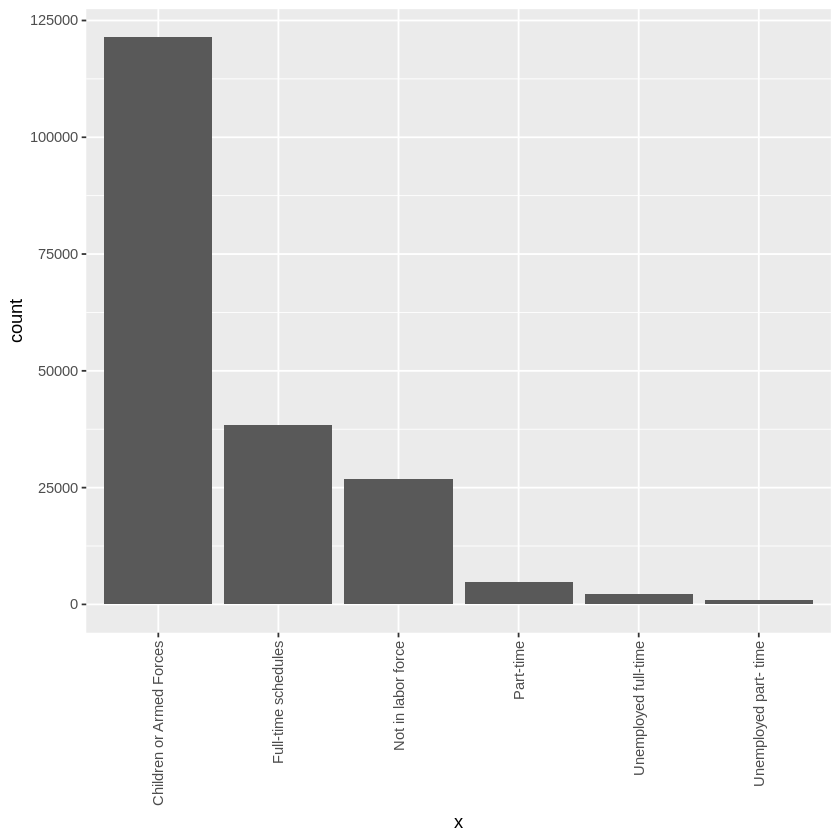

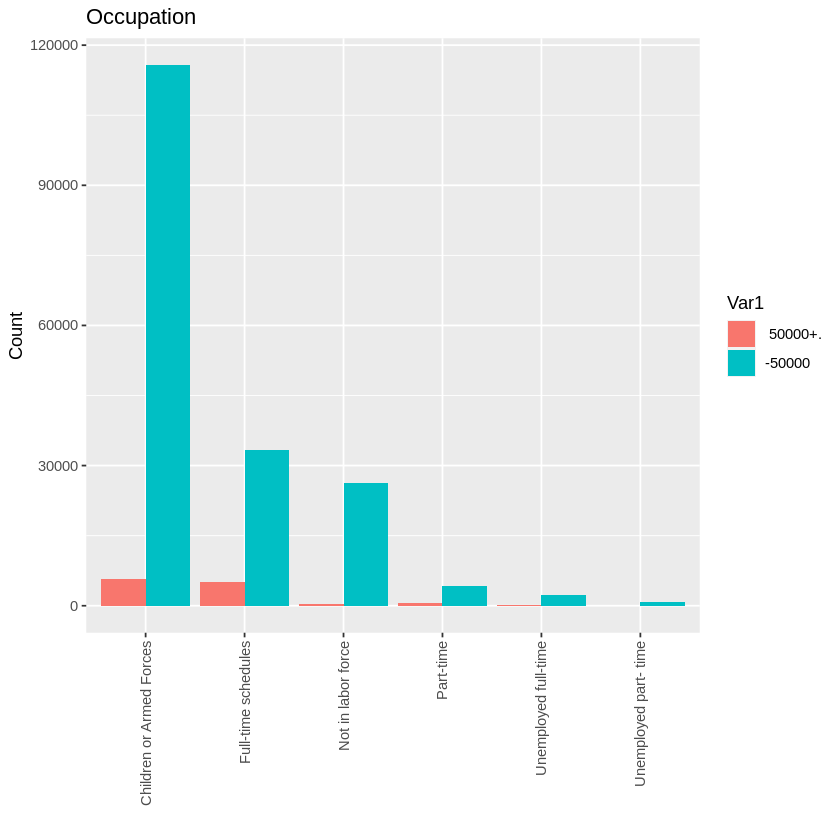

In [21]:
#full.or.part.time.employment.stat

ggplot(Train_data) +  aes_string(Train_data$full.or.part.time.employment.stat)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Binning the factors
Train_data$full.or.part.time.employment.stat <- fct_collapse(Train_data$full.or.part.time.employment.stat,
                                           "Part-time" = c(' PT for econ reasons usually FT',' PT for econ reasons usually PT',' PT for non-econ reasons usually FT'))

ggplot(Train_data) +  aes_string(Train_data$full.or.part.time.employment.stat)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Chi Square Test 
chisq.test(Train_data$full.or.part.time.employment.stat,Train_data$total.person.earnings)
#X-squared = 5137.4

# Comparing imcome with major occupation code
counts <- table(Train_data$total.person.earnings, Train_data$full.or.part.time.employment.stat) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# As expected full time are one of the highest earners, followed by part time. There is also a high amount of data and high earners present in the armed forces/ children section.
# These might be high ranked officials in the military 



	Pearson's Chi-squared test

data:  Train_data$tax.filer.status and Train_data$total.person.earnings
X-squared = 10529, df = 5, p-value < 2.2e-16


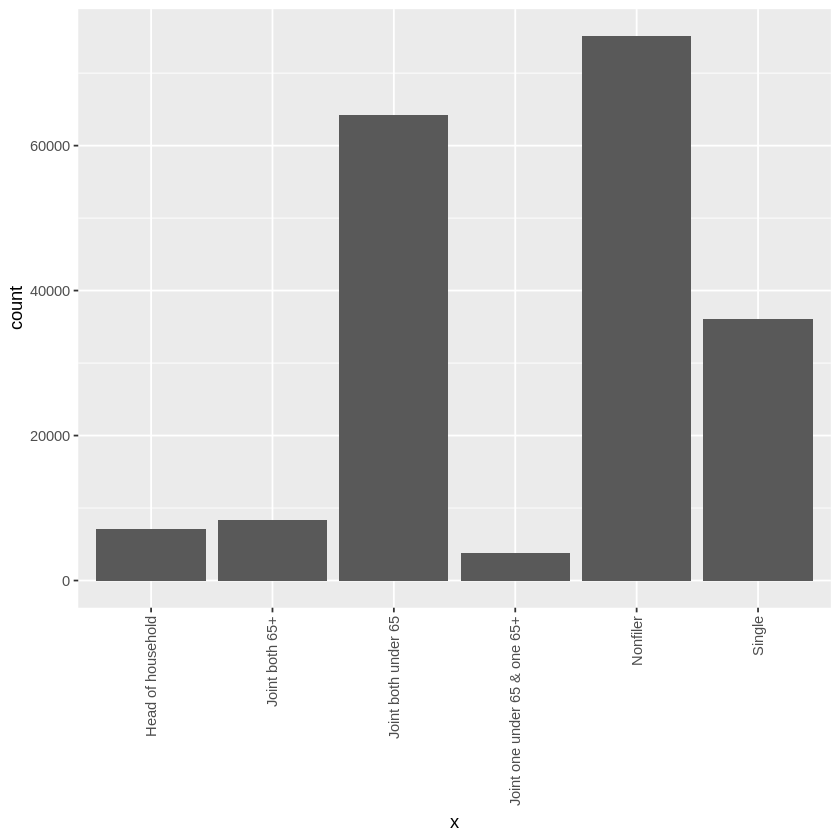

In [22]:
#tax.filer.status

ggplot(Train_data) +  aes_string(Train_data$tax.filer.status)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$tax.filer.status,Train_data$total.person.earnings)                        
#X-squared = 10529





	Pearson's Chi-squared test

data:  Train_data$own.business.or.self.employed and Train_data$total.person.earnings
X-squared = 1382.7, df = 2, p-value < 2.2e-16


[1] "% who make >50000 when self employed:0.292731829573935"

[1] "% who make >50000 when not self employed:0.292731829573935"

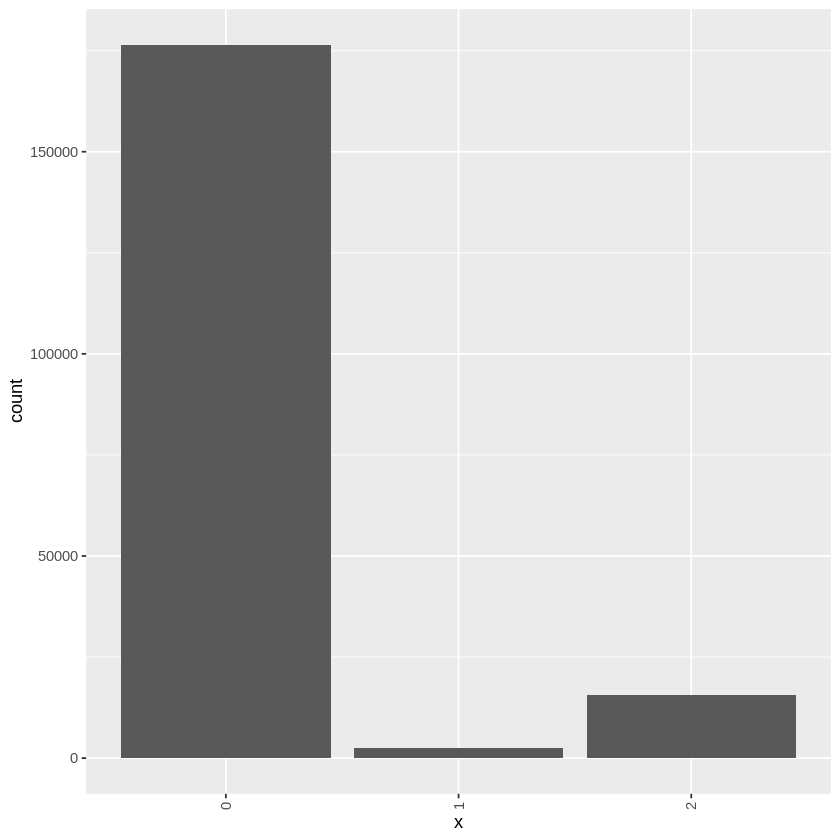

In [23]:
#own.business.or.self.employed  # 0 = niu  1 = Yes 2 = No 

ggplot(Train_data) +  aes_string(Train_data$own.business.or.self.employed)+ geom_bar()+  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$own.business.or.self.employed,Train_data$total.person.earnings)

# Comparing imcome withown business/ self employed
#table(Train_data$total.person.earnings, Train_data$own.business.or.self.employed) 
paste0("% who make >50000 when self employed:",584/1995)
paste0("% who make >50000 when not self employed:",584/1995)

# it can be seen that if own business/self-employed you are more likely to make more that +50000

### Education

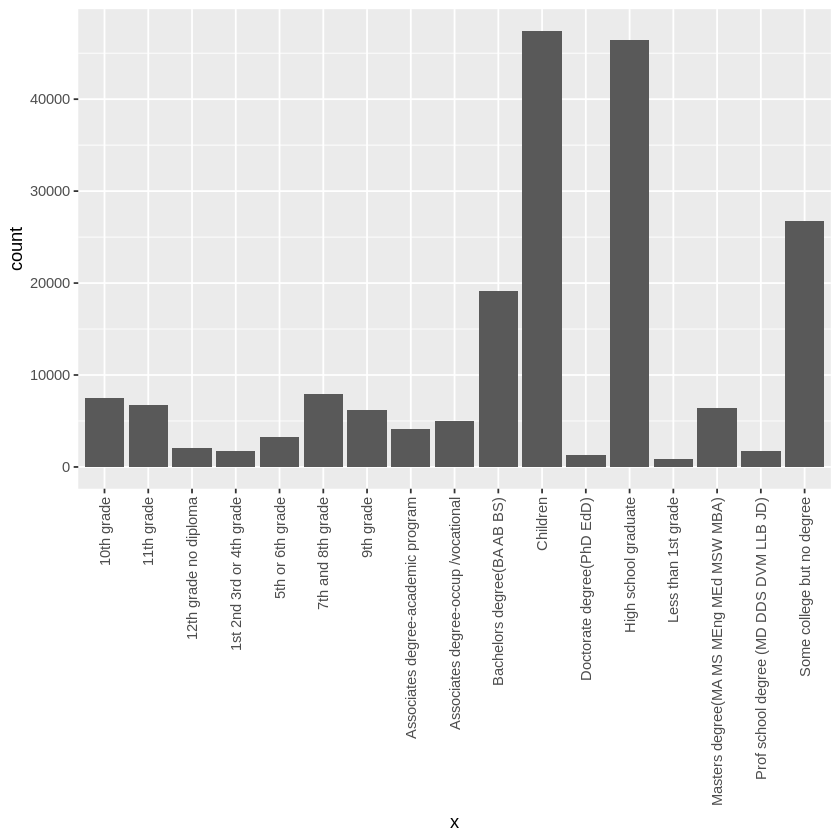

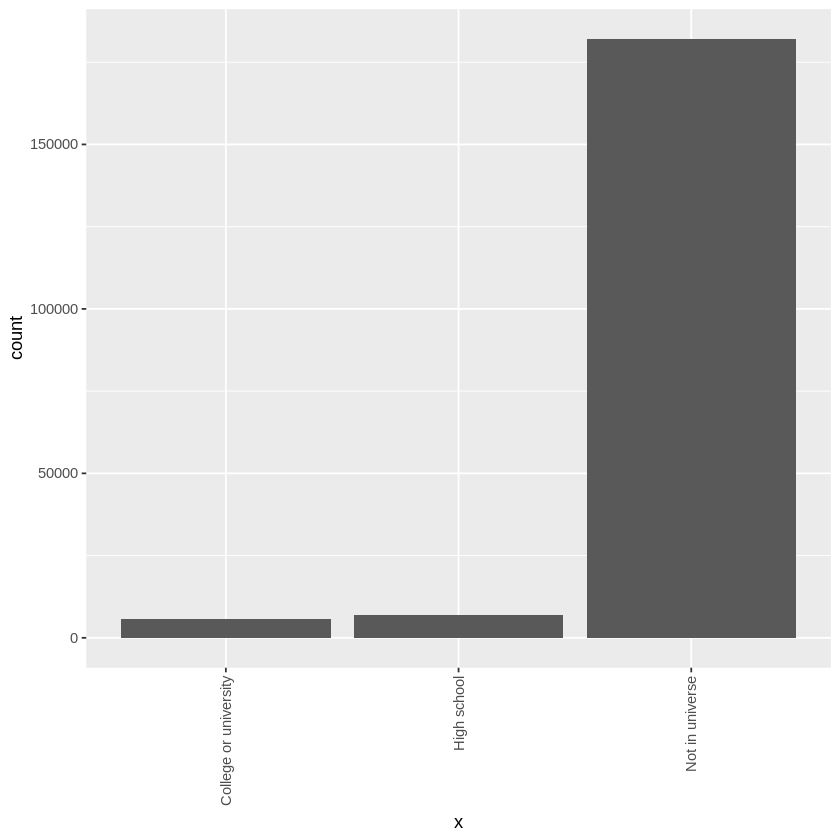


	Pearson's Chi-squared test

data:  Train_data$education and Train_data$total.person.earnings
X-squared = 21627, df = 3, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  Train_data$enrolled.in.edu.inst.last.wk and Train_data$total.person.earnings
X-squared = 807.63, df = 2, p-value < 2.2e-16


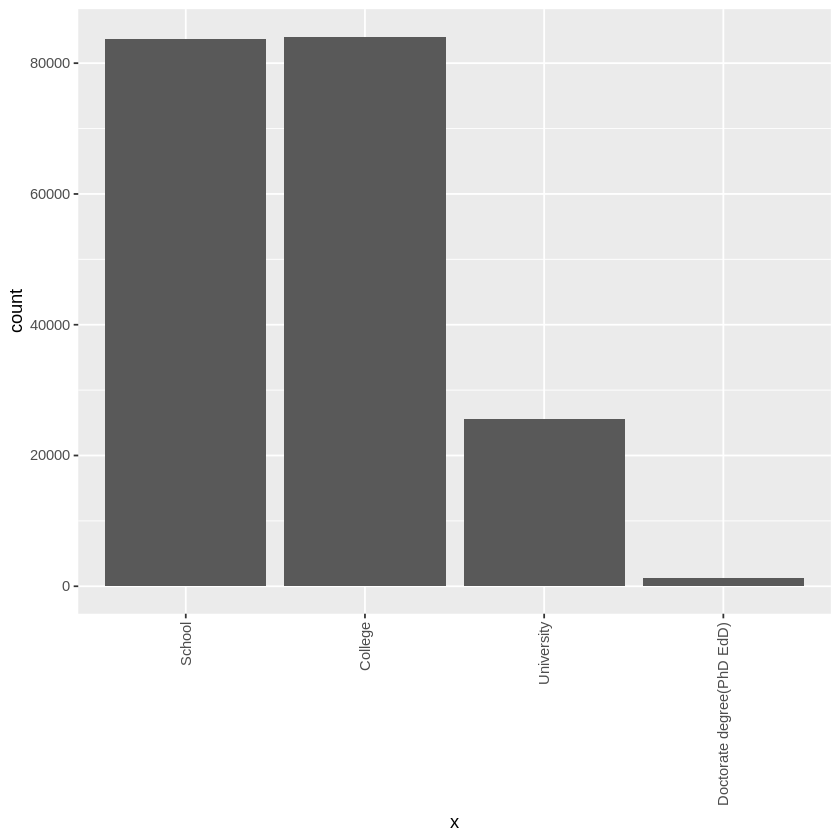

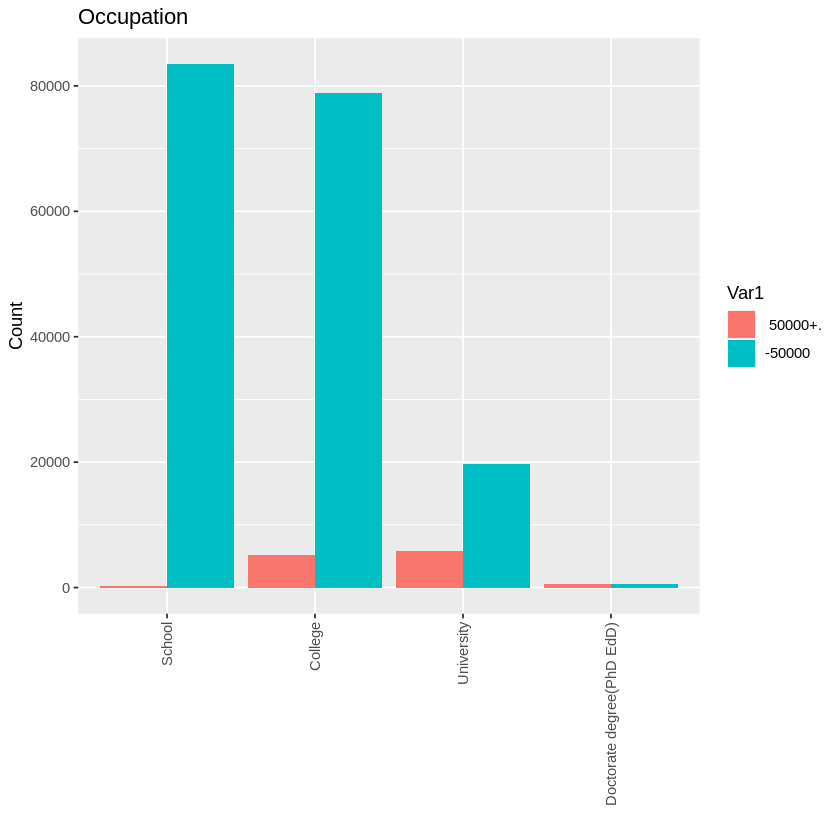

In [24]:
# Education and enrolled in education last week 

ggplot(Train_data) +  aes_string(Train_data$education)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(Train_data) +  aes_string(Train_data$enrolled.in.edu.inst.last.wk)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Binning the factors
Train_data$education <- fct_collapse(Train_data$education,
                                     "School" = c(' 10th grade',' 11th grade',' 12th grade no diploma',' 1st 2nd 3rd or 4th grade',
                                     ' 5th or 6th grade',' 7th and 8th grade',' 9th grade',' Children',' Less than 1st grade'),
                                     "College" = c(' Associates degree-academic program',' Associates degree-occup /vocational',
                                     ' High school graduate',' Some college but no degree',' Prof school degree (MD DDS DVM LLB JD)'),
                                     "University" = c(' Bachelors degree(BA AB BS)',' Masters degree(MA MS MEng MEd MSW MBA)'))

ggplot(Train_data) +  aes_string(Train_data$education)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Chi Square Test 
chisq.test(Train_data$education,Train_data$total.person.earnings)
chisq.test(Train_data$enrolled.in.edu.inst.last.wk,Train_data$total.person.earnings)

#X-squared = 19857
# Given education had a higher X-squared value followed and more the two varaibles provide in essence the same information, I will only be using the education variable. 


# Comparing imcome with education
counts <- table(Train_data$total.person.earnings, Train_data$education) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Shows the expected trend that the higher the education the higher the person makes






### Personal


	Pearson's Chi-squared test

data:  Train_data$marital.status and Train_data$total.person.earnings
X-squared = 7791.6, df = 6, p-value < 2.2e-16


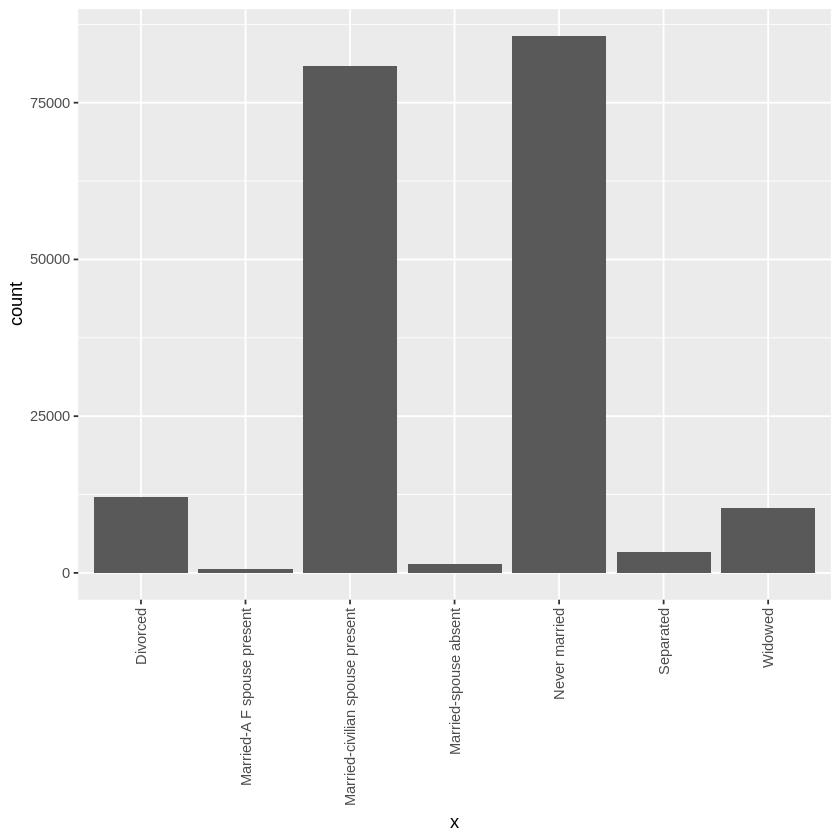

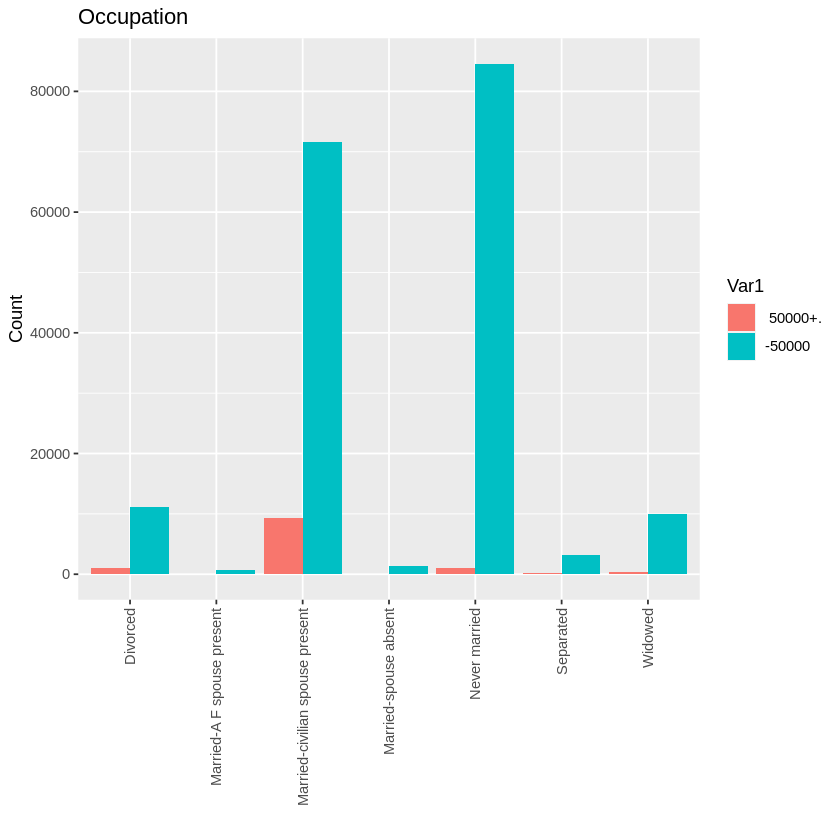

In [25]:
#martial status 

ggplot(Train_data) +  aes_string(Train_data$marital.status)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$marital.status,Train_data$total.person.earnings)
#X-squared = 7791.6


# Comparing imcome with education
counts <- table(Train_data$total.person.earnings, Train_data$marital.status) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_bar(stat="identity", position=position_dodge()) +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Shows people with a spouse present usually had a higher proportion of people making >50000 income according to the data


In [26]:
levels(Train_data$race)

[1] " Amer Indian Aleut or Eskimo" " Asian or Pacific Islander"  
[3] " Black"                       " Other"                      
[5] " White"

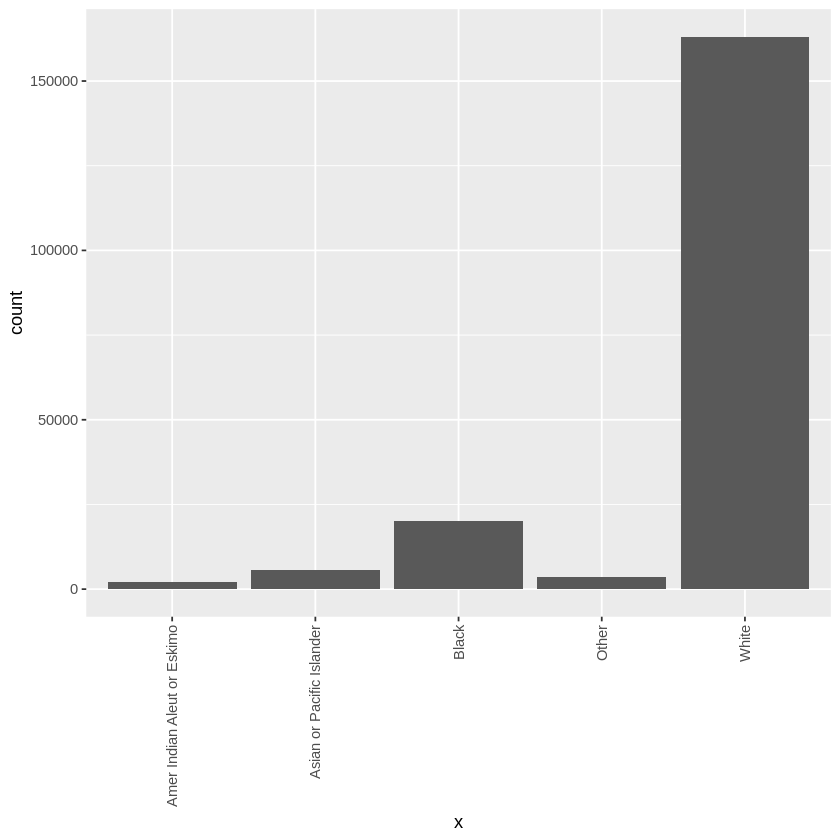

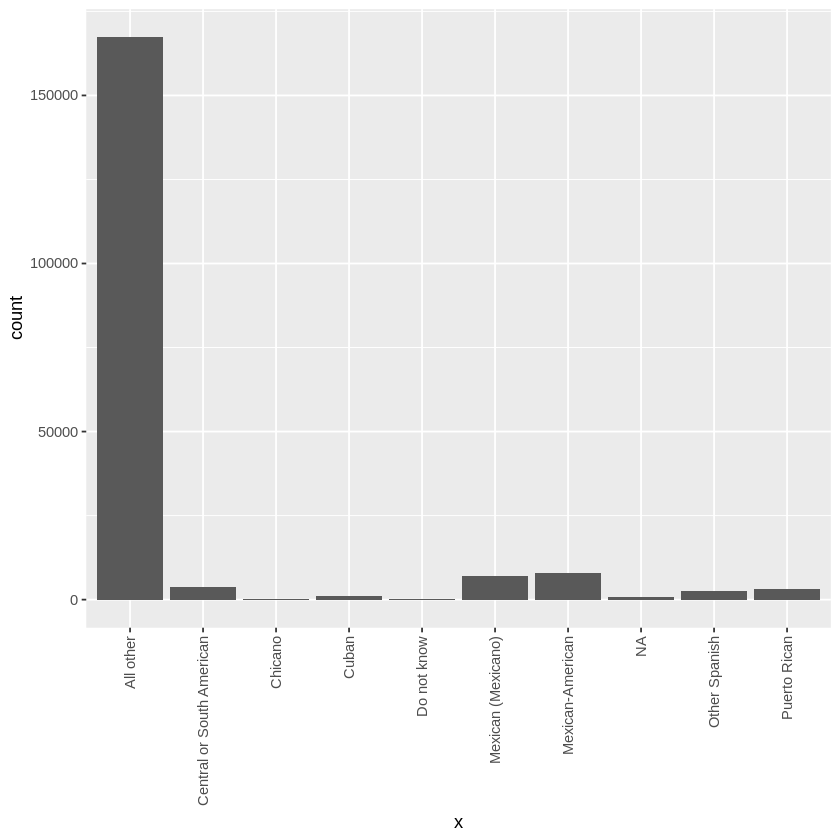


	Pearson's Chi-squared test

data:  Train_data$race and Train_data$total.person.earnings
X-squared = 565.32, df = 2, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  Train_data$hispanic.Origin and Train_data$total.person.earnings
X-squared = 924.08, df = 9, p-value < 2.2e-16


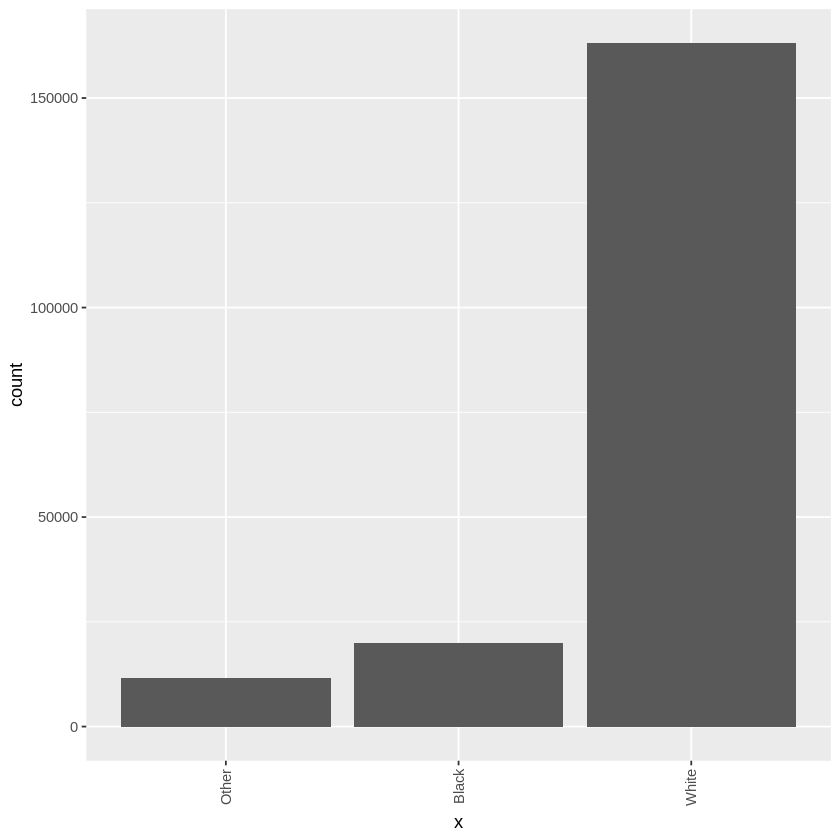

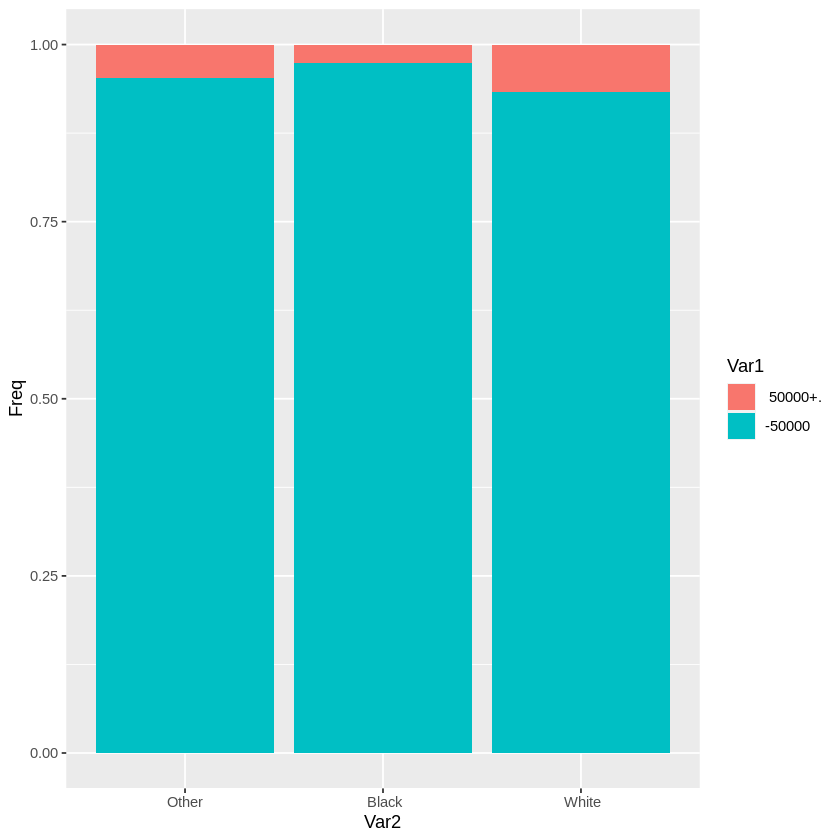

In [27]:
# race 
# hispanic origin 

ggplot(Train_data) +  aes_string(Train_data$race)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(Train_data) +  aes_string(Train_data$hispanic.Origin)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Binning the factors
Train_data$race <- fct_collapse(Train_data$race,
                                     "Other" = c(' Amer Indian Aleut or Eskimo',' Asian or Pacific Islander',' Other'))

ggplot(Train_data) +  aes_string(Train_data$race)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chi Square Test 
chisq.test(Train_data$race,Train_data$total.person.earnings)
chisq.test(Train_data$hispanic.Origin,Train_data$total.person.earnings)

# Both the variables rejected the null hypothesis however, due to the high cardinality of the hispanic origion variable, I will be dropping it. 
# This can be used as an improvement if there is adequate binning of the factors whithin origin, then the variable could have been used.  

# X-squared = 565.32



# Comparing imcome with race
counts <- table(Train_data$total.person.earnings, Train_data$race) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
  geom_col(position = "fill")

# As the predominant race type in the data was white, I created a stacked bar graph to see the proportion of income by race. People who are white are more likely to make more money according to the data. 





	Pearson's Chi-squared test with Yates' continuity correction

data:  Train_data$total.person.earnings and Train_data$sex
X-squared = 4826.4, df = 1, p-value < 2.2e-16


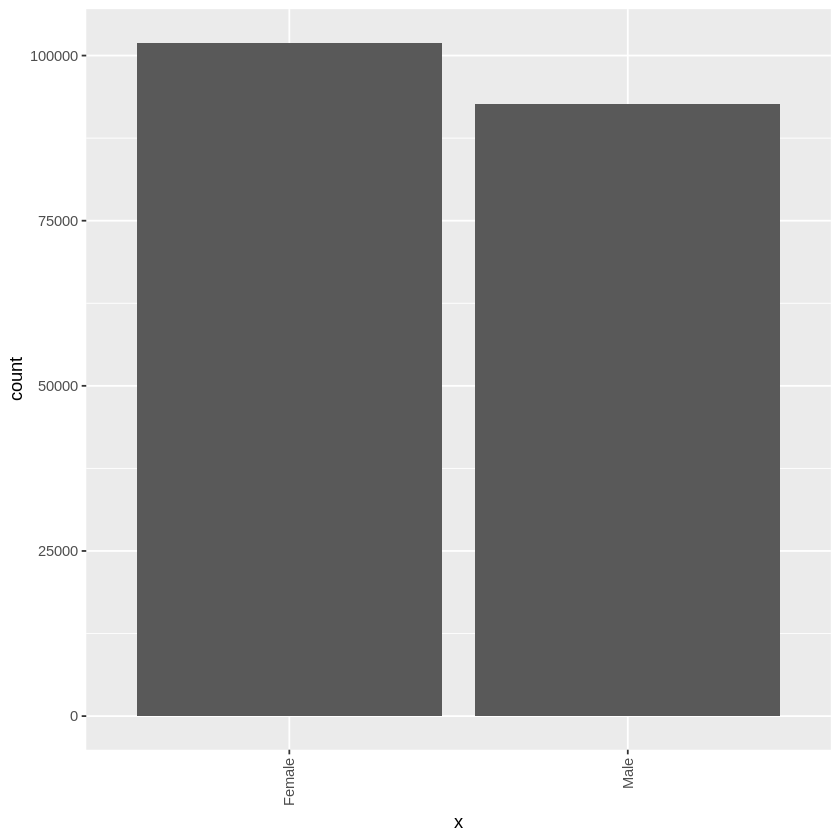

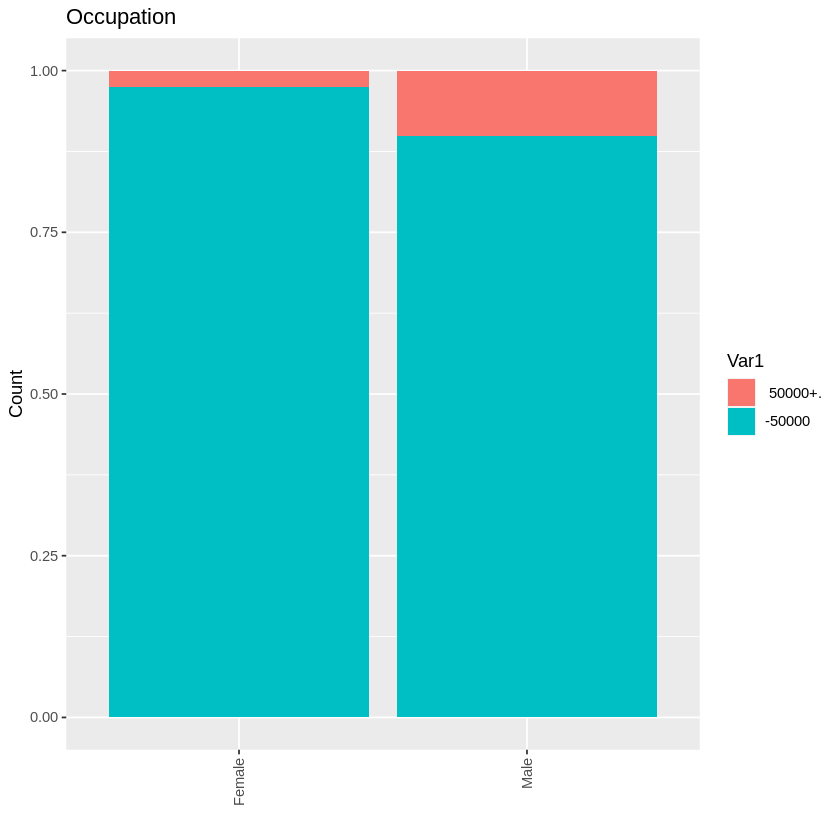

In [28]:
#sex

ggplot(Train_data) +  aes_string(Train_data$sex)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

#There is a good distribution of both the sex across the dataset

# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$sex)
# X-squared = 4826.4

# Comparing imcome with education
counts <- table(Train_data$total.person.earnings, Train_data$sex) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_col(position = "fill") +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# According to the data if you are a male you are more likely to make >$50000


### Location

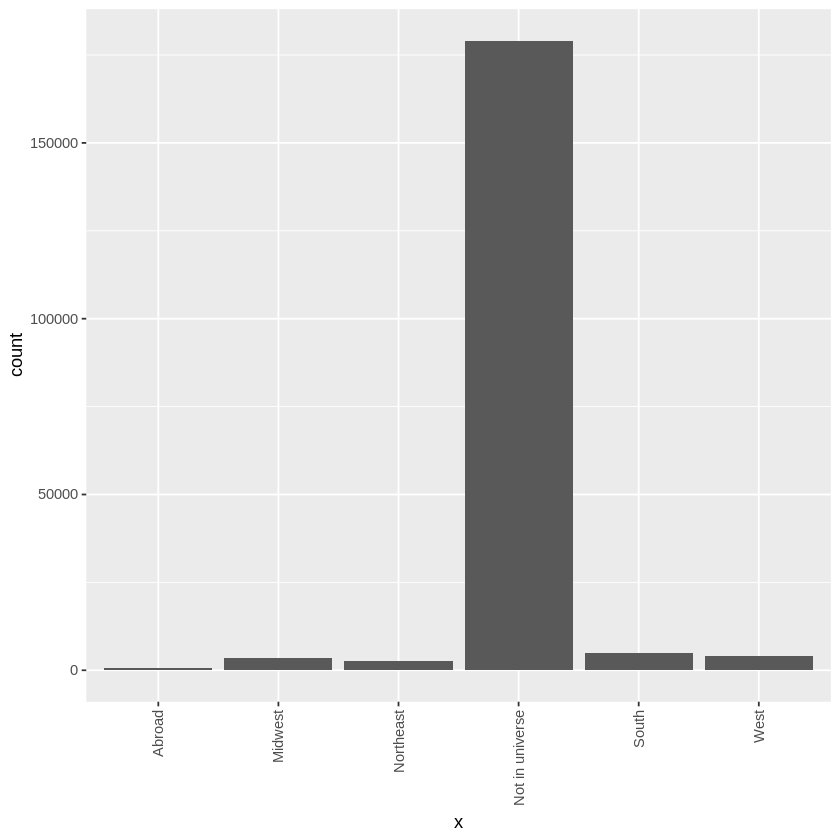


	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$region.of.previous.residence
X-squared = 157.3, df = 5, p-value < 2.2e-16


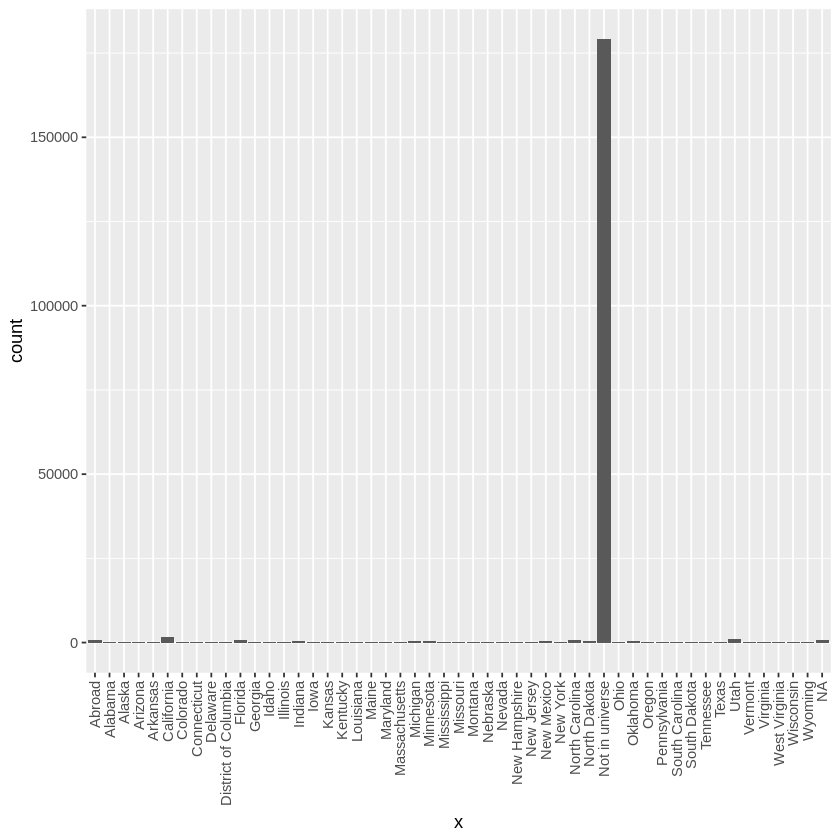

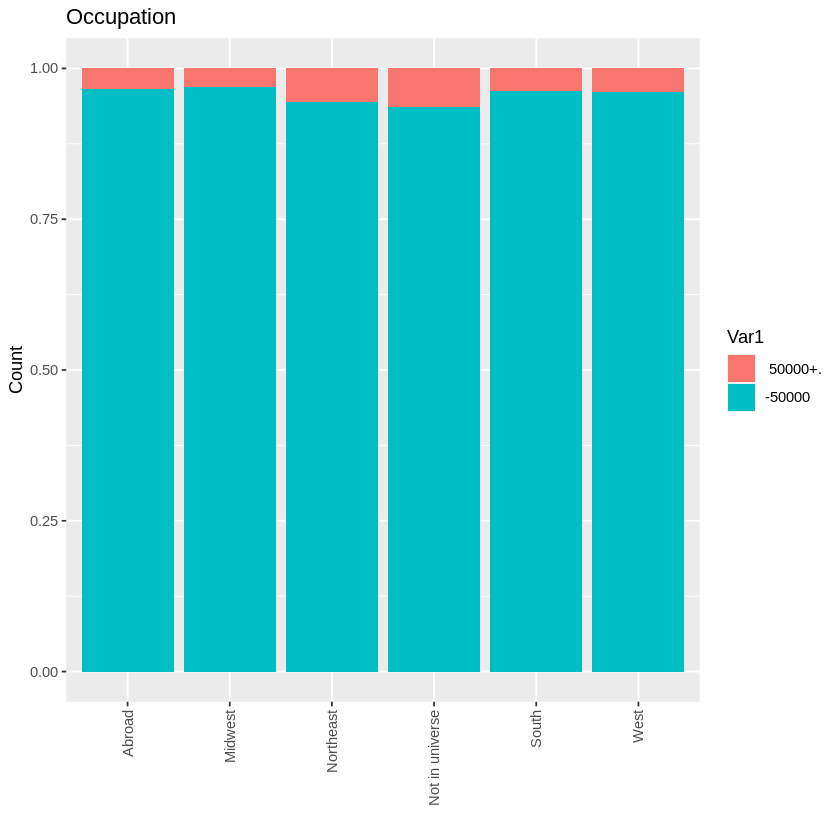

In [29]:
#region.of.previous.residence
#state.of.previous.residence


ggplot(Train_data) +  aes_string(Train_data$region.of.previous.residence)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$state.of.previous.residence)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# The state of previous residence has too high cardinality, therefore I will be dropping this feature for this pipeline. 
# If this is binned in the future then it can be used within the pipeline. 

# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$region.of.previous.residence)

# X-squared = 157.3

# Comparing imcome with education
counts <- table(Train_data$total.person.earnings, Train_data$region.of.previous.residence) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_col(position = "fill") +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# According to the data, people from northeast generally make >$50000 compared to other regions


[1] "live.in.this.house.1.year.ago"


	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$live.in.this.house.1.year.ago
X-squared = 142.25, df = 2, p-value < 2.2e-16


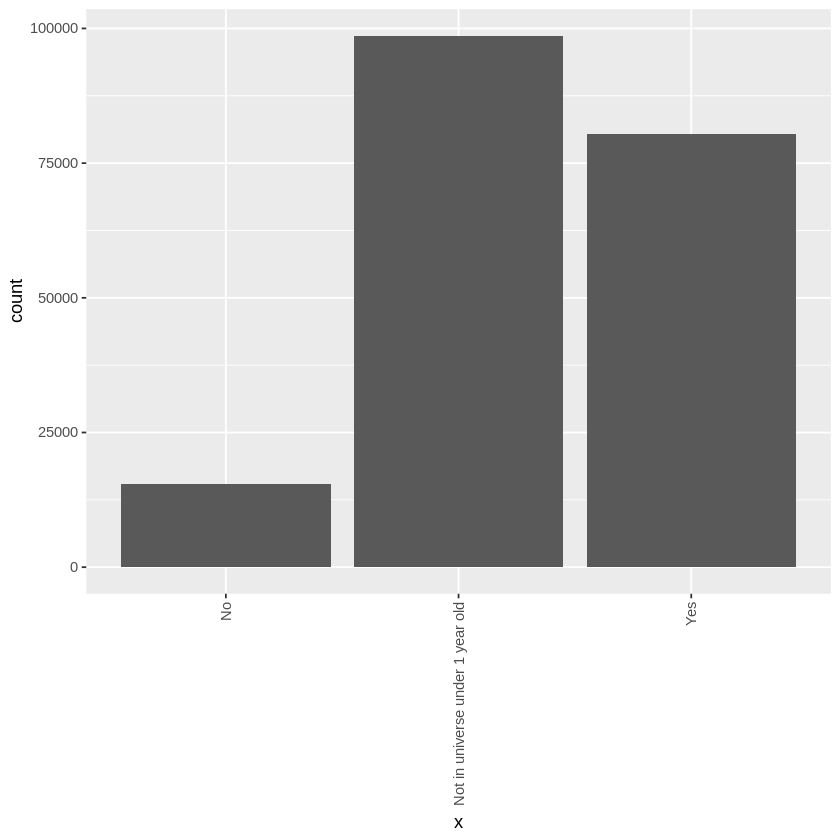

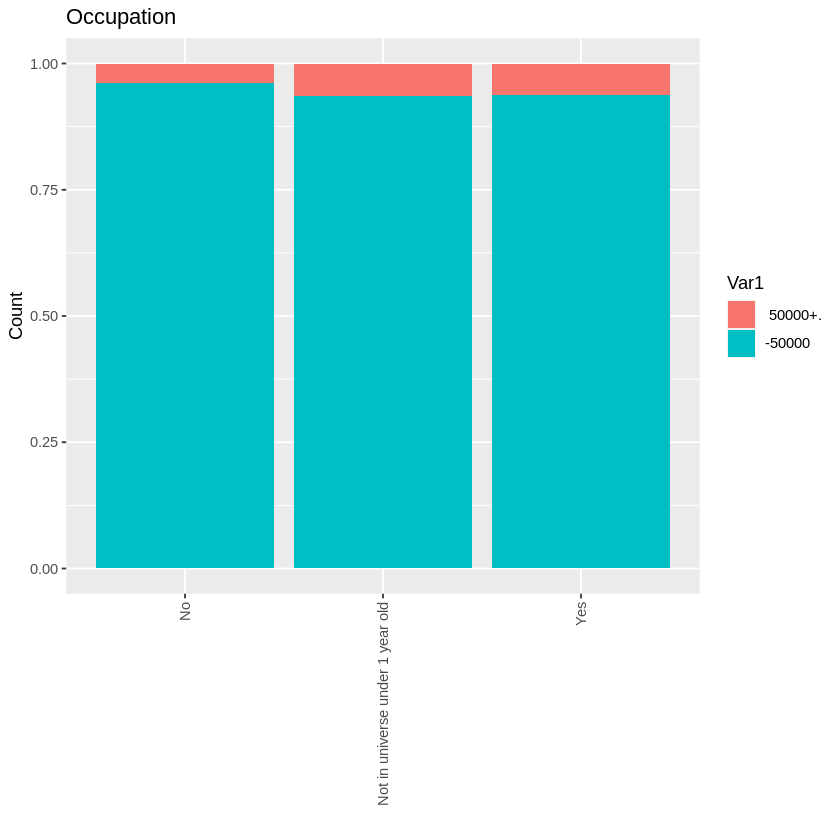

In [30]:
'live.in.this.house.1.year.ago'

ggplot(Train_data) +  aes_string(Train_data$live.in.this.house.1.year.ago)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$live.in.this.house.1.year.ago)

# X-squared = 142.25
# There is a realtionship but a weak one compared to the other varaibles

# Comparing imcome with house stay 
counts <- table(Train_data$total.person.earnings, Train_data$live.in.this.house.1.year.ago) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_col(position = "fill") +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# According to the data, people from who reamined in the house generally made >$50000 compared to other the people who moved



	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$citizenship
X-squared = 320.74, df = 4, p-value < 2.2e-16


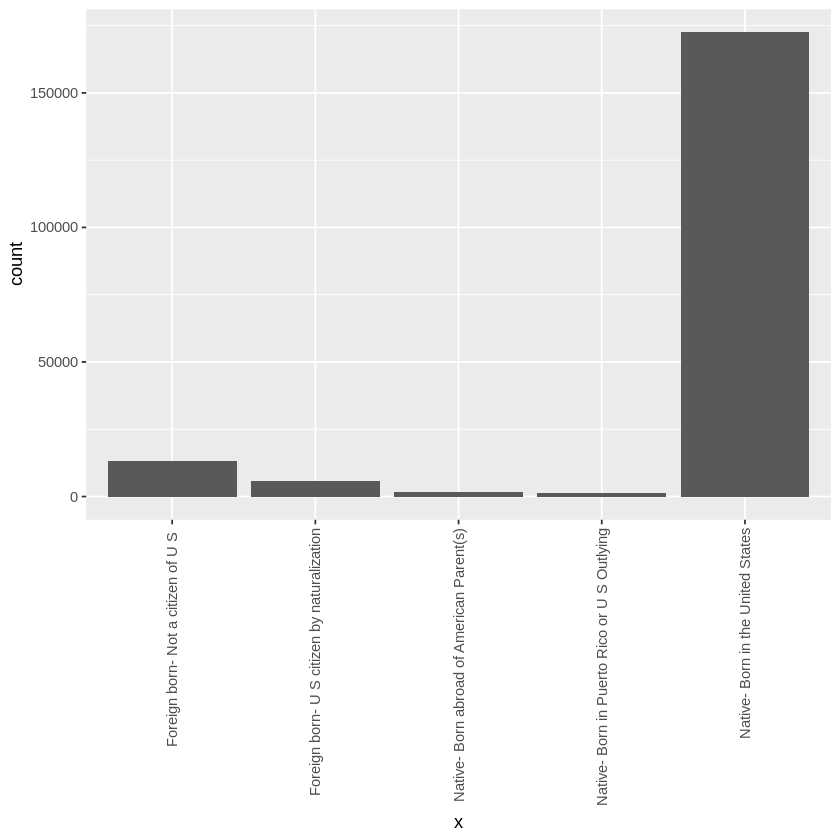

In [31]:
# Citizenship 

ggplot(Train_data) +  aes_string(Train_data$citizenship)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$citizenship)
#X-squared = 320.74



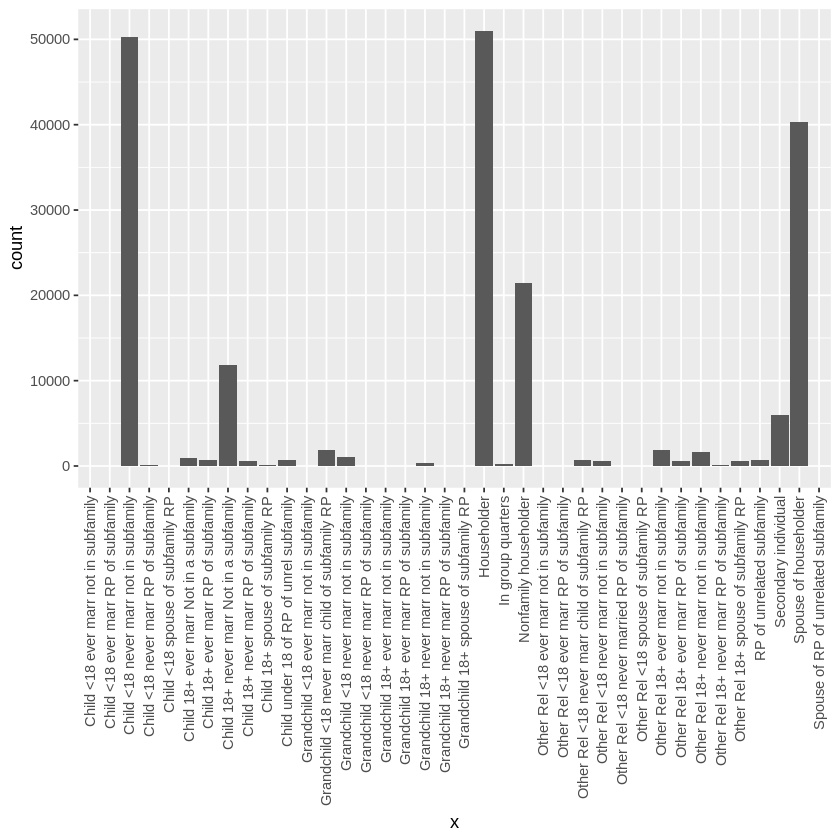

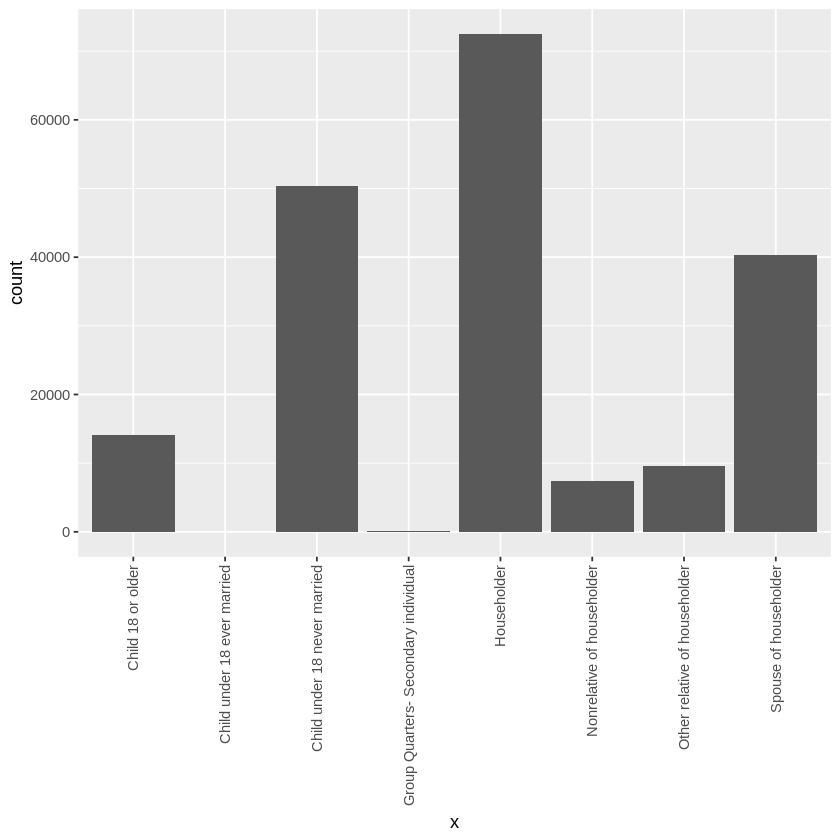


	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$detailed.household.summary.in.household
X-squared = 10211, df = 5, p-value < 2.2e-16


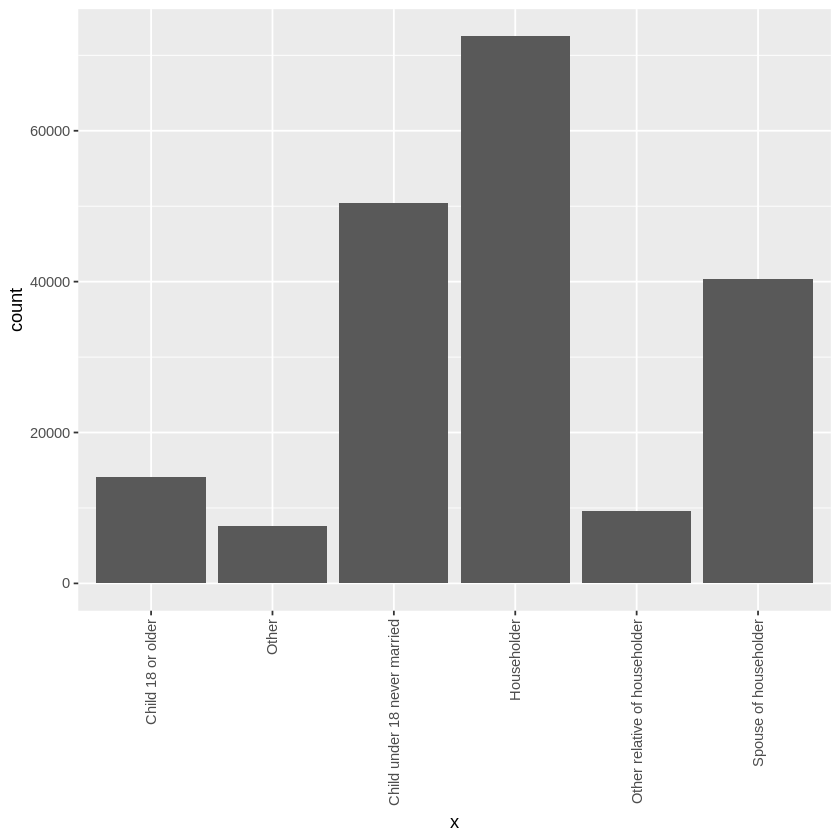

In [32]:
#detailed.household.and.family.stat
#detailed.household.summary.in.household


ggplot(Train_data) +  aes_string(Train_data$detailed.household.and.family.stat)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$detailed.household.summary.in.household)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Removing detailed household and family stats due to high cardinality. Would be useful to bin in the future and test with the model. However, as the information overlaps with the household summary will only keep that varaible. 

# Binning the factors
Train_data$detailed.household.summary.in.household <- fct_collapse(Train_data$detailed.household.summary.in.household,
                                     "Other" = c(' Child under 18 ever married',' Group Quarters- Secondary individual',' Nonrelative of householder'))

ggplot(Train_data) +  aes_string(Train_data$detailed.household.summary.in.household)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# Chi Square Test 
chisq.test(Train_data$total.person.earnings,Train_data$detailed.household.summary.in.household)
#X-squared = 10211  # removed error by binning low count factors to "Other"




	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$family.members.under.18
X-squared = 5036.4, df = 4, p-value < 2.2e-16


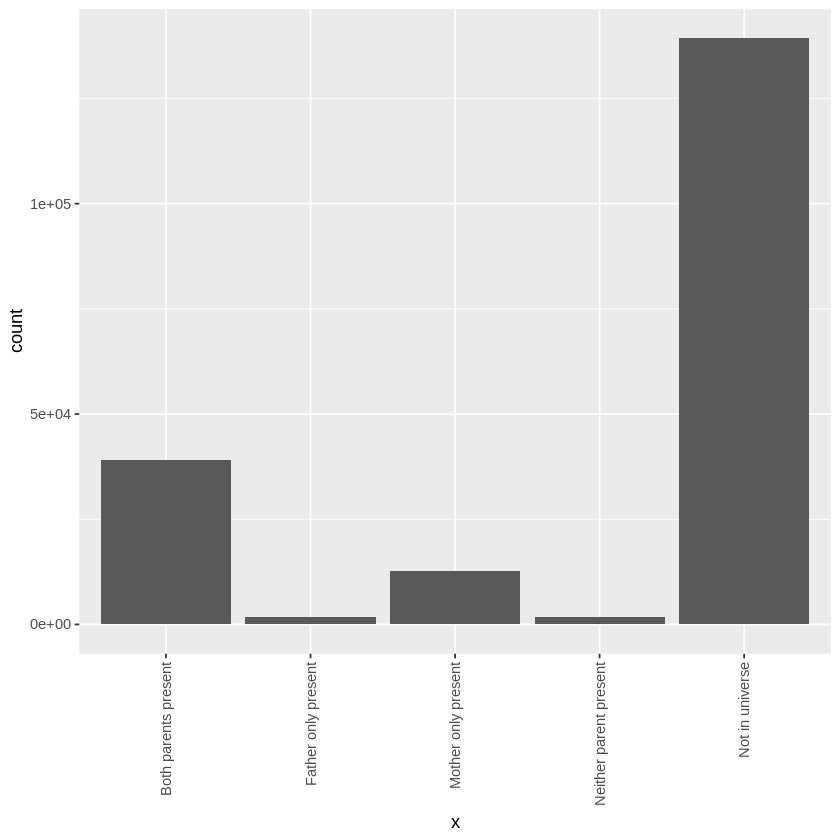


	Pearson's Chi-squared test

data:  Train_data$detailed.household.summary.in.household and Train_data$family.members.under.18
X-squared = 218739, df = 20, p-value < 2.2e-16


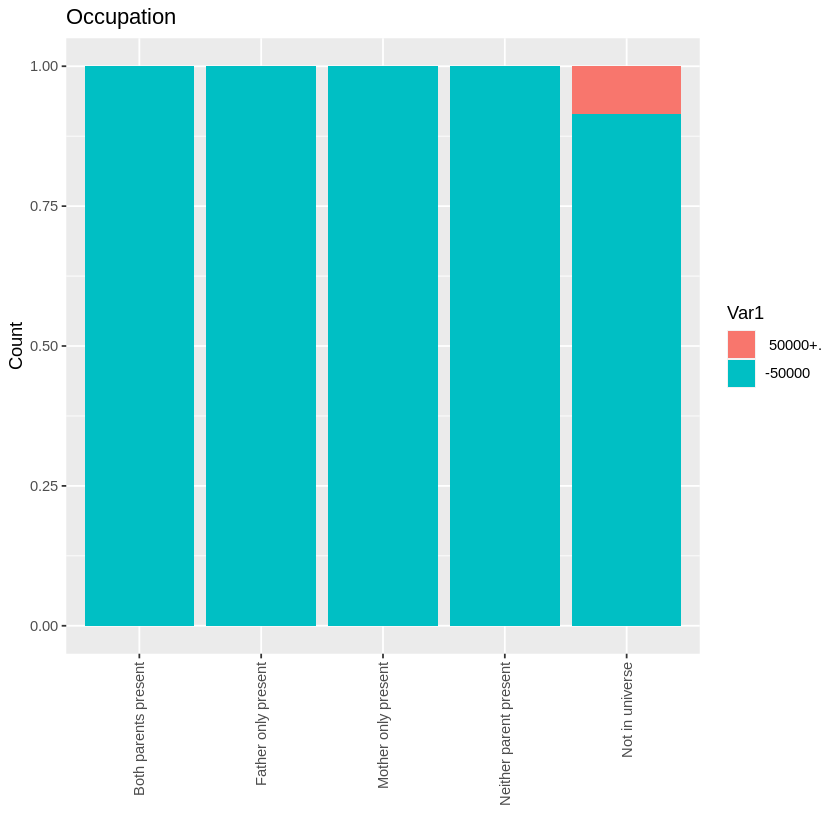

In [33]:
#family.members.under.18

ggplot(Train_data) +  aes_string(Train_data$family.members.under.18)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

chisq.test(Train_data$total.person.earnings,Train_data$family.members.under.18)

# Comparing imcome with house stay 
counts <- table(Train_data$total.person.earnings, Train_data$family.members.under.18) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_col(position = "fill") +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# The feature rejects the null hypothesis, however from the graph it can be seen it is only dominant in providing the variance for "not in universe" and "in universe". 
# There may be due to it being correlated with another variable such as in summary in household  

chisq.test(Train_data$detailed.household.summary.in.household,Train_data$family.members.under.18)
#X-squared = 218739 there is a stong relationship between the variables therefore will be dropping family.memebers.under.18



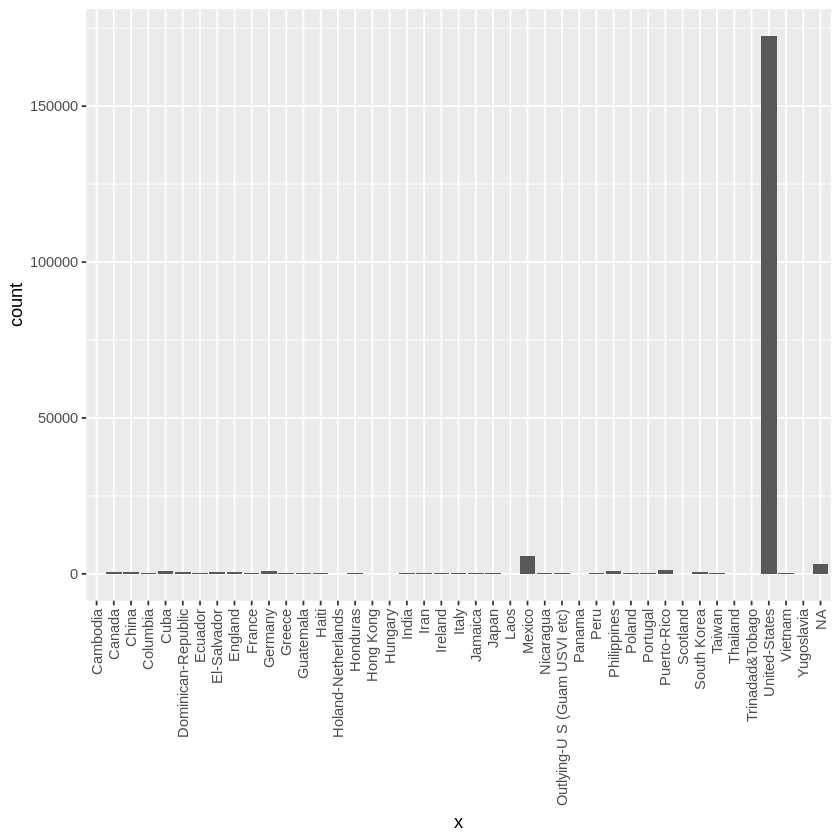

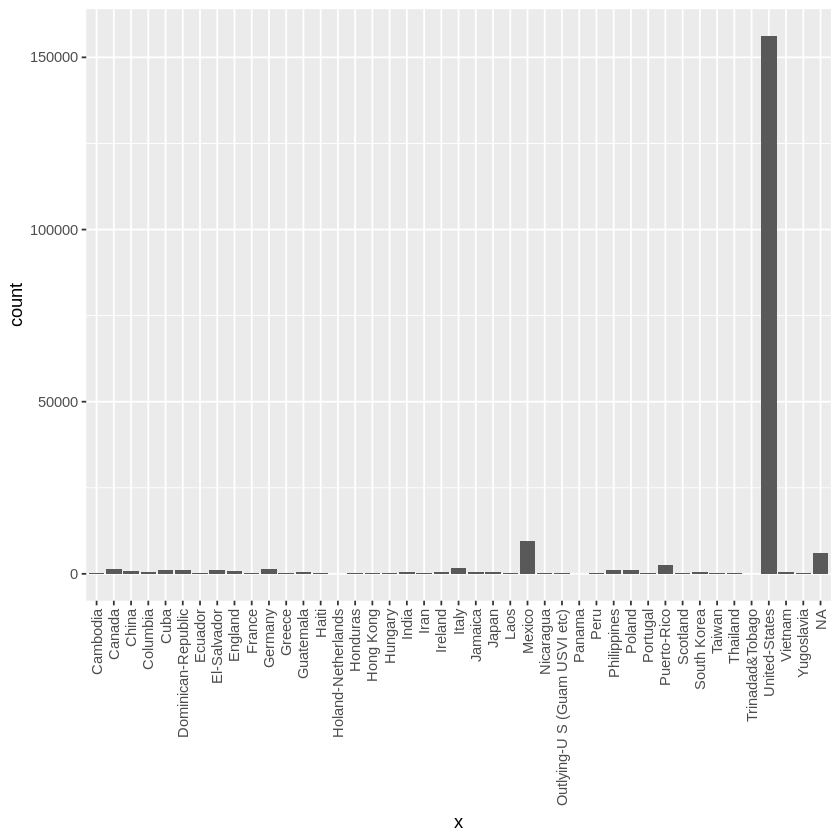

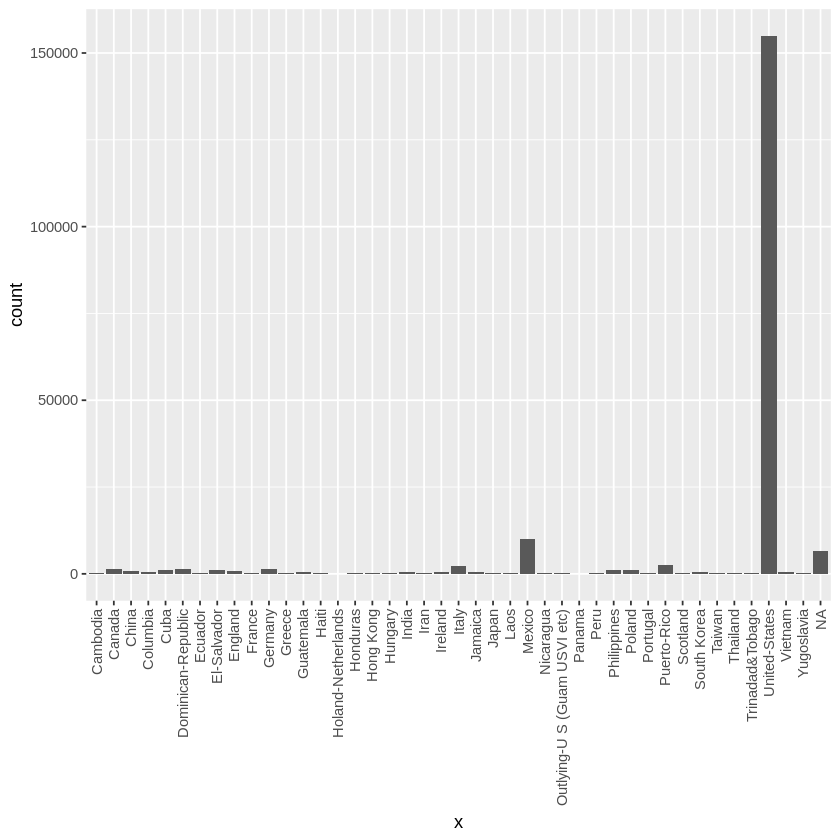


	Pearson's Chi-squared test with Yates' continuity correction

data:  Train_data$total.person.earnings and Train_data$country.of.birth.self
X-squared = 60.505, df = 1, p-value = 7.339e-15


Warning message in chisq.test(Train_data$total.person.earnings, Train_data$country.of.birth.mother):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$country.of.birth.mother
X-squared = 976.58, df = 41, p-value < 2.2e-16


Warning message in chisq.test(Train_data$total.person.earnings, Train_data$country.of.birth.father):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$country.of.birth.father
X-squared = 979.66, df = 41, p-value < 2.2e-16


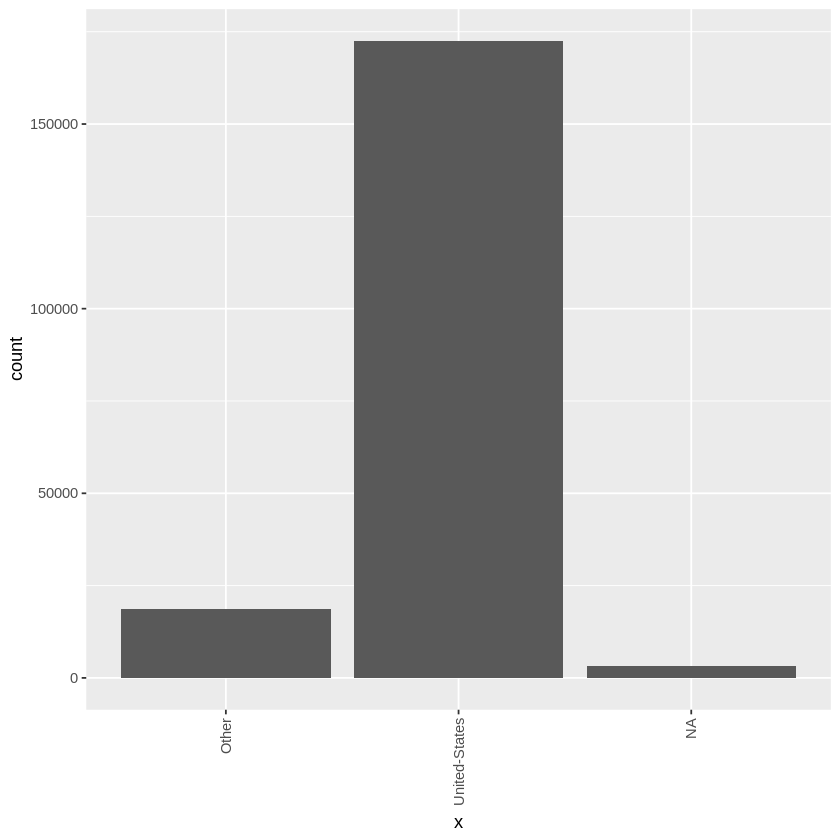

In [34]:
#'country.of.birth.self' 'country.of.birth.father' 'country.of.birth.mother'

ggplot(Train_data) +  aes_string(Train_data$country.of.birth.self)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$country.of.birth.mother)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$country.of.birth.father)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))



# Binning the factors
Train_data$country.of.birth.self <- fct_collapse(Train_data$country.of.birth.self,
                                     "Other" = c(' Cambodia',' Canada',' China',' Columbia',' Cuba',' Dominican-Republic',' Ecuador',' El-Salvador',' England',' France',' Germany',
                                     ' Greece',' Guatemala',' Haiti',' Holand-Netherlands',' Honduras',' Hong Kong',' Hungary',' India',' Iran',' Ireland',' Italy',' Jamaica',' Japan',
                                     ' Laos',' Mexico',' Nicaragua',' Outlying-U S (Guam USVI etc)',' Panama',' Peru',' Philippines',' Poland',' Portugal',' Puerto-Rico',' Scotland',
                                     ' South Korea',' Taiwan',' Thailand',' Trinadad&Tobago',' Vietnam',' Yugoslavia'))


ggplot(Train_data) +  aes_string(Train_data$country.of.birth.self)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

chisq.test(Train_data$total.person.earnings,Train_data$country.of.birth.self)
chisq.test(Train_data$total.person.earnings,Train_data$country.of.birth.mother)
chisq.test(Train_data$total.person.earnings,Train_data$country.of.birth.father)

# Majority of the people are from the USA and so are their parents.
# Given the high cardinality and the same information being passed, I am only going to user country of birth self.
# However, considering there is a relation but a low relationship comapared to the othees. I might discard all three




### Benefits/Veteran

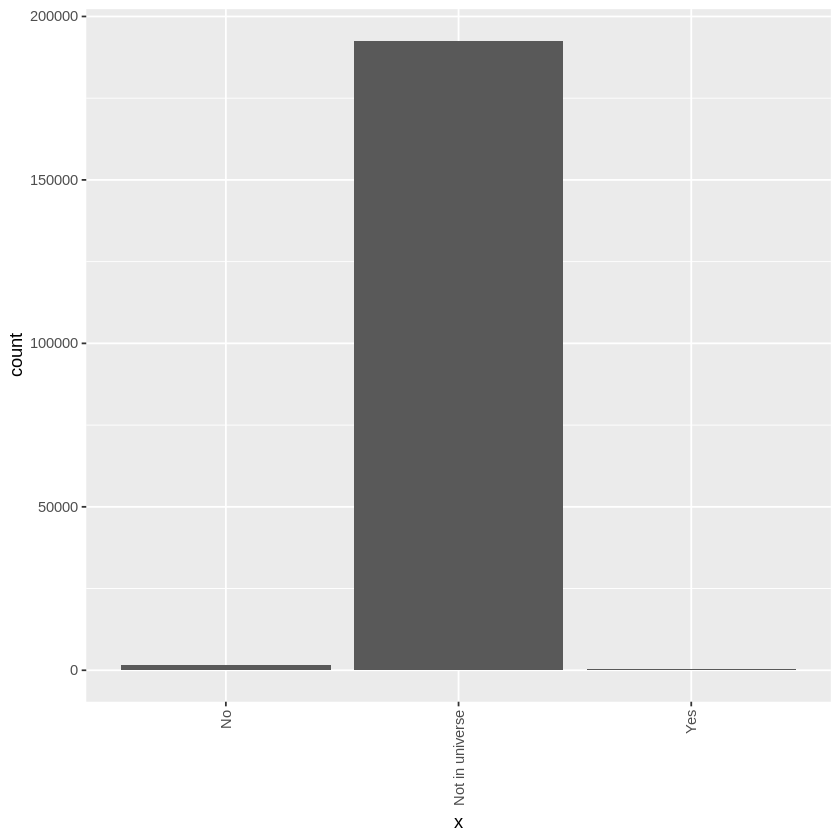

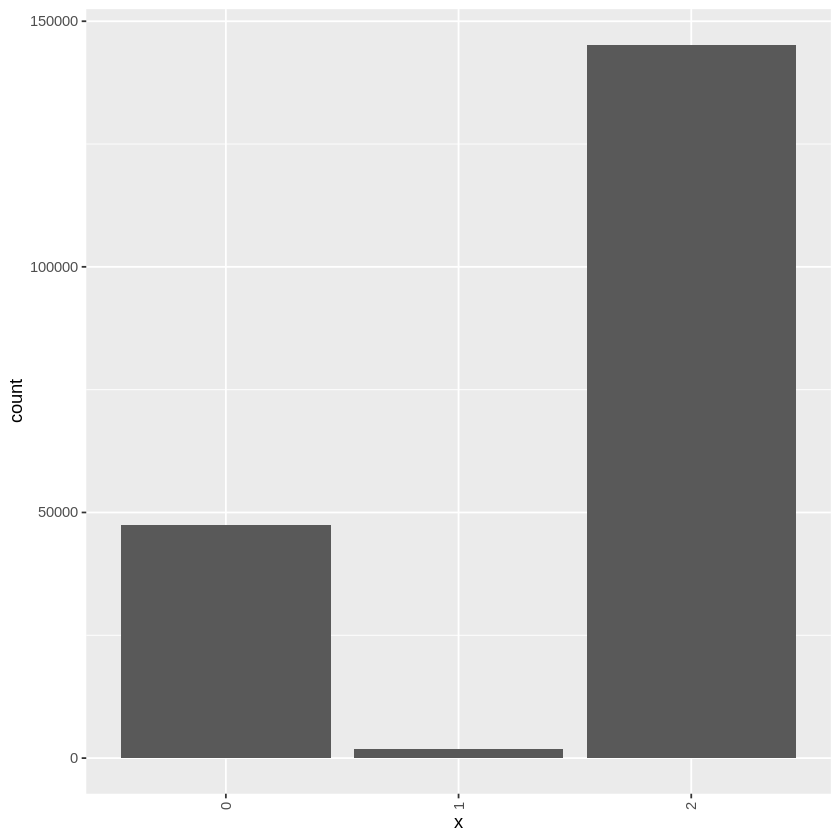


	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$fill.inc.questionnaire.for.veteran.s.admin
X-squared = 131.11, df = 2, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  Train_data$total.person.earnings and Train_data$veterans.benefits
X-squared = 4124.5, df = 2, p-value < 2.2e-16



	Fisher's Exact Test for Count Data

data:  Train_data$total.person.earnings and Train_data$year
p-value = 1.985e-10
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8541374 0.9202405
sample estimates:
odds ratio 
 0.8865743 


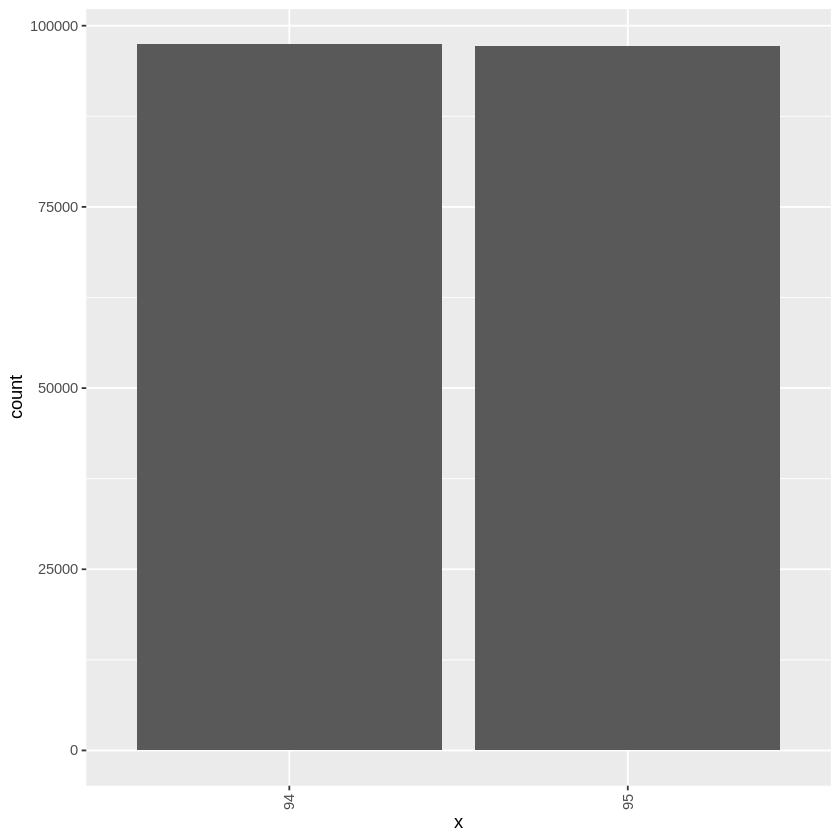

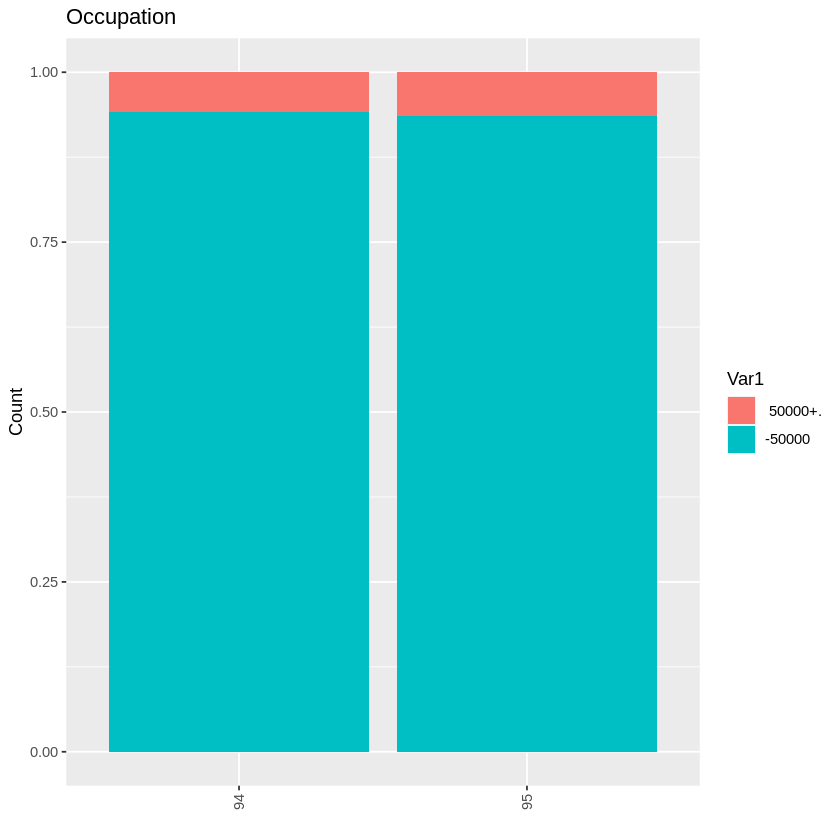

In [35]:
ggplot(Train_data) +  aes_string(Train_data$fill.inc.questionnaire.for.veteran.s.admin)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$veterans.benefits)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggplot(Train_data) +  aes_string(Train_data$year)+ geom_bar()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

chisq.test(Train_data$total.person.earnings,Train_data$fill.inc.questionnaire.for.veteran.s.admin)
chisq.test(Train_data$total.person.earnings,Train_data$veterans.benefits)
fisher.test(Train_data$total.person.earnings,Train_data$year)

counts <- table(Train_data$total.person.earnings, Train_data$year) 
df<-data.frame(counts)
ggplot(data=df, aes(x=Var2, y=Freq, fill=Var1)) +
geom_col(position = "fill") +
labs(title="Occupation", x="", y = "Count") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))




In [36]:
# putting mode over the na

calc_mode <- function(x){
  
  # List the distinct / unique values
  distinct_values <- unique(x)
  
  # Count the occurrence of each distinct value
  distinct_tabulate <- tabulate(match(x, distinct_values))
  
  # Return the value with the highest occurrence
  distinct_values[which.max(distinct_tabulate)]
}

Train_data<-Train_data %>% 
  mutate(across(everything(), ~replace_na(.x, calc_mode(.x))))


## Income Impact Analysis / Bivariate Analysis

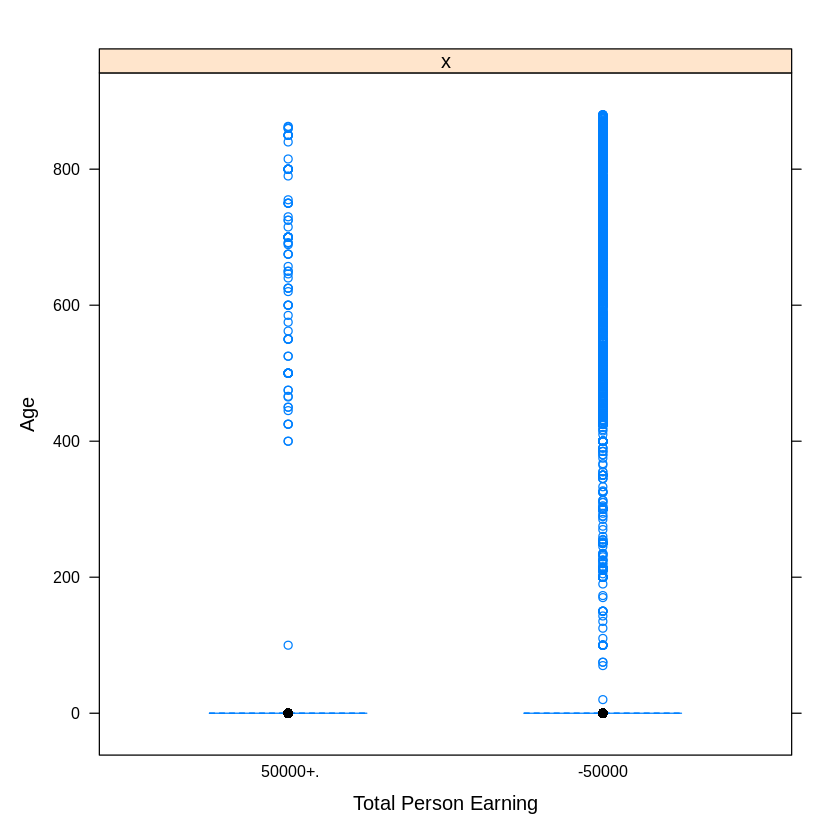

In [37]:
featurePlot(x=Train_data$wage.per.hour, y = Train_data$total.person.earnings, plot = "box", labels= c("Total Person Earning","Age"))

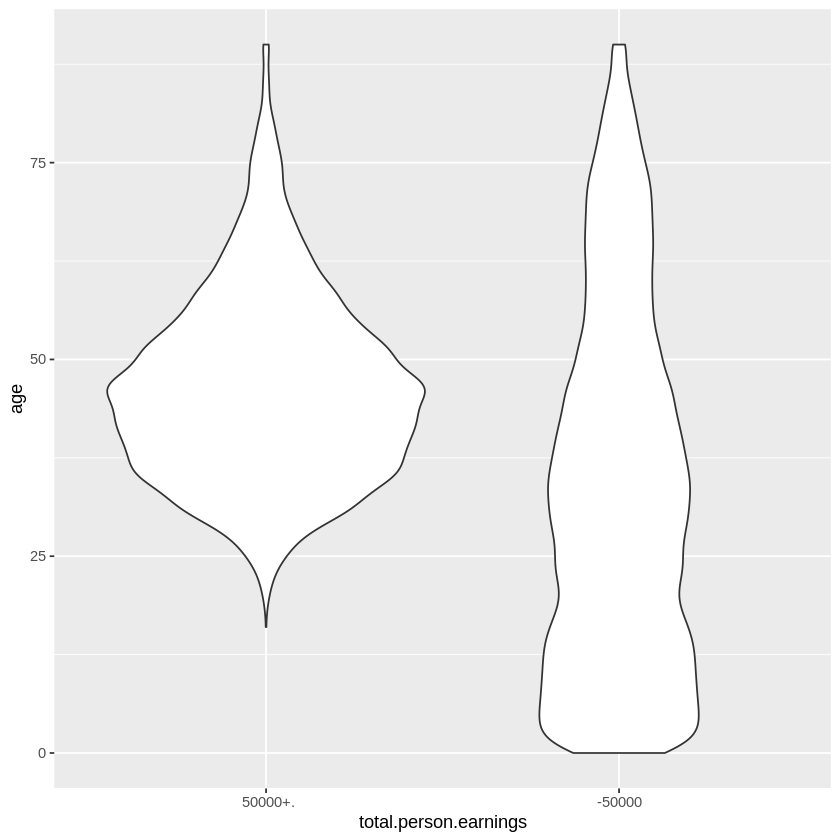

In [38]:
# Age

ggplot(Train_data, aes(x=total.person.earnings, y=age )) +  geom_violin()


## Transforming Test Data 

In [39]:
Test_data<-read.csv("census_income_test.csv",header = T)
#str(Test_data)

# Removing "instance.weight" 
Test_data<-Test_data[-25]

# Seperating numerical and categorical columns based on metadata file and data inspection
Num_var <- colnames(Test_data[,c(1,6,17,18,19,30,39)])
Cat_var <- colnames(Test_data[,c(-1,-6,-17,-18,-19,-30,-39)])

# Converting featrues to numerical/categorical 
Test_data[Num_var]<-lapply(Test_data[Num_var], as.numeric)
Test_data[Cat_var]<-lapply(Test_data[Cat_var], as.factor)

str(Test_data)

'data.frame':	99762 obs. of  41 variables:
 $ age                                       : num  38 44 2 35 49 13 1 61 38 7 ...
 $ class.of.worker                           : Factor w/ 9 levels " Federal government",..: 5 7 4 5 5 4 4 4 5 4 ...
 $ industry.code                             : Factor w/ 52 levels "0","1","2","3",..: 7 38 1 30 5 1 1 1 46 1 ...
 $ occupation.code                           : Factor w/ 47 levels "0","1","2","3",..: 37 13 1 4 35 1 1 1 13 1 ...
 $ education                                 : Factor w/ 17 levels " 10th grade",..: 4 9 11 13 13 11 11 13 15 11 ...
 $ wage.per.hour                             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ enrolled.in.edu.inst.last.wk              : Factor w/ 3 levels " College or university",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ marital.status                            : Factor w/ 7 levels " Divorced"," Married-A F spouse present",..: 3 3 5 1 1 5 5 3 3 5 ...
 $ major.industry.code                       : Factor w/ 24 levels " Agriculture"

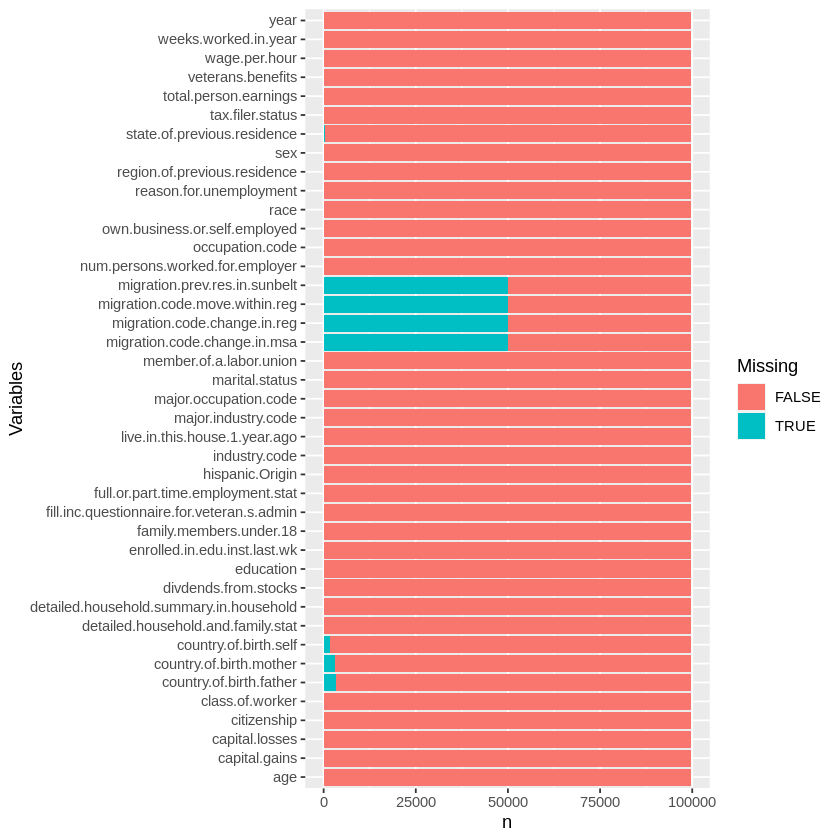

In [40]:
# " ?" Value Inspection 

# On checking the metadata file the " ?" category is not an option, therefore it will be regarded as NA
Test_data[Cat_var]<-lapply(Test_data[Cat_var], as.character)
Test_data[Test_data == " ?"] <- NA

Test_data  %>%
  summarise_all(list(~is.na(.)))%>%
  pivot_longer(everything(),
               names_to = "Variables", values_to="Missing") %>%
  count(Variables, Missing) %>%
  ggplot(aes(y=Variables,x=n,fill=Missing))+
  geom_col()

# Returning to factors
Test_data[Cat_var]<-lapply(Test_data[Cat_var], as.factor)

In [41]:
# Removing migration features
Test_data<- Test_data[,-c(25,26,27,29)]

Num_var<-names(which(unlist(lapply(Test_data, is.numeric))))
Cat_var<-names(which(unlist(lapply(Test_data, is.factor))))

In [70]:
# putting mode over the na

calc_mode <- function(x){
  
  # List the distinct / unique values
  distinct_values <- unique(x)
  
  # Count the occurrence of each distinct value
  distinct_tabulate <- tabulate(match(x, distinct_values))
  
  # Return the value with the highest occurrence
  distinct_values[which.max(distinct_tabulate)]
}

Test_data<-Test_data %>% 
  mutate(across(everything(), ~replace_na(.x, calc_mode(.x))))

In [71]:
# Binning the factors
Test_data$class.of.worker <- fct_collapse(Test_data$class.of.worker,
                                           "Government" = c(' Federal government',' Local government',' State government'),
                                           "Self-employed" = c(' Self-employed-incorporated',' Self-employed-not incorporated'))

In [78]:
# Binning the factors
Test_data$education <- fct_collapse(Test_data$education,
                                     "School" = c(' 10th grade',' 11th grade',' 12th grade no diploma',' 1st 2nd 3rd or 4th grade',
                                     ' 5th or 6th grade',' 7th and 8th grade',' 9th grade',' Children',' Less than 1st grade'),
                                     "College" = c(' Associates degree-academic program',' Associates degree-occup /vocational',
                                     ' High school graduate',' Some college but no degree',' Prof school degree (MD DDS DVM LLB JD)'),
                                     "University" = c(' Bachelors degree(BA AB BS)',' Masters degree(MA MS MEng MEd MSW MBA)'))

In [79]:
# Binning the factors
Test_data$full.or.part.time.employment.stat <- fct_collapse(Test_data$full.or.part.time.employment.stat,
                                           "Part-time" = c(' PT for econ reasons usually FT',' PT for econ reasons usually PT',' PT for non-econ reasons usually FT'))


In [83]:
# Binning the factors
Test_data$detailed.household.summary.in.household <- fct_collapse(Test_data$detailed.household.summary.in.household,
                                     "Other" = c(' Child under 18 ever married',' Group Quarters- Secondary individual',' Nonrelative of householder'))

# **Data Modelling / Model Assessment** 

In [43]:
nrow(Train_data)
table(Train_data$total.person.earnings)
prop.table(table(Train_data$total.person.earnings))

[1] 194556


 50000+.   -50000 
   11924   182632 


   50000+.     -50000 
0.06128827 0.93871173 

In [64]:
subset <- createDataPartition(Train_data$total.person.earnings, p = 0.1)

subset <- Train_data[as.numeric(subset[[1]]), ]

nrow(subset)
table(subset$total.person.earnings)
prop.table(table(subset$total.person.earnings))

[1] 19457


 50000+.   -50000 
    1193    18264 


   50000+.     -50000 
0.06131469 0.93868531 

In [65]:
test<-subset[,c(1,2,5,6,8,9,10,13,15,17,18,19,16,20,24,37)]

colnames(test)

[1] "age"                                    
 [2] "class.of.worker"                        
 [3] "education"                              
 [4] "wage.per.hour"                          
 [5] "marital.status"                         
 [6] "major.industry.code"                    
 [7] "major.occupation.code"                  
 [8] "sex"                                    
 [9] "reason.for.unemployment"                
[10] "capital.gains"                          
[11] "capital.losses"                         
[12] "divdends.from.stocks"                   
[13] "full.or.part.time.employment.stat"      
[14] "tax.filer.status"                       
[15] "detailed.household.summary.in.household"
[16] "total.person.earnings"

In [46]:
rfeCtrl<- rfeControl(functions = rfFuncs,
method = "cv",
verbose = FALSE)

In [47]:
#rfProfile <- rfe(x = subset[,-37],
#y= subset$total.person.earnings,
#rfeControl = rfeCtrl)

#rfProfile

In [66]:
rf<-train(y= test$total.person.earnings, x = test[,1:15],data = test, method = "rf")
rf

# kappa is a better metric to use when facing imbalanced model

Random Forest 

19457 samples
   15 predictor
    2 classes: ' 50000+.', '-50000' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 19457, 19457, 19457, 19457, 19457, 19457, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9502268  0.3900105
   8    0.9468263  0.4374040
  15    0.9447877  0.4372827

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

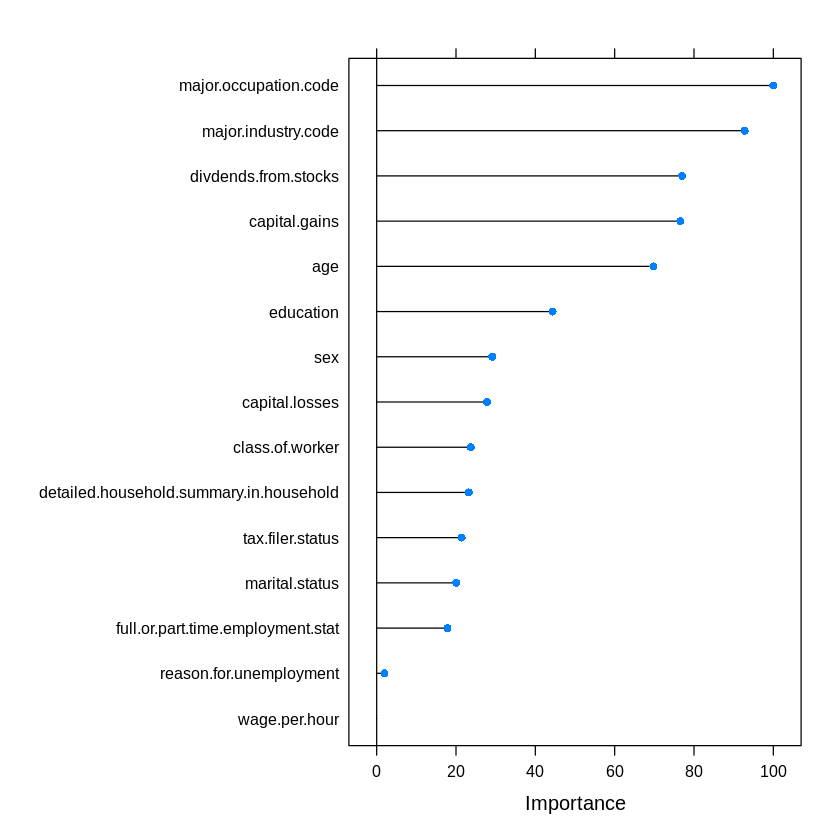

In [67]:
plot(varImp(rf))

In [84]:
fitted<-predict(rf,Test_data)
fitted[1:10]

[1] -50000 -50000 -50000 -50000 -50000 -50000 -50000 -50000 -50000 -50000
Levels:  50000+. -50000

In [85]:
confusionMatrix(reference = Test_data$total.person.earnings, data = fitted, mode = "everything")

# sensitivity: no. of times person income was +50000 and the model correctly identified it [Recall]
# specificty:  no. of times person income was -50000 and the model correctly identified it
# pos : how many +5000 were actaully predicted right
# ned: how many -5000 were actaully predicted right 

# sensitivity and F1 are really low. This is there due to the high imbalance in the data

Confusion Matrix and Statistics

          Reference
Prediction  50000+. -50000
   50000+.     1747    534
  -50000       4439  93042
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9488, 0.9515)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3924          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.28241         
            Specificity : 0.99429         
         Pos Pred Value : 0.76589         
         Neg Pred Value : 0.95446         
              Precision : 0.76589         
                 Recall : 0.28241         
                     F1 : 0.41266         
             Prevalence : 0.06201         
         Detection Rate : 0.01751         
   Detection Prevalence : 0.02286         
      

## **Resampling Imbalanced Dataset**

In [86]:
downCtrl <- trainControl(
  method = "boot",
  number = 5,
  classProbs = T,
  summaryFunction = twoClassSummary,
  sampling = "down"
)

upCtrl <- trainControl(
  method = "boot",
  number = 5,
  classProbs = T,
  summaryFunction = twoClassSummary,
  sampling = "up"
)

levels(test$total.person.earnings)<-c("Above","Below")
levels(Test_data$total.person.earnings)<-c("Above","Below")

### **Down Sampling**

In [87]:
rfdown <-train(y= test$total.person.earnings, x = test[,1:15],data = test, method = "rf", metric = "ROC", trControl = downCtrl)

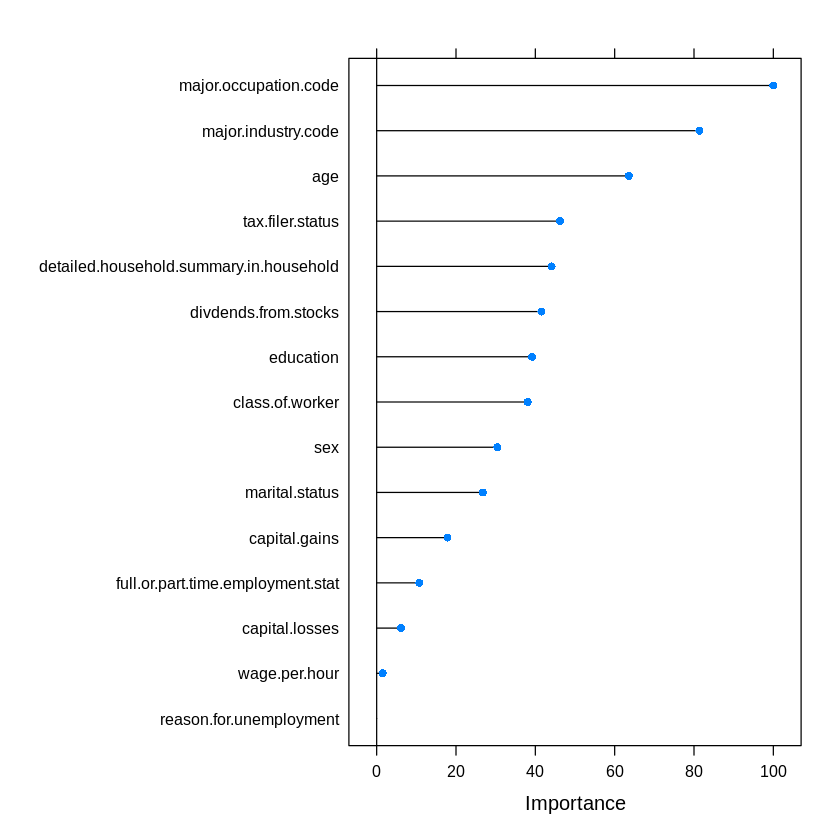

In [88]:
plot(varImp(rfdown))

In [89]:
fittedDown<- predict(rfdown, Test_data)
fittedDown[1:10]

[1] Below Above Below Above Above Below Below Below Above Below
Levels: Above Below

In [90]:
confusionMatrix(reference = Test_data$total.person.earnings, data = fittedDown, mode = "everything")


Confusion Matrix and Statistics

          Reference
Prediction Above Below
     Above  5417 14663
     Below   769 78913
                                          
               Accuracy : 0.8453          
                 95% CI : (0.8431, 0.8476)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3509          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.87569         
            Specificity : 0.84330         
         Pos Pred Value : 0.26977         
         Neg Pred Value : 0.99035         
              Precision : 0.26977         
                 Recall : 0.87569         
                     F1 : 0.41247         
             Prevalence : 0.06201         
         Detection Rate : 0.05430         
   Detection Prevalence : 0.20128         
      Balanced Acc

### **Up Sampling**

In [91]:
rfup <-train(y= test$total.person.earnings, x = test[,1:15],data = test, method = "rf", metric = "ROC", trControl = upCtrl)

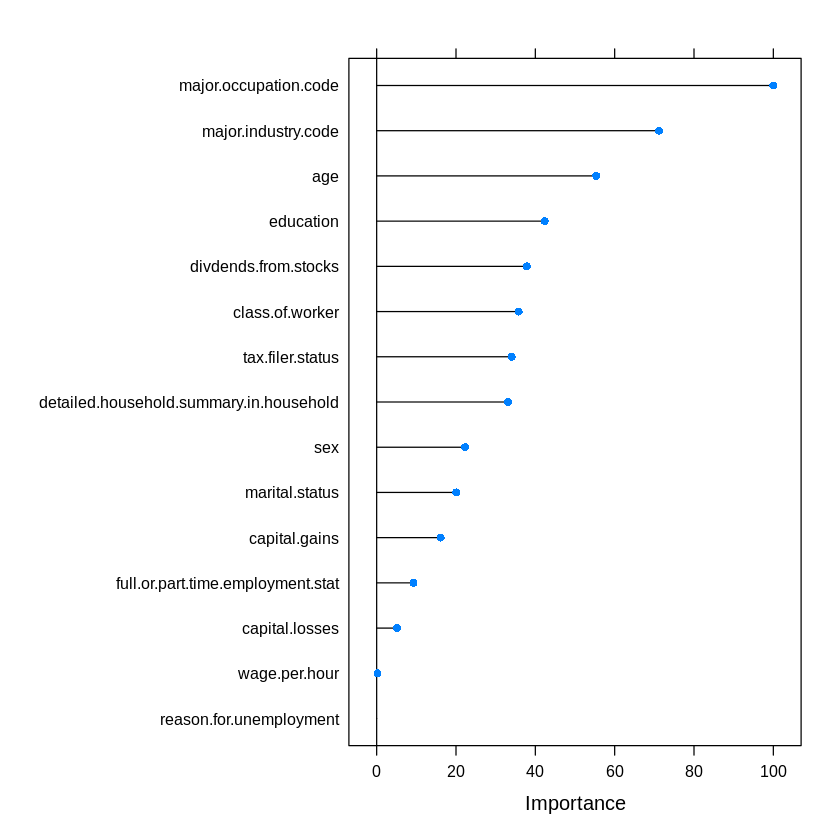

In [92]:
plot(varImp(rfup))

In [93]:
fittedUp<- predict(rfup, Test_data)
fittedUp[1:10]

[1] Below Below Below Above Below Below Below Below Above Below
Levels: Above Below

In [94]:
confusionMatrix(reference = Test_data$total.person.earnings, data = fittedUp, mode = "everything")


Confusion Matrix and Statistics

          Reference
Prediction Above Below
     Above  4540  8554
     Below  1646 85022
                                          
               Accuracy : 0.8978          
                 95% CI : (0.8959, 0.8996)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4223          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.73392         
            Specificity : 0.90859         
         Pos Pred Value : 0.34672         
         Neg Pred Value : 0.98101         
              Precision : 0.34672         
                 Recall : 0.73392         
                     F1 : 0.47095         
             Prevalence : 0.06201         
         Detection Rate : 0.04551         
   Detection Prevalence : 0.13125         
      Balanced Acc

## **ROC Curves**

In [98]:
fittedProb <- predict(rfup, Test_data,type ="prob")

In [111]:
predictions <- fittedProb$Below
labels <- Test_data$total.person.earnings
pred <- prediction(predictions,labels)
pred

A prediction instance
  with 99762 data points

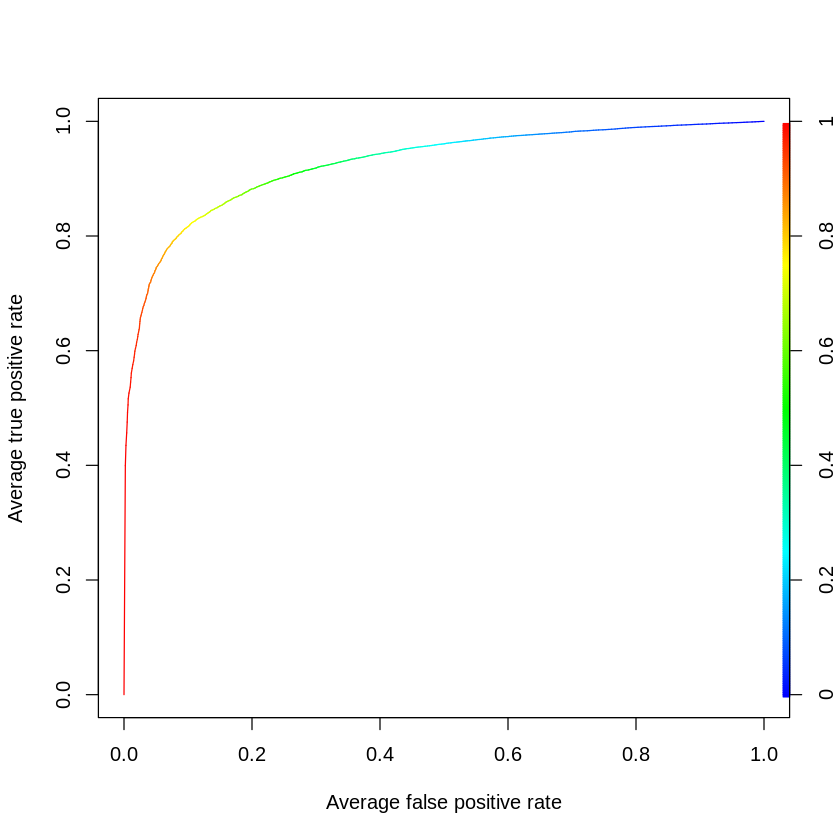

In [112]:
perf <- performance(pred,"tpr","fpr")
plot(perf, avg = "threshold",colorize = T)


## Training and Resampling Multiple Models

In [149]:
methodCtrl <- trainControl(
  method = "repeatedcv",
  number = 5,
  savePredictions = "final",
  classProbs = T,
  sampling = "up",
  summaryFunction = twoClassSummary
)


In [154]:
methodList <- c("rf","svmRadial")

In [156]:
install.packages("kernlab")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [157]:
library(kernlab)


Attaching package: ‘kernlab’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha




In [158]:
ensemble <- caretList(y= test$total.person.earnings, x = test[,1:15],data = test,
                      metric = "ROC",
                      trControl = methodCtrl,
                      methodList = methodList)

Warning message in trControlCheck(x = trControl, y = target):
“indexes not defined in trControl.  Attempting to set them ourselves, so each model in the ensemble will have the same resampling indexes.”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”


ERROR: ignored

In [151]:
resampledList <- resamples(ensemble)
summary(resampleList)

ERROR: ignored

# Reults